In [ ]:
#| eval: false
! [ -e /content ] && pip install -Uqq xcube # upgrade xcube on colab

# L2R

> Building a learning-to-rank model

### Collab Model (Attempt #2)

#### Getting the collab data ready for fastai's `CollabDataLoaders`

In [ ]:
assert collab_bootst_path.exists()
collab_bootstrap = torch.load(collab_bootst_path)
test_eq(collab_bootstrap.keys(), ['toks', 'lbs', 'mut_info_lbl_entropy', 'mutual_info_jaccard'])
toks = collab_bootstrap.get('toks', None)
lbs = collab_bootstrap.get('lbs', None)
info = collab_bootstrap.get('mutual_info_jaccard', None)
for o in (toks, lbs, info): assert o is not None
test_eq(info.shape, (len(toks), len(lbs)))

Tossing in some pandas to get the data ready so that we can use fastai's collab `DataLoaders`:

*Note:* Storing the tokens and the labels in a dataframe as `object` will take up a lot of RAM space when we prepare that `DataLoader`. So we are going to store the corresponding token and label indices instead in a dataframe called `df_collab`. We are also going to store the tokens and the labels with their corresponding indices in seperate dataframes (this will help in quick merging for analysis).

---

In [ ]:
ranked = info.argsort(descending=True, dim=0).argsort(dim=0)

In [ ]:
info_ranked =torch.stack((info, ranked), dim=2).flatten(start_dim=1)

In [ ]:
cols = pd.MultiIndex.from_product([range(len(lbs)), ['mutual_info', 'rank']], names=['label', 'key2'])

In [ ]:
df_collab = pd.DataFrame(info_ranked, index=range(len(toks)), columns=cols)
df_collab.index.name='token'

In [ ]:
df_collab.head()

label        0                    1                    2              \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000022    866.0    0.000011   1022.0    0.000022   1156.0   
1        0.000000  56854.0    0.000000  41418.0    0.000000  56853.0   
2        0.000000  56855.0    0.000000  41419.0    0.000000  56854.0   
3        0.000000  56856.0    0.000000  41420.0    0.000000  56855.0   
4        0.000000  56857.0    0.000000  41421.0    0.000000  56856.0   

label        3                    4                    5              \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    823.0    0.000033    984.0    0.000011    643.0   
1        0.000000  41410.0    0.000000  22836.0    0.000000  41413.0   
2        0.000000  41411.0    0.000000  22837.0    0.000000  41414.0   
3        0.000000  41412.0    0.000000  22838.0    0.000000  41415.0   
4        0.000000  41413.0    0.000000  22839.0    0.000000  41416.0   

label        6                    7                    8              \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    779.0    0.000011    793.0    0.000022   1005.0   
1        0.000000  41417.0    0.000000  41416.0    0.000000  56856.0   
2        0.000000  41418.0    0.000000  41417.0    0.000000  56857.0   
3        0.000000  41419.0    0.000000  41418.0    0.000000  56858.0   
4        0.000000  41420.0    0.000000  41419.0    0.000000  56859.0   

label        9                    10                   11             \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    819.0    0.000011    850.0    0.000065   1432.0   
1        0.000000  41417.0    0.000000  41422.0    0.000000  55902.0   
2        0.000000  41418.0    0.000000  41423.0    0.000000  55903.0   
3        0.000000  41419.0    0.000000  41424.0    0.000000  55904.0   
4        0.000000  41420.0    0.000000  41425.0    0.000000  55905.0   

label        12                   13                   14             \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    665.0    0.000011    634.0    0.000011    761.0   
1        0.000000  41409.0    0.000000  41409.0    0.000000  41409.0   
2        0.000000  41410.0    0.000000  41410.0    0.000000  41410.0   
3        0.000000  41411.0    0.000000  41411.0    0.000000  41411.0   
4        0.000000  41412.0    0.000000  41412.0    0.000000  41412.0   

label        15                   16                     17             \
key2  mutual_info     rank mutual_info     rank   mutual_info     rank   
token                                                                    
0        0.001175   1270.0    0.000011   1595.0  6.888287e-07  31864.0   
1        0.000000  56731.0    0.000000  41474.0  0.000000e+00  32418.0   
2        0.000000  56732.0    0.000000  41475.0  0.000000e+00  32419.0   
3        0.000000  56733.0    0.000000  41476.0  0.000000e+00  32420.0   
4        0.000000  56734.0    0.000000  41477.0  0.000000e+00  32421.0   

label        18                   19                   20             \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000011    979.0    0.000022    910.0    0.000065   1142.0   
1        0.000000  41419.0    0.000000  56852.0    0.000000  55896.0   
2        0.000000  41420.0    0.000000  56853.0    0.000000  55897.0   
3        0.000000  41421.0    0.000000  56854.0    0.000000  55898.0   
4        0.000000 

In [ ]:
# df_collab.loc[:, ( slice(0, len(lbs)), ['mutual_info'])] = info.cpu()
# df_collab.loc[:, ( slice(0, len(lbs)), ['rank'])] = info_ranked.cpu()

In [ ]:
df_collab = df_collab.stack(level=0).reset_index().rename_axis(None, axis=1)
df_collab[['token', 'label']] = df_collab[['token', 'label']].astype(np.int32) 

---

In [ ]:
df_collab = pd.DataFrame(info, columns=range(len(lbs)), index=range(len(toks)))
test_eq(len(df_collab), len(toks))
test_eq(len(df_collab.columns), len(lbs))
df_collab.index.name = 'token'
df_collab.columns.name = 'label'

In [ ]:
# with pd.option_context('display.max_columns', 50):
pd.set_option('display.max_columns', 50)
df_collab.head()
# pd.reset_option('all')

label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,8897,8898,8899,8900,8901,8902,8903,8904,8905,8906,8907,8908,8909,8910,8911,8912,8913,8914,8915,8916,8917,8918,8919,8920,8921
token,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000022,0.000011,0.000022,0.000011,0.000033,0.000011,0.000011,0.000011,0.000022,0.000011,0.000011,0.000065,0.000011,0.000011,0.000011,0.001175,0.000011,6.888287e-07,0.000011,0.000022,0.000065,0.000185,0.000036,0.000109,0.000062,...,0.000094,0.000036,0.000112,0.000046,0.000114,0.000136,0.000135,0.000025,0.00012,0.000001,0.000022,0.000011,0.000011,0.000896,0.000011,0.000265,0.000011,0.000014,3.375316e-07,0.000011,0.000011,0.000033,0.000011,0.000011,6.888287e-07
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [ ]:
df_collab = df_collab.stack().reset_index(name='mutual_info')
test_eq(len(df_collab), len(toks)*len(lbs))
df_collab[['token', 'label']] = df_collab[['token', 'label']].astype(np.int32) 

---

In [ ]:
df_collab.head(3)

,token,label,mutual_info,rank
0,0,0,0.000022,866.0
1,0,1,0.000011,1022.0
2,0,2,0.000022,1156.0


In [ ]:
df_collab.memory_usage()/1024**3

Index          1.192093e-07
token          1.906211e+00
label          1.906211e+00
mutual_info    1.906211e+00
rank           1.906211e+00
dtype: float64

In [ ]:
df_toks = pd.DataFrame([(i, w) for i,w in enumerate(toks)], columns=['token', 'tok_val'])
df_lbs = pd.DataFrame([(i,w) for i, w in enumerate(lbs)], columns=['lbl', 'lbl_val'])

In [ ]:
df_toks.head(3)

,token,tok_val
0,0,xxunk
1,1,xxpad
2,2,xxbos


In [ ]:
df_lbs.head(3)

,lbl,lbl_val
0,0,003.0
1,1,003.1
2,2,003.8


Let us save this format, as this is what we will use to train our Collab Model

In [ ]:
df_collab.to_feather(collab_data_path)
df_toks.to_feather(collab_tok_path)
df_lbs.to_feather(collab_lbl_path)

#### Statistical Analysis of that `mutual_info` column before we build the collab `DataLoaders`

In [ ]:
# with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
#     args = (collab_data_path,)
#     kwargs = {}
#     df_collab = executor.submit(_read_collab, *args, **kwargs).result()

In [ ]:
assert collab_data_path.exists()
df_collab = pd.read_feather(collab_data_path)
test_eq(df_collab.dtypes.mutual_info, np.float32)

In [ ]:
# import gc; gc.collect()
# df_collab.info()
# ic(df_collab.memory_usage().sum()/1024**3)
# ic(sys.getsizeof(df_collab)/1024**3);

In [ ]:
df_collab.head(3)

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356


In [ ]:
# df_collab.token.nunique()

In [ ]:
mut_infos = df_collab['mutual_info'].to_numpy()

In [ ]:
mut_infos.min(), mut_infos.max(), mut_infos.mean()

(0.0, 0.99999636, 7.697003e-05)

In [ ]:
%%time
skew(mut_infos)

CPU times: user 1.74 s, sys: 1.01 s, total: 2.75 s
Wall time: 2.75 s


142.75660007849734

Before we attempt to transform `mut_infos` we need to convert any non-zeros in it to eps:

In [ ]:
# np.where(mut_infos<0, 1, 0).sum() # or, better yet
where_negs = mut_infos < 0
ic(np.sum(where_negs))

ic| np.sum(where_negs): 111226814


111226814

In [ ]:
eps = np.float32(1e-20)

In [ ]:
mut_infos[where_negs] = eps

In [ ]:
test_eq(np.sum(mut_infos<0), 0)

In [ ]:
np.min(mut_infos), np.max(mut_infos), np.mean(mut_infos)

(0.0, 0.99999636, 7.697003e-05)

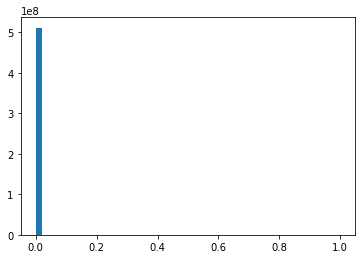

In [ ]:
hist, bins, _ = plt.hist(mut_infos, bins=50)
# plt.yscale('log')

**Applying log transform:**

In [ ]:
log_mut_infos = np.log(mut_infos + eps)

In [ ]:
np.isnan(log_mut_infos).sum(), np.isneginf(log_mut_infos).sum(), np.isinf(log_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(log_mut_infos)

CPU times: user 2.03 s, sys: 462 ms, total: 2.49 s
Wall time: 2.49 s


-1.3383214188674972

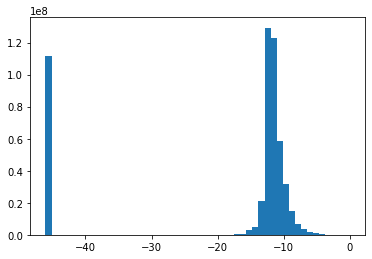

In [ ]:
hist, bins, _ = plt.hist(log_mut_infos, bins=50)

**Applying sqrt transform:**

In [ ]:
sqrt_mut_infos = np.sqrt(mut_infos)

In [ ]:
np.isnan(sqrt_mut_infos).sum(), np.isinf(sqrt_mut_infos).sum(), np.isneginf(sqrt_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(sqrt_mut_infos)

CPU times: user 1.6 s, sys: 1.04 s, total: 2.63 s
Wall time: 2.63 s


16.40865608826817

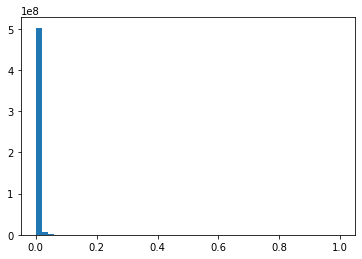

In [ ]:
hist, bins, _ = plt.hist(sqrt_mut_infos, bins=50)

**Apply box-cox transfrom:**

In [ ]:
bcx_mut_infos, *_ = boxcox(mut_infos+eps)

In [ ]:
np.isnan(bcx_mut_infos).sum(), np.isinf(bcx_mut_infos).sum(), np.isneginf(bcx_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(bcx_mut_infos)

CPU times: user 1.7 s, sys: 921 ms, total: 2.62 s
Wall time: 2.62 s


-0.885981418331696

In [ ]:
df_collab['bcx_mutual_info'] = bcx_mut_infos

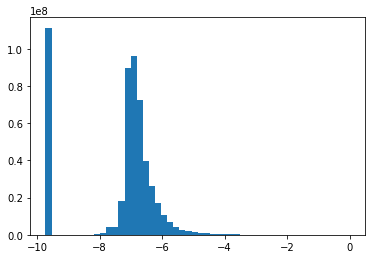

In [ ]:
hist, bins, _ = plt.hist(bcx_mut_infos, bins=50)

In [ ]:
np.min(bcx_mut_infos), np.max(bcx_mut_infos), np.mean(bcx_mut_infos), np.median(bcx_mut_infos)

(-9.734209, -3.6358892e-06, -7.381837, -6.9605794)

In [ ]:
df_collab.head(3)

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356


---

In [ ]:
import psutil
psutil.cpu_percent()

0.2

In [ ]:
psutil.virtual_memory()

svmem(total=63205289984, available=51459112960, percent=18.6, used=11144814592, free=45459292160, active=145227776, inactive=17213775872, buffers=49983488, cached=6551199744, shared=57344, slab=101920768)

In [ ]:
dict(psutil.virtual_memory()._asdict())

{'total': 63205289984,
 'available': 51458928640,
 'percent': 18.6,
 'used': 11144998912,
 'free': 45459050496,
 'active': 145195008,
 'inactive': 17213902848,
 'buffers': 50032640,
 'cached': 6551207936,
 'shared': 57344,
 'slab': 101941248}

In [ ]:
psutil.virtual_memory().percent

18.6

In [ ]:
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total

81.41651284730541

In [ ]:
import os
import psutil
pid = os.getpid()
python_process = psutil.Process(pid)
memoryUse = python_process.memory_info()[0]/2.**30  # memory use in GB...I think
print('memory use:', memoryUse)

memory use: 19.49184799194336


In [ ]:
from tqdm import tqdm
from time import sleep
import psutil

with tqdm(total=100, desc='cpu%', position=1) as cpubar, tqdm(total=100, desc='ram%', position=0) as rambar:
    while True:
        rambar.n=psutil.virtual_memory().percent
        cpubar.n=psutil.cpu_percent()
        rambar.refresh()
        cpubar.refresh()
        sleep(0.5)

---

In [ ]:
df_collab_high_ranked = df_collab[df_collab['rank'] <= 10].reset_index(drop=True)

In [ ]:
df_collab_high_ranked.head()

,token,label,mutual_info,rank
0,9,6109,0.008734,7.0
1,9,6111,0.008734,5.0
2,10,6461,0.027056,1.0
3,10,8030,0.034794,4.0
4,10,8696,0.034794,1.0


In [ ]:
df_collab_high_ranked['label'].nunique(), df_collab_high_ranked['token'].nunique()

(8922, 36909)

Box plots using matplotlib and seaborn

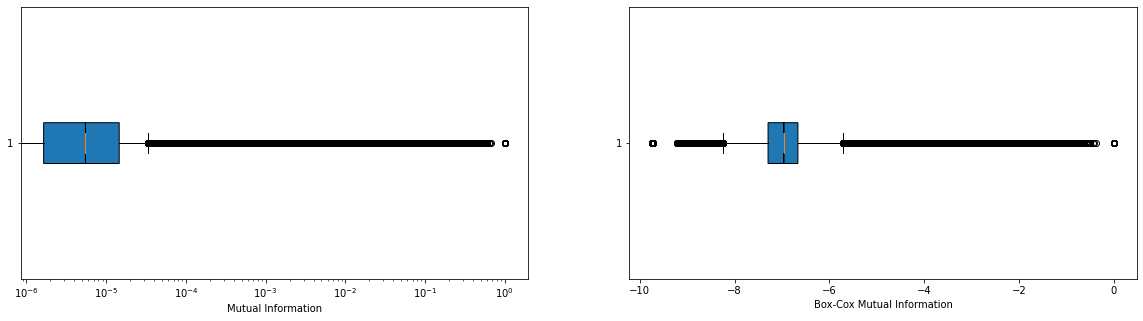

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.boxplot(df_collab.mutual_info, vert=0, notch=True, patch_artist=True)
ax1.set_xscale('log')
ax1.set_xlabel('Mutual Information')

ax2.boxplot(df_collab.bcx_mutual_info, vert=0, notch=True, patch_artist=True)
# ax2.set_xscale('symlog')
ax2.set_xlabel('Box-Cox Mutual Information')

plt.show()

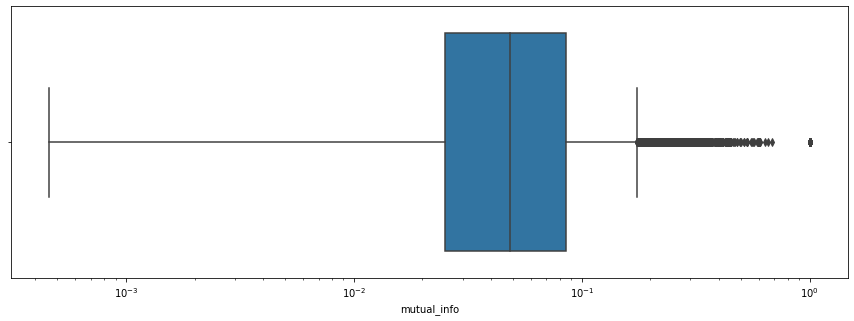

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.set_xscale('log')
sns.boxplot(x=df_collab_high_ranked['mutual_info'], ax=ax)
plt.show()

Histograms and kde using matplotlib:

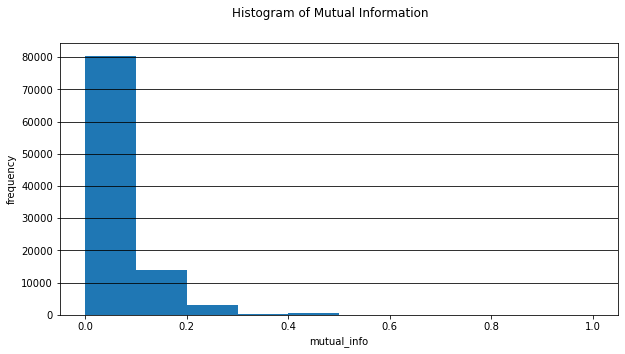

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2)

hist, bins, pathches = ax1.hist(df_collab_high_ranked['mutual_info'])
ax1.set_xlabel('mutual_info')
ax1.set_ylabel('frequency')
ax1.grid(axis='y', color='black')

# ax2.hist(df_collab['mutual_info'])
# ax2.set_xlabel('mutual_info')
# ax2.set_ylabel('frequency')
# ax2.grid(axis='y', color='black')
# ax2.set_yscale('log')

fig.suptitle('Histogram of Mutual Information')
plt.show()

In [ ]:
df_collab_high_ranked['mutual_info'].shape

(98142,)

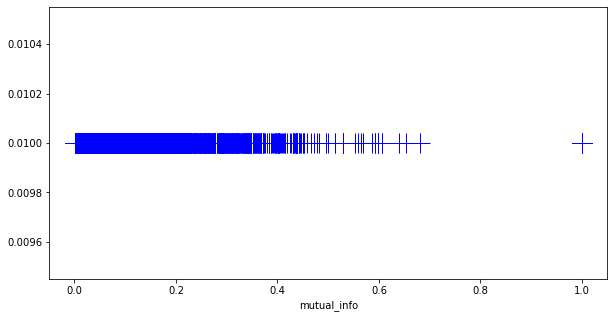

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_collab_high_ranked['mutual_info'], np.full_like(df_collab_high_ranked['mutual_info'], 0.01), 'b+', ms=20)
ax.set_xlabel('mutual_info')
plt.show()

In [ ]:
bdrs = [bins[i:i+2] for i in range(0, len(bins)-1)]
pd.DataFrame({'boundary': bdrs, 'counts': hist})

,boundary,counts
0,"[-6.852321e-05, 0.09993797]",511675593.0
1,"[0.09993797, 0.19994445]",14854.0
2,"[0.19994445, 0.29995096]",3323.0
3,"[0.29995096, 0.39995742]",191.0
4,"[0.39995742, 0.4999639]",454.0
5,"[0.4999639, 0.5999704]",30.0
6,"[0.5999704, 0.6999769]",5.0
7,"[0.6999769, 0.7999834]",0.0
8,"[0.7999834, 0.8999899]",0.0
9,"[0.8999899, 0.99999636]",94.0


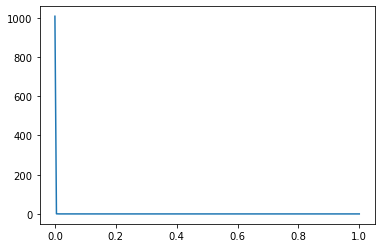

In [ ]:
from scipy.stats import gaussian_kde
density = gaussian_kde(df_collab['mutual_info'])
xs = np.linspace(0, 1, 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs, density(xs))
plt.show()

Histograms and kde using pandas

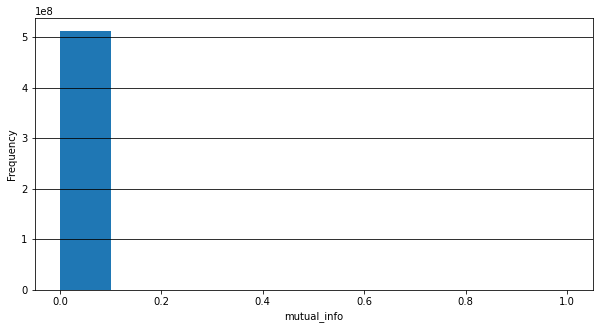

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
df_collab['mutual_info'].plot.hist(ax=ax)
ax.set_xlabel('mutual_info')
ax.grid(axis='y', color='black')
plt.show()

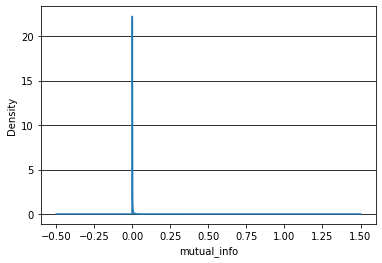

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
df_collab['mutual_info'].plot.kde(ax=ax)
ax.set_xlabel('mutual_info')
ax.grid(axis='y', color='black')
plt.show()

---

Close everything below this (it was a scratchpad)

In [ ]:
from scipy.special import erf
SQRT_TWO_PI = math.sqrt(2*math.pi)

def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (np.exp(-(x-mu)**2/2/sigma**2))/(SQRT_TWO_PI*sigma)

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + erf((x-mu)/np.sqrt(2)/sigma))/2

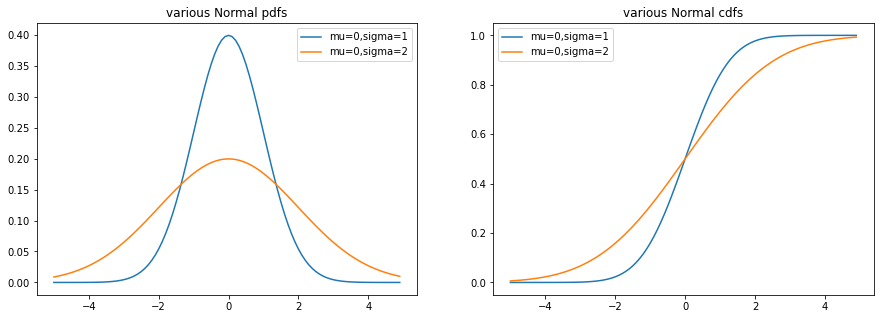

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
xs = np.arange(-5, 5, step=0.1)
ax1.plot(xs, normal_pdf(xs, sigma=1), label='mu=0,sigma=1')
ax1.plot(xs, normal_pdf(xs, sigma=2), label='mu=0,sigma=2')
ax1.legend()
ax1.set_title("various Normal pdfs")

ax2.plot(xs, normal_cdf(xs, sigma=1), label='mu=0,sigma=1')
ax2.plot(xs, normal_cdf(xs, sigma=2), label='mu=0,sigma=2')
ax2.legend()
ax2.set_title("various Normal cdfs")

plt.show()

In [ ]:
def my_hist(data, y_scale=None, x_label=None, y_label=None, title="Histogram"):
    n, bins, pathches = plt.hist(data)
    plt.grid(axis='y', color='b')
    if y_scale is not None: plt.yscale(y_scale)
    if x_label is not None: plt.xlabel(x_label)
    if y_label is not None: plt.ylabel(y_label)
    maxfreq = n.max()
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.title(title);

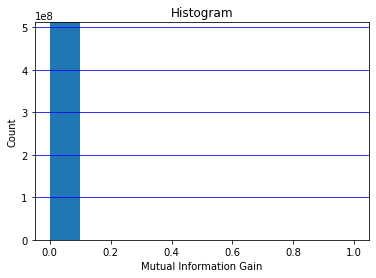

In [ ]:
my_hist(mut_infos, x_label="Mutual Information Gain", y_label="Count")

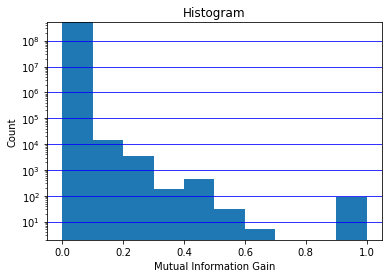

In [ ]:
my_hist(mut_infos, y_scale='log', x_label="Mutual Information Gain", y_label="Count")

In [ ]:
np.log(mut_infos)

array([-10.735371 , -11.4250345, -10.735371 , ...,        -inf,        -inf,        -inf], dtype=float32)

In [ ]:
eps = np.float32(1e-20)
my_hist(np.log(mut_infos), x_label="Mutual Information Gain", y_label="Count")

In [ ]:
from scipy.stats import gaussian_kde

density = gaussian_kde(-np.log(mut_infos+eps))
xs = np.linspace(0, 1, 20)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs, density(xs))
plt.show()

Histograms:

In [ ]:
grades = [83, 95, 91, 87, 70, 0, 85, 82, 100, 67, 73, 77, 0, 99]
len(grades)

14

In [ ]:
def _hist(data, start, end, n_bins):
    # import pdb; pdb.set_trace()
    bins, step = np.linspace(start, end, n_bins+1, retstep=True)
    hist = Counter(np.minimum(data//step*step, bins[-2]))
    xs = array(list(hist.keys())) + step/2
    ys = array(list(hist.values()))
    plt.bar(xs,
           hist.values(),
           step,
           edgecolor=(0,0,0))
    plt.axis([start, end, 0, max(hist.values())])

    plt.grid(axis='y', color='black')
    plt.xticks(ticks=bins, rotation=90)
    plt.xlabel(f"{int(step)}%-ile")
    plt.ylabel("# of Students")
    plt.title("Distribution of Exam 1 grades")
    plt.show()

In [ ]:
grades = np.random.randint(0, 100, 50)
min(grades), max(grades)

(3, 98)

In [ ]:
_hist(mut_infos, 0, 1, 10)

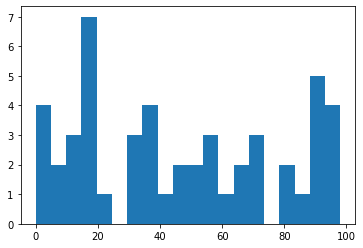

In [ ]:
hist, bins, _ = plt.hist(grades, bins=20)

In [ ]:
assert (np.logspace(2, 5, 5) == np.power(10.0, np.linspace(2,5,5))).all()

Log scale:

In [ ]:
diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
diamonds.apply(lambda x: x.nunique())

carat        273
cut            5
color          7
clarity        8
depth        184
table        127
price      11602
x            554
y            552
z            375
dtype: int64

In [ ]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [ ]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


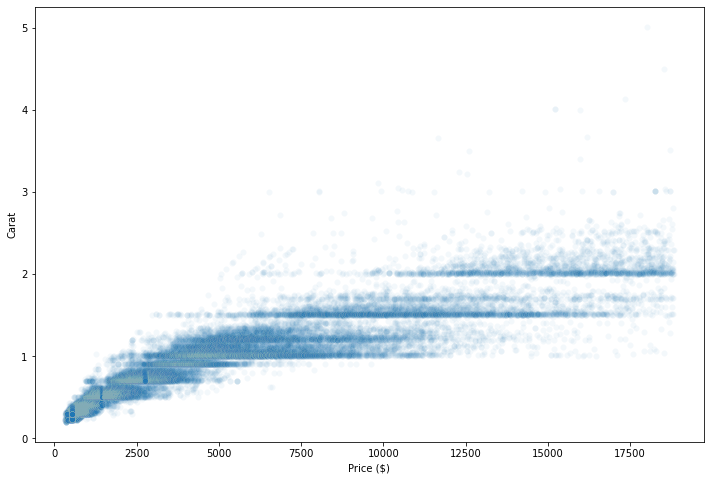

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='price', y='carat', data=diamonds, ax=ax, alpha=.05)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Carat')
plt.show();

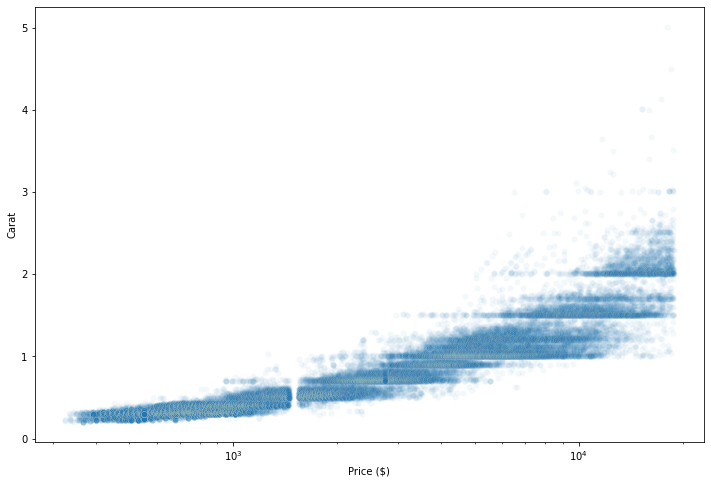

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='price', y='carat', data=diamonds, ax=ax, alpha=.05)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Carat')
ax.set_xscale('log') # added
plt.show();

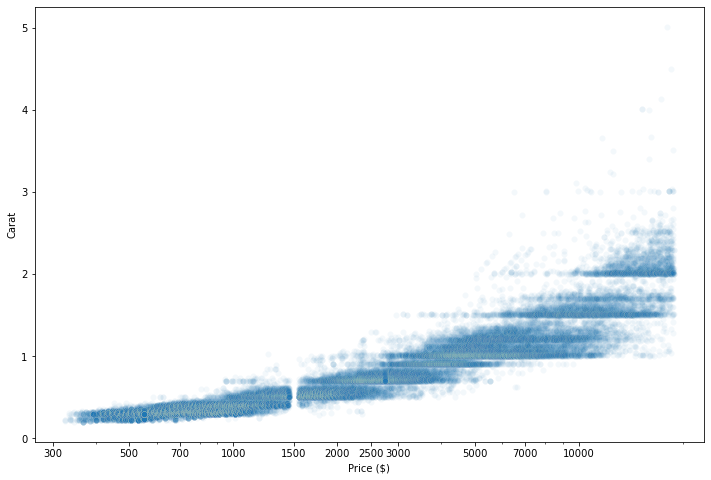

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='price', y='carat', data=diamonds, ax=ax, alpha=.05)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Carat')
ax.set_xscale('log') 
ax.set_xticks([300, 500, 700, 1000, 1500, 2000, 2500, 3000, 5000, 7000, 10000]) # added
ax.set_xticklabels([300, 500, 700, 1000, 1500, 2000, 2500, 3000, 5000, 7000, 10000]) # added
plt.show();

In [ ]:
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()
formatter.set_scientific(False)

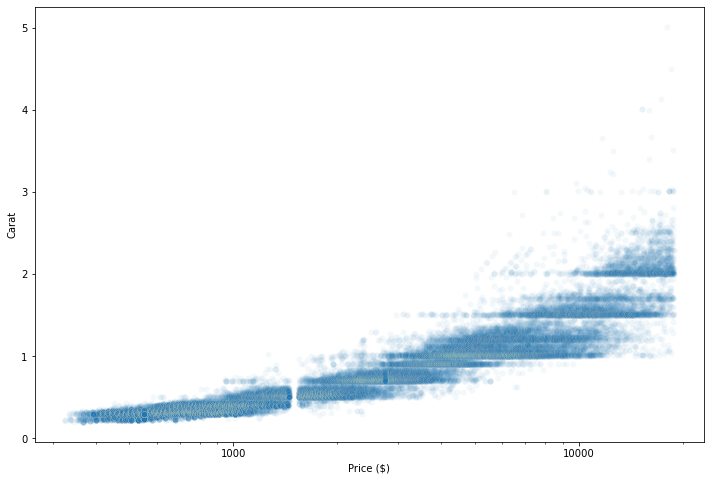

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='price', y='carat', data=diamonds, ax=ax, alpha=.05)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Carat')
ax.set_xscale('log') 
for axis in (ax.xaxis, ax.yaxis): axis.set_major_formatter(formatter)
plt.show();

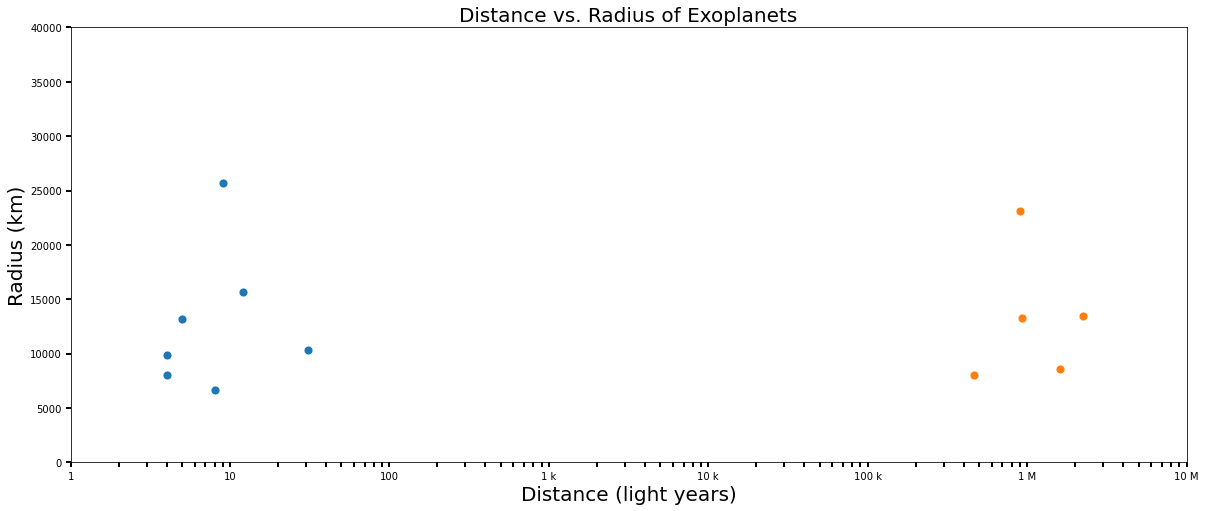

In [ ]:
import matplotlib.ticker as ticker

# Extremely far exoplanets
extremes = [465413, 2231451, 897931, 931312, 1612312]
radius_extreme = [7986, 13456, 23144, 13254, 8562]

# Nearer exoplanets
exo_distance = [5, 4, 4, 8, 9, 12, 31]
exo_radius = [13165, 7985, 9847, 6654, 25647, 15644, 10312]

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)

sns.scatterplot(x=exo_distance, y=exo_radius, s=80)
sns.scatterplot(x=extremes, y=radius_extreme, s=80)

ax.axis([1, 10000000, 0, 40000])

ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.EngFormatter())

ax.tick_params(bottom=True, which='both', width=2, length=5, labelsize=10)

ax.set_title('Distance vs. Radius of Exoplanets', fontsize=20)
ax.set_xlabel('Distance (light years)', fontsize=20)
ax.set_ylabel('Radius (km)', fontsize=20)

plt.show()

We can now build the `Dataloaders` object from this dataframe `df_collab`, by defaultit takes the first column as the user (in our case the token) and the second column as the item (in our case the label), and the third column as the ratings (in our case the frequency):

#### Make `Dataloaders` and load it:

##### Using Fastai's Mid-Level API:

###### Loading DataFrame

In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
df[['text', 'labels']] = df[['text', 'labels']].astype(str)
len(df)
df.head(2)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False


In [ ]:
f = ColReader('labels', label_delim=';')
lbs_frqs = Counter()
for o in df.itertuples(): lbs_frqs.update(f(o))

In [ ]:
with open(path.parent/'data'/'code_desc.pkl', 'rb') as f: lbs_desc = pickle.load(f)
df_toks = pd.read_feather(collab_tok_path)
df_lbs = pd.read_feather(collab_lbl_path)
df_lbs['description'] = df_lbs['lbl_val'].map(lbs_desc)
df_lbs['freq'] = df_lbs['lbl_val'].map(lbs_frqs)

In [ ]:
df_collab = pd.read_feather(collab_data_path)

In [ ]:
df_collab.head()

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356
3,0,3,0.000011,823.0,-6.753679
4,0,4,0.000033,984.0,-6.391284


In [ ]:
df_collab.token.nunique(), df_collab.label.nunique()

(57352, 8922)

Let's sample a tiny df from `df_collab` for quick experimentaion with `DataLoaders` creation and Model building/analysis:

In [ ]:
num = 100
mask = df_collab.token.isin(range(num)) & df_collab.label.isin(range(num))
test_eq(mask.sum(), num**2)

In [ ]:
df_tiny = df_collab[mask].reset_index(drop=True)
df_tiny.head()

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356
3,0,3,0.000011,823.0,-6.753679
4,0,4,0.000033,984.0,-6.391284


In [ ]:
test_eq(df_tiny.token.nunique(), num) 
test_eq(df_tiny.label.nunique(), num) 

In [ ]:
# df_tiny = df_collab.sample(n=5000, random_state=88).reset_index(drop=True)

In [ ]:
# df_tiny.to_feather('df_tiny.ft')

In [ ]:
# df_tiny = pd.read_feather('df_tiny.ft')

Let's just delete the `df_collab` to free up RAM:

In [ ]:
df_collab = pd.DataFrame()
lst = [df_collab]
del lst
del df_collab
import gc; gc.collect()

0

In [ ]:
ic(len(df_tiny));

ic| len(df_tiny): 10000


In [ ]:
df_tiny.apply(lambda x: x.nunique())

token               100
label               100
mutual_info        3845
rank               6221
bcx_mutual_info    3742
dtype: int64

###### `DataLoader` for Collab Regression:

In [ ]:
%%time
f_x = ColReader(['token', 'label'])
f_y = ColReader('bcx_mutual_info')
# L(f_x(o) for o in df_tiny.itertuples())
# L(f_y(o) for o in df_tiny.itertuples())
tfms_x = [f_x, ListToTensor()]
tfms_y = [f_y]
tfms = [tfms_x, tfms_y]
splits = RandomSplitter(seed=42)(df_tiny)
dsets = Datasets(df_tiny, tfms, splits=splits)
# dsets = Datasets(df_collab, tfms=tfms)

CPU times: user 9.76 ms, sys: 0 ns, total: 9.76 ms
Wall time: 9.37 ms


We need to make sure that the training and validation set has all the tokens and labels:

In [ ]:
df_trn, df_val = df_tiny.loc[splits[0]].reset_index(drop=True), df_tiny.loc[splits[1]].reset_index(drop=True)
assert df_trn.token.nunique() == num & df_trn.label.nunique() == num
assert df_val.token.nunique() == num & df_val.label.nunique() == num

In [ ]:
test_eq(len(dsets.train) + len(dsets.valid), len(df_tiny))

In [ ]:
dsets[:5]

[(tensor([0, 0]), -6.530355930328369),
 (tensor([0, 1]), -6.753678798675537),
 (tensor([0, 2]), -6.530355930328369),
 (tensor([0, 3]), -6.753678798675537),
 (tensor([0, 4]), -6.391283988952637)]

In [ ]:
type(dsets[0][0]), type(dsets[0][1])

(torch.Tensor, numpy.float64)

In [ ]:
x, y = dsets[0]

In [ ]:
ic(x)
ic(y);

ic| x: tensor([0, 0])
ic| y: -6.530355930328369


In [ ]:
dsets.decode((x,y))

((#2) [tensor(0),tensor(0)], -6.530355930328369)

In [ ]:
class MyDataLoader(DataLoader):
    def randomize(self):
        seed = np.random.default_rng().integers(0, 2**32-1, 1).item()
        self.rng = np.random.default_rng(seed)
    
    def shuffle_fn(self, idxs): return self.rng.permutation(idxs)

    def get_idxs(self):
        if self.n is not None: idxs = range(self.n)
        if self.shuffle: idxs = (idx for idx in self.shuffle_fn(idxs))
        return idxs

In [ ]:
%%time
# bs = 1024 * 50
bs = 128
# dls_collab = dsets.dataloaders(bs=bs, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0).cuda()
dls_collab0 = MyDataLoader(dsets.train, bs=bs, shuffle=True, after_batch=partial(to_device, device=default_device()), num_workers=num_cpus())
dls_collab1 = MyDataLoader(dsets.valid, bs=bs, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=num_cpus())
test_eq(len(dls_collab0), np.ceil(len(dsets.train)/128)) 
test_eq(len(dls_collab1), np.ceil(len(dsets.valid)/128))
dls_collab = DataLoaders(dls_collab0, dls_collab1)

CPU times: user 2.34 ms, sys: 7.58 ms, total: 9.92 ms
Wall time: 8.85 ms


In [ ]:
dls_collab.fake_l.num_workers

16

In [ ]:
len(dls_collab.train), len(dls_collab.valid)

(63, 16)

In [ ]:
# with open(dls_collab_path, 'wb') as f: pickle.dump(dls_collab, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open(dls_collab_path, 'rb') as f: dls_collab = pickle.load(f)

In [ ]:
%%time
torch.save(dls_collab, dls_collab_path, pickle_protocol=4)

CPU times: user 13.7 s, sys: 51.1 s, total: 1min 4s
Wall time: 1min 5s


In [ ]:
%%time
dls_collab = torch.load(dls_collab_path, map_location=lambda storage, loc: storage.cuda(0))

CPU times: user 2.26 s, sys: 25.9 s, total: 28.2 s
Wall time: 37.2 s


In [ ]:
test_eq(dls_collab.device, default_device())

In [ ]:
# bs = 1024
xb, yb = dls_collab.one_batch()
test_eq(xb.dtype, torch.int64)
test_eq(xb.shape, (bs, 2))
test_eq(type(yb), Tensor)
test_eq(yb.shape, [bs])
test_eq(default_device().index, 0)
test_eq(default_device().index, sum([o.device.index for o in (xb,yb)]))

In [ ]:
one_batch = torch.cat((xb, yb.unsqueeze(-1)), dim=-1)

In [ ]:
df_one_batch = pd.DataFrame(one_batch, columns=['token', 'label', 'bcx_mutual_info'])
df_one_batch.head(10)

,token,label,bcx_mutual_info
0,58.0,86.0,-6.339581
1,9.0,11.0,-6.708092
2,68.0,53.0,-6.856811
3,20.0,31.0,-7.170342
4,73.0,91.0,-7.107794
5,56.0,80.0,-6.228233
6,43.0,63.0,-6.740957
7,12.0,62.0,-9.734209
8,73.0,72.0,-6.357643
9,38.0,4.0,-7.309844


In [ ]:
df_collab_one_batch = df_trn.loc[:bs-1, ['token','label', 'bcx_mutual_info']]
df_collab_one_batch[['token', 'label', 'bcx_mutual_info']] = df_collab_one_batch[['token', 'label', 'bcx_mutual_info']].astype(np.float)
df_collab_one_batch.head(10)

,token,label,bcx_mutual_info
0,58.0,86.0,-6.339581
1,9.0,11.0,-6.708092
2,68.0,53.0,-6.856811
3,20.0,31.0,-7.170342
4,73.0,91.0,-7.107794
5,56.0,80.0,-6.228233
6,43.0,63.0,-6.740957
7,12.0,62.0,-9.734209
8,73.0,72.0,-6.357643
9,38.0,4.0,-7.309844


In [ ]:
assert df_one_batch.equals(df_collab_one_batch)

In [ ]:
test_eq(len(dls_collab.train), np.ceil(len(dls_collab.dataset)/bs))
test_eq(len(dls_collab.valid), np.ceil(len(dls_collab.valid.dataset)/bs))

---
Trying to solve the memory problem in `DataLoader` batching:

In [ ]:
it = iter(dls_collab)
it

<generator object DataLoader.__iter__>

In [ ]:
import pdb
while True:
    try:
        pdb.set_trace()
        xb, yb = next(it)
        print(f"{xb = }, {yb = }")
    except StopIteration as e: break

###### `DataLoader` for [Learning to Rank (L2R)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf)

In [ ]:
df_collab = pd.read_feather(collab_data_path)
df_collab = df_collab.drop(['mutual_info', 'bcx_mutual_info'], axis=1)
df_collab.head()

,token,label,rank
0,0,0,866.0
1,0,1,1022.0
2,0,2,1156.0
3,0,3,823.0
4,0,4,984.0


In [ ]:
test_eq(df_collab.token.nunique(), 57352) 
test_eq(df_collab.label.nunique(), 8922)

**`df_tiny`**: If we need to a smaller dataset for quick iteration

Note: For technical reasons behind building a `dataloader` the number of tokens should be $x (mod 64) \equiv 8$.

In [ ]:
num_toks, num_lbs = 8 + 5*64, 104

In [ ]:
# might have to repeat this a few times until the follwoing cell asserst true
rnd_toks = np.random.randint(0, len(df_collab.token.unique()), size=(num_toks,) )
rnd_lbs = np.random.randint(0, len(df_collab.label.unique()), size=(num_lbs,) )
mask = df_collab.token.isin(rnd_toks) & df_collab.label.isin(rnd_lbs)
df_tiny = df_collab.loc[mask].reset_index(drop=True)

In [ ]:
test_eq(df_tiny.token.nunique(), num_toks) 
test_eq(df_tiny.label.nunique(), num_lbs) 

In [ ]:
# df_tiny.to_feather('df_tiny.ft')
df_tiny = pd.read_feather('df_tiny.ft')

In [ ]:
# df_tiny = df_tiny.drop(['mutual_info', 'bcx_mutual_info'], axis=1)

In [ ]:
df_tiny.head()

,token,label,rank
0,82,60,42717.0
1,82,62,27548.0
2,82,86,10617.0
3,82,136,52177.0
4,82,195,1359.0


**Only for `df_tiny`**:

Due to random sampling the rankings are not uniform i.e., not from 0 to 99. A litte preprocessing to make sure that we have uniform rankings for all labels. 

In [ ]:
grouped = df_tiny.groupby('label', group_keys=False)

In [ ]:
def sort_rerank(df, column='rank'):
    df = df.sort_values(by=column)
    df['rank'] = range(len(df))
    return df

In [ ]:
df_tiny = grouped.apply(sort_rerank)

In [ ]:
dict_grouped = dict(list(df_tiny.groupby('label')))

In [ ]:
a_lbl = random.choice(list(dict_grouped.keys()))

In [ ]:
dict_grouped[a_lbl]

,token,label,rank
1537,1538,6972,0
2369,2600,6972,1
2161,2093,6972,2
3825,4138,6972,3
2057,1988,6972,4
...,...,...,...
33361,56446,6972,323
33465,56456,6972,324
33673,56513,6972,325
33985,56894,6972,326


Using Pandas `groupby` to add *relevance scores* to each token-label pair based on the corresponding ranks:

In [ ]:
grouped = df_collab.groupby('label')

In [ ]:
# dict_grouped = dict(list(grouped))
# _tmp = dict_grouped[16].copy()
# _tmp.head()

In [ ]:
def cut(df, qnts, column='rank'):
    num = df.to_numpy()
    bins = np.quantile(num[:, -1], qnts)
    num[:, -1] = len(bins) - np.digitize(num[:, -1], bins)
    # bins = np.quantile(df['rank'], qnts)
    # df[column] = len(bins) - np.digitize(df['rank'], bins)
    # df[column] = pd.qcut(df[column], qnts, labels=labels)
    return num

In [ ]:
%%time
qnts = np.concatenate([array([0]), np.geomspace(1e-2, 1, 10)])
scored = grouped.apply(cut, qnts) 

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 13.8 ms


**[Simulate Pandas `groupby` using `Numpy/PyTorch`](https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/38015063#38015063):** (Why? `Pandas` are cute but speed thrills! More importantly: "Memory")

In [ ]:
def score(df, qnts):
    # import pdb; pdb.set_trace()
    # from IPython import embed; embed()
    data = qnts.new_tensor(df.to_numpy())
    test_eq(data.shape, (len(df), 3)) # dim1 is a 3 tuple (token, label, rank)
    # sort by the labels
    data = data[data[:, 1].argsort()]
    # indices of the unique labels
    # import pdb; pdb.set_trace()
        # splt_idxs = np.concatenate([torch.as_tensor(np.unique(data[:, 1].cpu().numpy(), return_index=True)[1], device=default_device(), dtype=torch.int).cpu().numpy(), array([len(data)])])
        # splt_idxs = list(splt_idxs[1:] - splt_idxs[:-1])
    splt_idxs = np.unique(data[:, 1].cpu().numpy(), return_index=True)[1][1:]
    # split by the unique labels
    data = np.split(data.cpu().numpy(), splt_idxs)
    # stacking the 0th dim with label specific data
    data = np.stack(data)
    # data = torch.as_tensor(data, dtype=qnts.dtype)
    data = qnts.new_tensor(data)
    # test_eq(data.shape, (8922, 57352, 3))
    # computing the bins based on qnts
    bins = torch.quantile(data[:, :, -1], qnts, dim=1)
    # test_eq(bins.shape, (101, 8922))
    # replacing ranks with relevance scores
    relv_scores = bins.shape[0] - torch.searchsorted(bins.T, data[:, :, -1], right=False) # shape (8922, 57352)
    data = torch.cat((data, relv_scores.unsqueeze(-1)), dim=-1)
    # data[:, :, -1] = relv_scores
    return data # dim 0: labels, dim 1: 3 tuple (token, label, rank, score)

In [ ]:
qnts = to_device(torch.concat([tensor([0]), torch.logspace(torch.log10(tensor(1e-4)), torch.log10(tensor(1)), 100)]))
ic(qnts);

ic| qnts: tensor([0.0000e+00, 1.0000e-04, 1.0975e-04, 1.2045e-04, 1.3219e-04, 1.4508e-04, 1.5923e-04, 1.7475e-04, 1.9179e-04, 2.1049e-04, 2.3101e-04, 2.5354e-04, 2.7826e-04, 3.0539e-04, 3.3516e-04, 3.6784e-04,
                  4.0370e-04, 4.4306e-04, 4.8626e-04, 5.3367e-04, 5.8570e-04, 6.4281e-04, 7.0548e-04, 7.7426e-04, 8.4975e-04, 9.3260e-04, 1.0235e-03, 1.1233e-03, 1.2328e-03, 1.3530e-03, 1.4850e-03, 1.6298e-03,
                  1.7886e-03, 1.9630e-03, 2.1544e-03, 2.3645e-03, 2.5950e-03, 2.8480e-03, 3.1257e-03, 3.4305e-03, 3.7649e-03, 4.1320e-03, 4.5349e-03, 4.9770e-03, 5.4623e-03, 5.9948e-03, 6.5793e-03, 7.2208e-03,
                  7.9248e-03, 8.6975e-03, 9.5455e-03, 1.0476e-02, 1.1498e-02, 1.2619e-02, 1.3849e-02, 1.5199e-02, 1.6681e-02, 1.8307e-02, 2.0092e-02, 2.2051e-02, 2.4201e-02, 2.6561e-02, 2.9151e-02, 3.1993e-02,
                  3.5112e-02, 3.8535e-02, 4.2292e-02, 4.6416e-02, 5.0941e-02, 5.5908e-02, 6.1359e-02, 6.7342e-02, 7.3907e-02, 8.1113e-02, 8.9022e-02, 9.7701e-02

In [ ]:
%%time
# scored_toks = score(df_collab, qnts)
scored_toks = score(df_tiny, qnts)

CPU times: user 619 ms, sys: 9.86 ms, total: 629 ms
Wall time: 86.8 ms


In [ ]:
ic(scored_toks.shape);

ic| scored_toks.shape: torch.Size([104, 328, 4])


Save!!

In [ ]:
torch.save(scored_toks, 'scored_tokens.pth')

In [ ]:
# df_tiny = df_tiny.pivot(index='token', columns='label', values=['rank', 'bcx_mutual_info'])
# df_tiny_copy = df_tiny.pivot(index='token', columns='label', values='rank')
# columns = [(p, o) for o in range(num) for p in ('rank', 'bcx_mutual_info')]
# df_tiny = df_tiny[columns].swaplevel(axis=1)

Create training and validation split:

In [ ]:
scored_toks = torch.load('scored_tokens.pth')
test_eq(scored_toks.device, default_device())
# test_eq(scored_toks.device, torch.device("cpu"))

If you want to get it into the cpu RAM:

In [ ]:
scored_toks = scored_toks.cpu()
torch.cuda.empty_cache()
ic(scored_toks.shape);

ic| scored_toks.shape: torch.Size([104, 328, 4])


**Remember**: In `scored_toks` dim 0: labels, dim 1: 4 tuple (token, label, rank, score). Below is an example:

In [ ]:
scored_toks[97, 32]

tensor([11156.,  8326.,    32.,    25.])

In [ ]:
df_tiny[(df_tiny.token == 11156) & (df_tiny.label == 8326)]

,token,label,rank
7065,11156,8326,32


In [ ]:
ranks = scored_toks[:, :, 2].unique(dim=1).sort(-1)[0]
ranks_shouldbe = torch.arange(scored_toks.shape[1], dtype=torch.float).expand(scored_toks.shape[0], -1)
test_eq(ranks, ranks_shouldbe)

In [ ]:
def train_test_split(scored_toks, n_lbs, n_toks):
    test_eq(scored_toks.shape, (n_lbs, n_toks, 4))
    qnts = (1 - torch.concat([tensor([0.]), torch.logspace(torch.log10(tensor(1e-4)), torch.log10(tensor(1.)), 10)])).flip(dims=(0,))
    test_eq(qnts.shape, [11])
    bins = torch.quantile(scored_toks[:, :, -1], qnts, dim=1)
    test_eq(bins.shape, (11, n_lbs))
    binned_toks = torch.searchsorted(bins.T, scored_toks[:, :, -1])
    test_eq(binned_toks.shape, (n_lbs, n_toks))
    # import pdb; pdb.set_trace()
    bin_nums = binned_toks[0].unique() # all the labels have same binning because we are quantizing the scores
    right_bds = bins[:, 0][bin_nums]
    left_bds = torch.concat([tensor([-torch.inf]), bins[:, 0][bin_nums[1:]-1]])
    bin_bds = torch.concat((left_bds[:,None], right_bds[:, None]), dim=1)
    bin_size = torch.bincount(binned_toks[0])
    probs = binned_toks.new_ones(binned_toks.shape).div(3.*bin_size[binned_toks])
    # probs[bin_size[binned_toks] > 4] = 2.*probs[bin_size[binned_toks] > 4] 
    # probs[bin_size[binned_toks] <= 4] = 0.001*probs[bin_size[binned_toks] <= 4] 
    probs[binned_toks < bin_nums[-2]] = 2.*probs[binned_toks < bin_nums[-2]] 
    # probs[bin_size[binned_toks] <= 4] = 0.001*probs[bin_size[binned_toks] <= 4] 
    is_valid = torch.bernoulli(probs)
    return scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds

In [ ]:
def pad_split(binned_toks, is_valid):
    "pads the validation set for each label to the nearest multiple of 16"
    val_sizes = is_valid.sum(dim = -1)
    sl = 16 * torch.floor(val_sizes.max()/16) + 16
    deficit = (sl - val_sizes).int()
    top3bins = binned_toks[0].unique().sort(descending=True)[0][:3]
    for i,d in enumerate(deficit):
        val_idxs = torch.where(is_valid[i]==True)[0]
        trn_idxs = torch.where(is_valid[i]==False)[0]
        top3idxs = torch.where(torch.isin(binned_toks[i], top3bins))[0].sort()[0]
        trn_idxs = torch.as_tensor(np.setdiff1d(trn_idxs.cpu().numpy(), top3idxs.cpu().numpy()))
        more_val_idxs = trn_idxs[torch.randperm(len(trn_idxs))[:d].long()]
        is_valid[i][more_val_idxs] = 1
    return sl.int().item()

In [ ]:
%%time
# n_lbs, n_toks = 8922, 57352
n_lbs, n_toks = num_lbs, num_toks
scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds = train_test_split(scored_toks, n_lbs, n_toks)

CPU times: user 61.6 ms, sys: 0 ns, total: 61.6 ms
Wall time: 45.3 ms


In [ ]:
%%time
val_sl = pad_split(binned_toks, is_valid)
test_eq(is_valid.sum(dim=-1).unique().item(), val_sl)
print(f"{val_sl=}")

val_sl=16
CPU times: user 308 ms, sys: 0 ns, total: 308 ms
Wall time: 41.6 ms


Taking a look at the train/valid split for some labels (just to make sure we ticked all boxes!):

In [ ]:
df1 = pd.DataFrame(scored_toks[89], columns=['token', 'label', 'rank', 'score']).sort_values(by='score', ascending=False)
df1

,token,label,rank,score
0,7674.0,7697.0,0.0,101.0
1,5755.0,7697.0,1.0,63.0
2,5285.0,7697.0,2.0,55.0
3,4173.0,7697.0,3.0,51.0
4,1306.0,7697.0,4.0,48.0
...,...,...,...,...
301,51590.0,7697.0,301.0,1.0
300,51498.0,7697.0,300.0,1.0
299,51347.0,7697.0,299.0,1.0
298,50970.0,7697.0,298.0,1.0


In [ ]:
name = partial(namestr, namespace=globals())
row_vals = apply(torch.Tensor.size, (scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds))
pd.DataFrame(index = list(itertools.chain.from_iterable(apply(name, [scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds]))), columns=['shape'], data={'shape': row_vals})

,shape
scored_toks,"(104, 328, 4)"
binned_toks,"(104, 328)"
probs,"(104, 328)"
is_valid,"(104, 328)"
bin_size,"(11,)"
bin_bds,"(8, 2)"


In [ ]:
df2 = pd.DataFrame({'bin #': range(len(bin_size)), 'bin_bds': list(bin_bds.numpy()), 'bin_size': bin_size})
df2

In [ ]:
a_lbl = 1834
df_lbs.iloc[[a_lbl]]
# df_lbs.loc[[a_lbl]]

,lbl,lbl_val,description,freq
1834,1834,340,Multiple sclerosis,297


In [ ]:
df3 = pd.DataFrame({'token': scored_toks[a_lbl, :, 0] ,'score': scored_toks[a_lbl, :, -1], 'probs': probs[a_lbl], 'binned_toks': binned_toks[a_lbl], 'bds': list(bin_bds[binned_toks[a_lbl]].numpy()), 'size': bin_size[binned_toks[a_lbl]], 'is_valid': is_valid[a_lbl]})
df3 = df_toks.merge(df3, on='token')
df3.sort_values(by='score', ascending=False).head(20)

,token,tok_val,score,probs,binned_toks,bds,size,is_valid
4005,4005,sclerosis,101.0,0.055556,10,"[99.265625, 101.0]",6,0.0
19135,19135,avonex,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
20216,20216,glatiramer,100.0,0.055556,10,"[99.265625, 101.0]",6,0.0
5892,5892,neurogenic,100.0,0.055556,10,"[99.265625, 101.0]",6,0.0
16410,16410,copaxone,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
4006,4006,baclofen,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
5515,5515,bound,99.0,0.033333,9,"[88.04297, 99.265625]",10,0.0
21429,21429,remitting,97.0,0.033333,9,"[88.04297, 99.265625]",10,0.0
25573,25573,betaseron,96.0,0.033333,9,"[88.04297, 99.265625]",10,0.0
9651,9651,provigil,95.0,0.033333,9,"[88.04297, 99.265625]",10,0.0


In [ ]:
is_valid[a_lbl].sum(), df3['is_valid'].sum()

(tensor(32.), 32.0)

In [ ]:
df3[df3['is_valid'] == 1].sort_values(by='score', ascending=False)#.groupby('binned_toks').size()

,token,tok_val,score,probs,binned_toks,bds,size,is_valid
4006,4006,baclofen,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
16410,16410,copaxone,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
19135,19135,avonex,100.0,0.055556,10,"[99.265625, 101.0]",6,1.0
9655,9655,amantadine,80.0,0.022989,8,"[77.59375, 88.04297]",29,1.0
4227,4227,proteus,77.0,0.008439,7,"[66.44141, 77.59375]",79,1.0
20079,20079,dyskinesias,75.0,0.008439,7,"[66.44141, 77.59375]",79,1.0
20882,20882,7q,58.0,0.003030,6,"[55.1875, 66.44141]",220,1.0
41319,41319,retropancreatic,52.0,0.001088,5,"[44.328125, 55.1875]",613,1.0
18465,18465,abulia,30.0,0.000140,3,"[22.832031, 33.003906]",4746,1.0
20471,20471,eomis,30.0,0.000140,3,"[22.832031, 33.003906]",4746,1.0


In [ ]:
def count_topbins(binned_toks):
    "counts the number of top 2 bins for each label"
    top_lens = binned_toks.new_zeros(binned_toks.shape[0]) # for every label contains the number of top 2 bins (top bins are the ones which have most relevant tokens for that label) 
    top_bins = binned_toks[0].unique()[-2:]
    for i, binned in enumerate(binned_toks):
        topbin_idxs = torch.nonzero(torch.isin(binned, top_bins)).view(-1)
        val_idxs = torch.where(is_valid[i] == 1)[0]
        top = val_idxs[torch.where(torch.isin(val_idxs, topbin_idxs))[0]]
        top_lens[i] = top.shape[0]
    return top_lens

In [ ]:
top_lens = count_topbins(binned_toks)
ic(torch.where(top_lens >= 6)[0].shape, top_lens.max(), top_lens.min());

ic| torch.where(top_lens >= 6)[0].shape: torch.Size([0])
    top_lens.max(): tensor(5)
    top_lens.min(): tensor(0)


Prepare the validation dataset:

In [ ]:
ic(scored_toks.shape, is_valid.shape);

ic| scored_toks.shape: torch.Size([104, 328, 4])
    is_valid.shape: torch.Size([104, 328])


In [ ]:
val_dset = scored_toks[is_valid.bool()].view(scored_toks.shape[0], val_sl, -1)
test_eq(val_dset.shape, (scored_toks.shape[0], val_sl, scored_toks.shape[2]))
ic(val_dset.shape);

ic| val_dset.shape: torch.Size([104, 16, 4])


In [ ]:
# valid_idxs_sorted = scored_toks[a_lbl, :, -1][valid_idxs.bool()].sort(descending=True, stable=True).indices
# valid_idxs_sorted

Prepare the training dataset:

Don't remove the validation tokens.

In [ ]:
# scored_toks[a_lbl][valid_idxs.bool()][valid_idxs_sorted]
# scored_toks[a_lbl][valid_idxs.bool()]
# trn = scored_toks[a_lbl][~valid_idxs.bool()]
# trn = scored_toks[~is_valid.bool()].view(scored_toks.shape[0], scored_toks.shape[1]-val_sl, -1) # Use this if you want to remove validation tokens
trn = scored_toks.clone() # Use this if you don't want to remove the validation tokens

In [ ]:
# test_eq(trn.shape, (scored_toks.shape[0], scored_toks.shape[1]-val_sl, scored_toks.shape[2])) # Use this if you want to remove validation tokens
test_eq(trn.shape, scored_toks.shape) # Use this if you don't want to remove the validation tokens
ic(trn.shape, val_dset.shape);

ic| trn.shape: torch.Size([104, 328, 4])
    val_dset.shape: torch.Size([104, 16, 4])


Now that we have prepared the train/valid split we can delete `scored_toks` and `is_valid` to reclaim some memory:

In [ ]:
torch.save((trn, val_dset), 'trn_val_split_tiny.pkl')
# torch.save((trn, val_dset), 'trn_val_split.pkl')

In [ ]:
scored_toks, is_valid  = None, None
import gc; gc.collect()

376

This stuff goes inside the custom `DataLoader`:

In [ ]:
# datetime.fromtimestamp((path/'trn_val_split.pkl').stat().st_ctime)
!ls -la {path/'trn_val_split.pkl'}
!ls -la {path/'trn_val_split_tiny.pkl'}

-rw-r--r-- 1 deb deb 8191681843 Dec  2 18:02 /home/deb/xcube/nbs/examples/mimic/sample/trn_val_split.pkl
-rw-r--r-- 1 deb deb 573459 Dec  8 14:49 /home/deb/xcube/nbs/examples/mimic/sample/trn_val_split_tiny.pkl


In [ ]:
# trn, val_dset = torch.load('trn_val_split.pkl')
trn, val_dset = torch.load('trn_val_split_tiny.pkl')
val_dset = val_dset.unsqueeze(0)
ic(trn.shape, val_dset.shape);

ic| trn.shape: torch.Size([104, 328, 4])
    val_dset.shape: torch.Size([1, 104, 16, 4])


1. Shuffle the training dataset:

In [ ]:
randperm = torch.randint(low=0, high=trn.shape[1], size=(trn.shape[1],))
ic(randperm.shape);
trn = trn[:, randperm]

ic| randperm.shape: torch.Size([57352])


2. Split the training set into sqs that make the data and batching them:

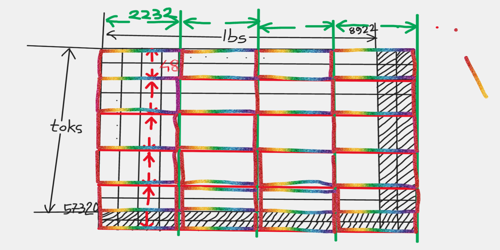

In [ ]:
img = Image.open(path/'LRdataloader.png').resize((500,250))
img

Parameters you need to select: `lbs_chunks`, `tok_sl`:

In [ ]:
lbs_chunks = 4
# lbs_chunks = 32 # for tiny
size_of_dim0 = torch.ceil(trn.new_empty(1).fill_(trn.shape[0]/lbs_chunks)).item()
pad_len_dim0 = int(lbs_chunks * np.floor(trn.shape[0]/lbs_chunks) + lbs_chunks - trn.shape[0]) # smallest number greater than `trn.shape[0]` divisible by `lbs_chunks`:
ic(size_of_dim0, pad_len_dim0);
trn_pad = F.pad(trn, (0,0,0,0,0,pad_len_dim0), value=-1)
ic(trn_pad.shape);

ic| size_of_dim0: 2231.0, pad_len_dim0: 2
ic| trn_pad.shape: torch.Size([8924, 57352, 4])


In [ ]:
trn_sl = 64
trn_sqs = list(torch.split(trn_pad, split_size_or_sections=trn_sl, dim=1))
ic(len(trn_sqs), trn_sqs[0].shape, trn_sqs[1].shape, trn_sqs[-1].shape);
test_eq(len(trn_sqs), np.ceil(trn.shape[1]/trn_sl))
test_eq(trn_sqs[-1].shape, (trn_pad.shape[0], trn_pad.shape[1]%trn_sl,4));
deficit = trn_sl - trn_sqs[-1].shape[1]
ic(deficit);

ic| len(trn_sqs): 897
    trn_sqs[0].shape: torch.Size([8924, 64, 4])
    trn_sqs[1].shape: torch.Size([8924, 64, 4])
    trn_sqs[-1].shape: torch.Size([8924, 8, 4])
ic| deficit: 56


In [ ]:
if deficit: 
    test_eq(trn_sqs[-1].shape, (trn_pad.shape[0], trn_pad.shape[1]%trn_sl,4));
    # trn_sqs[-1] = torch.concat((trn_sqs[-1],trn.new_empty((trn_sqs[-1].shape[0], deficit,3)).fill_(-1)), dim=1)
    trn_sqs[-1] = trn_sqs[-1].repeat_interleave(trn_sl//trn_sqs[-1].shape[1], dim=1)
test_eq(trn_sqs[-1].shape, (trn_pad.shape[0], trn_sl,4));
ic(len(trn_sqs), trn_sqs[0].shape, trn_sqs[1].shape, trn_sqs[-1].shape);

ic| len(trn_sqs): 897
    trn_sqs[0].shape: torch.Size([8924, 64, 4])
    trn_sqs[1].shape: torch.Size([8924, 64, 4])
    trn_sqs[-1].shape: torch.Size([8924, 64, 4])


In [ ]:
trn_sqs = map(partial(torch.chunk, chunks=lbs_chunks), trn_sqs)
trn_sqs = itertools.chain.from_iterable(trn_sqs)
trn_sqs, trn_sqs1, trn_sqs2, trn_sqs3 = itertools.tee(trn_sqs, 4)

In [ ]:
L(trn_sqs1).map(Tensor.size).unique(), len(L(trn_sqs2))

((#1) [torch.Size([2231, 64, 4])], 3588)

This is where the number 3588 is coming from:

In [ ]:
(328/64) # tok_sl 64 (#tok_chunks = #toks/trn_sl)

5.125

In [ ]:
57352/64

896.125

---

In [ ]:
(128/4) # labels chunk size is 4 (#lbs_chunk_sz = #lbs/lbs_chunks)

32.0

In [ ]:
8924/4

2231.0

---

In [ ]:
6*32 #(tok_chunks * lbs_chunks) This is basically the # of datapoints, which gets batched. So #mini-batches in an epoch = #datapoints/bs

192

In [ ]:
897*4

3588

---

In [ ]:
dset = trn_sqs
# dset_it = iter(dset)
# n = next(dset_it)
# ic(n.shape);

In [ ]:
bs = 64
bs_tiny = 8
# btchs = chunked(dset, bs_tiny)
# btch_it = iter(btchs)
# xb = next(btch_it)

In [ ]:
# ic(type(xb), len(xb), xb[0].shape)
# btch = torch.stack(xb)
# ic(btch.shape);

The number of mini-batches in an epoch:

In [ ]:
3588/bs, 192/bs_tiny

(56.0625, 24.0)

In [ ]:
# number of mini-batches in an epoch
int(np.ceil((np.ceil(trn.shape[1]/trn_sl) * lbs_chunks)/bs))

57

In [ ]:
c = 0
for btch in chunked(dset, bs):
    xb = torch.stack(btch)
    lbs = torch.unique(xb[:,:,:,1], dim=-1)
    print(f"{xb.shape = }, {lbs.shape = }")
    c += 1
print(f"The number of minibatches = {c}")

xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4]), lbs.shape = torch.Size([64, 2231, 1])
xb.shape = torch.Size([64, 2231, 64, 4])

In [ ]:
trn_dset = torch.concat(trn_sqs)
test_eq(trn_dset.shape, (trn.shape[0]*len(trn_sqs), trn_sl, 3))
ic(trn_dset.shape, val_dset.shape);

In [ ]:
ic(xb.shape, torch.unique(xb[:,:,:,1], dim=-1).shape);

ic| xb.shape: torch.Size([4, 2231, 64, 4])
    torch.unique(xb[:,:,:,1], dim=-1).shape: torch.Size([4, 2231, 1])


Showtime: Writing our custom `DataLoader`

In [ ]:
%less {inspect.getsourcefile(DataLoader)}

In [ ]:
class TrnDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        self.sl, self.lbs_chunks = kwargs.pop('sl', None), kwargs.pop('lbs_chunks', None)
        if self.sl is None: self.sl = 64
        if self.lbs_chunks is None: self.lbs_chunks = 4
        super().__init__(*args, **kwargs)
        
    def randomize(self):
        seed = np.random.default_rng().integers(0, 2**32-1, 1).item()
        self.rng = np.random.default_rng(seed)
    
    def shuffle_fn(self, idxs): return self.rng.permutation(idxs)

    def get_idxs(self):
        if self.n is not None: idxs = range(self.n)
        if self.shuffle: idxs = (idx for idx in self.shuffle_fn(idxs))
        return idxs
    
    def create_batch(self, start_idx):
        return self.dset[start_idx: min(start_idx+self.bs, self.dset.shape[0])]
        # if self.device: to_device(btch, self.device)
        # return btch
        
    def __len__(self):
        return int(np.ceil((np.ceil(self.dataset.shape[1]/self.sl) * self.lbs_chunks)/self.bs))
    
    def before_iter(self):
        # shuffling
        randperm = torch.randint(low=0, high=self.dataset.shape[1], size=(self.dataset.shape[1],))
        self.dataset = self.dataset[:, randperm]
        # self.lbs_chunks = 4
        size_of_dim0 = torch.ceil(self.dataset.new_empty(1).fill_(self.dataset.shape[0]/self.lbs_chunks)).item()
        pad_len_dim0 = int(self.lbs_chunks * np.floor(self.dataset.shape[0]/self.lbs_chunks) + self.lbs_chunks - self.dataset.shape[0])
        self.dataset_pad = F.pad(self.dataset, (0,0,0,0,0,pad_len_dim0), value=-1)

        trn_sqs = list(torch.split(self.dataset_pad, split_size_or_sections=self.sl, dim=1))
        test_eq(len(trn_sqs), np.ceil(self.dataset_pad.shape[1]/self.sl))
        test_eq(trn_sqs[-1].shape, (self.dataset_pad.shape[0], self.dataset_pad.shape[1]%self.sl,4))
        deficit = self.sl - trn_sqs[-1].shape[1]
        if deficit: 
            test_eq(trn_sqs[-1].shape, (self.dataset_pad.shape[0], self.dataset_pad.shape[1]%self.sl,4));
            # trn_sqs[-1] = torch.concat((trn_sqs[-1], self.dataset_pad.new_empty((trn_sqs[-1].shape[0], deficit,3)).fill_(-1)), dim=1)
            trn_sqs[-1] = trn_sqs[-1].repeat_interleave(self.sl//trn_sqs[-1].shape[1], dim=1)
        test_eq(trn_sqs[-1].shape, (self.dataset_pad.shape[0], self.sl,4));
        # self.dset = torch.concat(trn_sqs)
        # self.dset = torch.stack(trn_sqs)
        
        trn_sqs = map(partial(torch.chunk, chunks=self.lbs_chunks), trn_sqs)
        trn_sqs = itertools.chain.from_iterable(trn_sqs)
        self.dset = trn_sqs
        # test_eq(self.dset.shape, (self.dataset_pad.shape[0]*len(trn_sqs), self.sl, 3))
        # test_eq(self.dset.shape, (len(trn_sqs), self.dataset_pad.shape[0], self.sl, 3))
        # print(f"{self.dset.shape=}")
        # yield from (btch for btch in dset.split(self.bs))
    
    def create_batches(self, samps):
            # trn_sqs = list(torch.split(self.dataset, split_size_or_sections=self.sl, dim=1))
            # test_eq(len(trn_sqs), np.ceil(self.dataset.shape[1]/self.sl))
            # test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3))
            # deficit = self.sl - trn_sqs[-1].shape[1]
            # if deficit: 
            #     test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3));
            #     trn_sqs[-1] = torch.concat((trn_sqs[-1], self.dataset.new_empty((trn_sqs[-1].shape[0], deficit,3)).fill_(-1)), dim=1)
            # test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.sl,3));
            # # self.dset = torch.concat(trn_sqs)
            # self.dset = torch.stack(trn_sqs)
            # # test_eq(self.dset.shape, (self.dataset.shape[0]*len(trn_sqs), self.sl, 3))
            # test_eq(self.dset.shape, (len(trn_sqs), self.dataset.shape[0], self.sl, 3))
            # print(f"{self.dset.shape=}")
            # # yield from (btch for btch in dset.split(self.bs))
        # chunks = range(0, self.dset.shape[0], self.bs)
        # with ProcessPoolExecutor(self.n_workers) as ex:
        # with Pool(processes=self.num_workers) as pool:
        # yield from pool.imap_unordered(self.create_batch, chunks, 16)
        # yield from map(self.create_batch, chunks)
        # yield from chunked(self.dset, chunk_sz=self.bs)
        yield from (torch.stack(btch) for btch in self.chunkify(self.dset))
        

In [ ]:
%save dataloader.py _i

In [ ]:
from multiprocessing import Pool

class FDataLoader:
    def __init__(self, dataset, sl=48, bs=128, n_workers=1, device=None):
        store_attr('dataset,sl,bs,n_workers,device')
        
    def create_batch(self, start_idx):
        btch = self.dset[start_idx: min(start_idx+self.bs, self.dset.shape[0])]
        if self.device: to_device(btch, self.device)
        return btch
    
    def __iter__(self):
        trn_sqs = list(torch.split(self.dataset, split_size_or_sections=self.sl, dim=1))
        test_eq(len(trn_sqs), np.ceil(self.dataset.shape[1]/self.sl))
        test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3))
        deficit = self.sl - trn_sqs[-1].shape[1]
        if deficit: 
            test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.dataset.shape[1]%self.sl,3));
            trn_sqs[-1] = torch.concat((trn_sqs[-1], self.dataset.new_empty((trn_sqs[-1].shape[0], deficit,3)).fill_(-1)), dim=1)
        test_eq(trn_sqs[-1].shape, (self.dataset.shape[0], self.sl,3));
        # self.dset = torch.concat(trn_sqs)
        self.dset = torch.stack(trn_sqs)
        # test_eq(self.dset.shape, (self.dataset.shape[0]*len(trn_sqs), self.sl, 3))
        test_eq(self.dset.shape, (len(trn_sqs), self.dataset.shape[0], self.sl, 3))
        print(f"{self.dset.shape=}")
        # yield from (btch for btch in dset.split(self.bs))
        chunks = np.arange(0, self.dset.shape[0], self.bs)
        # with ProcessPoolExecutor(self.n_workers) as ex:
        with Pool(processes=self.n_workers) as pool:
            yield from pool.imap_unordered(self.create_batch, chunks, 16)
        

Let's create the train/valid `DataLoaders`:

In [ ]:
trn, val_dset = torch.load('trn_val_split.pkl')
# trn, val_dset = torch.load('trn_val_split_tiny.pkl')
val_dset = val_dset.unsqueeze(0)
ic(trn.shape, val_dset.shape);

ic| trn.shape: torch.Size([8922, 57352, 4])
    val_dset.shape: torch.Size([1, 8922, 32, 4])


In [ ]:
bs_full = 32
bs_tiny = 8
sl = 64
lbs_chunks_full = 4
lbs_chunks_tiny = 32
trn_dl = L2RDataLoader(dataset=trn, sl=sl, bs=bs_full, lbs_chunks=lbs_chunks_full, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)
# trn_dl = TrnDataLoader(dataset=trn, sl=sl_tiny, lbs_chunks=lbs_chunks_tiny, bs=bs_tiny, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)
# trn_dl = L2RDataLoader(dataset=trn, sl=sl, lbs_chunks=lbs_chunks_tiny, bs=bs_tiny, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)

In [ ]:
%less {inspect.getsourcefile(L2RDataLoader)}

Don't forget to check the length

In [ ]:
len(trn_dl)

113

In [ ]:
ic(trn_dl.device, trn_dl.num_workers, trn_dl.fake_l.num_workers);

ic| trn_dl.device: None
    trn_dl.num_workers: 1
    trn_dl.fake_l.num_workers: 0


In [ ]:
xb = trn_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([32, 2231, 64, 4])
    xb.device: device(type='cuda', index=0)


In [ ]:
%%time
for xb in trn_dl:
    time.sleep(0.01)

CPU times: user 1min 46s, sys: 1min 45s, total: 3min 31s
Wall time: 26.8 s


In [ ]:
val_dl = DataLoader(val_dset, bs=1, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)
ic(val_dl.device, val_dl.num_workers, val_dl.fake_l.num_workers);

ic| val_dl.device: None
    val_dl.num_workers: 1
    val_dl.fake_l.num_workers: 0


In [ ]:
xb = val_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([1, 8922, 32, 4])
    xb.device: device(type='cuda', index=0)


In [ ]:
%%time
for xb in val_dl:
    time.sleep(0.01)

CPU times: user 145 ms, sys: 0 ns, total: 145 ms
Wall time: 20.1 ms


In [ ]:
dls = DataLoaders(trn_dl, val_dl)

In [ ]:
# dls_tiny = DataLoaders(trn_dl, val_dl)

In [ ]:
torch.save(dls, dls_learn_rank_path, pickle_protocol=4)

In [ ]:
name, ext = dls_learn_rank_tiny_path.name.split('.')
new_name = name + '2.' + ext
new_name = dls_learn_rank_tiny_path.parent/new_name
new_name

Path('/home/deb/xcube/nbs/examples/mimic/sample/models/mimic3-9k_dls_learn_rank_tiny2.pkl')

In [ ]:
# torch.save(dls_tiny, new_name, pickle_protocol=4)
# torch.save(dls_tiny, dls_learn_rank_tiny_path, pickle_protocol=4)

In [ ]:
# dls_learn_rank_path = dls_collab_path.parent/'mimic3-9k_dls_learn_rank.pkl'
# dls_learn_rank_path

# %%time
# torch.save(dls_learn_rank, dls_learn_rank_path , pickle_protocol=4)

# %%time
# dls_learn_rank = torch.load(dls_learn_rank_path, map_location=lambda storage, loc: storage.cuda(0))

In [ ]:
# vals, cnts = torch.unique(xb[:, :, 1][:, 0].int(), return_counts=True)
# pair = torch.concat((vals[...,None], cnts[...,None]), dim =-1)

##### Using Fastai's Factory Method for `CollabDataLoaders`:

In [ ]:
%%time
# %%prun
bs = 1024
dls_collab = CollabDataLoaders.from_df(df_collab, user_name='token', item_name='label', rating_name='bcx_mutual_info', valid_pct=0.0, bs=bs, device=default_device()).cuda()

CPU times: user 3min 34s, sys: 1min 51s, total: 5min 26s
Wall time: 5min 45s


In [ ]:
torch.save(dls_collab, dls_collab_path)

In [ ]:
test_eq(len(dls_collab.classes['token']) - 1 , df_collab.token.nunique()) # -1 because collab dataloaders added an '#na#' token
test_eq(len(dls_collab.classes['label']) -1, df_collab.label.nunique()) # -1 because collab dataloaders added an '#na#' label
test_eq(len(df_collab) // bs, len(dls_collab.train))
test_eq(len(dls_collab.valid), 0)

In [ ]:
dls_collab.show_batch()

,token,label,bcx_mutual_info
0,18258,7976,-9.727593
1,54862,6950,-9.727593
2,33625,8124,-6.934011
3,9968,3236,-6.956002
4,22250,2212,-7.047239
5,9969,6222,-6.225886
6,33620,2492,-6.688501
7,50429,5467,-7.213950
8,17998,3071,-7.022600
9,38174,2719,-9.727593


In [ ]:
# %time torch.save(dls_collab.train, dls_collab_path)

In [ ]:
# %time torch.save(dls_collab.valid, dls_collab_path1)

Load back the created collab `DataLoaders`:

In [ ]:
# dls_collab_path1 = dls_collab_path.parent/(dls_collab_path.stem+'1'+dls_collab_path.suffix)
# for o in (dls_collab_path, dls_collab_path1): o.exists()

In [ ]:
# dls_collab_0 = torch.load(dls_collab_path)
# dls_collab_1 = torch.load(dls_collab_path1)

In [ ]:
dls_collab = DataLoaders(dls_collab_0, dls_collab_1).cuda()

In [ ]:
%%prun
dls_collab.show_batch()

,token,label,mutual_info
0,37065,4971,1.307339e-05
1,46450,5288,4.163884e-06
2,52554,5727,-2.303921e-05
3,57124,2590,2.214923e-06
4,528,1255,3.363439e-05
5,4958,3030,8.705797e-05
6,31506,2068,3.449003e-06
7,33309,3896,-4.140208e-08
8,36785,5511,2.333709e-07
9,9630,8639,6.145393e-06


         1417386975 function calls (1417386305 primitive calls) in 553.467 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  341.247  341.247  481.138  481.138 random.py:374(sample)
409355637   97.723    0.000  139.891    0.000 random.py:237(_randbelow_with_getrandbits)
   231/42   50.317    0.218   50.318    1.198 {built-in method _abc._abc_subclasscheck}
598658458   25.864    0.000   25.864    0.000 {method 'getrandbits' of '_random.Random' objects}
409355637   16.303    0.000   16.303    0.000 {method 'bit_length' of 'int' objects}
        1   11.182   11.182  503.027  503.027 load.py:112(get_idxs)
        1   10.707   10.707  491.845  491.845 load.py:154(shuffle_fn)
        2    0.011    0.006    0.026    0.013 core.py:234(_decode_cats)
       23    0.006    0.000    0.006    0.000 {pandas._libs.lib.maybe_convert_objects}
        1    0.005    0.005    0.005    0.005 {pandas._libs.algos.take_2d_axis0_int32_int3

#### Train Collab Model

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_tokens, n_labels, n_factors, y_range=None):
        self.token_factors = Embedding(n_tokens, n_factors)
        self.token_bias = Embedding(n_tokens, 1)
        self.label_factors = Embedding(n_labels, n_factors)
        self.label_bias = Embedding(n_labels, 1)
        self.y_range = y_range
        
    def forward(self, xb):
        # import pdb; pdb.set_trace()
        tokens = self.token_factors(xb[:, 0])
        labels = self.label_factors(xb[:, 1])
        res = (tokens * labels).sum(dim=1, keepdim=True)
        res += self.token_bias(xb[:, 0]) + self.label_bias(xb[:, 1])
        return sigmoid_range(res, *self.y_range) if self.y_range is not None else res

In [ ]:
n_tokens = df_trn.token.nunique() #len(dls_collab.classes['token'])
n_labels = df_trn.label.nunique() #len(dls_collab.classes['label'])
model = DotProductBias(n_tokens=n_tokens, n_labels=n_labels, n_factors=400)
learn = Learner(dls_collab, model, loss_func=MSELossFlat(), model_dir='models/collab')

In [ ]:
learn.fit_one_cycle(60, 5e-3, wd=0.001)

epoch,train_loss,valid_loss,time
0,49.450722,49.332771,00:03
1,48.932327,48.385563,00:01
2,45.917767,40.498795,00:01
3,30.768589,12.404538,00:01
4,10.441614,0.630063,00:01
5,3.197081,0.324881,00:01
6,1.143176,0.325300,00:01
7,0.584463,0.345507,00:01
8,0.427608,0.351228,00:01
9,0.371049,0.329182,00:01


In [ ]:
learn.save(collab_path_tiny.stem)

Path('models/collab/mimic3-9k_collab_tiny.pth')

In [ ]:
learn = learn.load(collab_path_tiny.stem)
learn.validate()

(#1) [0.22323061525821686]

---

In [ ]:
n_factors = 400
learn_collab = collab_learner(dls_collab, n_factors=n_factors, model_dir='models/collab')

#### Train (L2R) Learning to Rank Model

### Bloodshed

A little hack to circumvent custom pickle deserialization:

In [ ]:
with open('dataloader.py', 'r') as f: lines = f.readlines()
exec(''.join(lines))
TrnDataLoader

__main__.TrnDataLoader

In [ ]:
# %%time
# dls_learn_rank = torch.load(dls_learn_rank_path, map_location=lambda storage, loc: storage.cuda(0))

In [ ]:
%%time
dls = torch.load(dls_learn_rank_tiny_path)
len(dls.train)

CPU times: user 1.84 ms, sys: 275 µs, total: 2.11 ms
Wall time: 1.94 ms


24

In [ ]:
# %%time
# dls = torch.load(dls_learn_rank_tiny_path)
# len(dls.train)

In [ ]:
%%time
for _ in range(5):
    for xb in dls.train: time.sleep(0.01)
    for xb in dls.valid: time.sleep(0.01)

CPU times: user 7.29 s, sys: 0 ns, total: 7.29 s
Wall time: 1.47 s


In [ ]:
# type(dls.train).__name__, dls.train.__class__.__name__
# TrnDataLoader.mro(), TrnDataLoader.__mro__
# inspect.getmro(TrnDataLoader)
# import fastai
# %ls {fastai.__path__[0]}
# coll_repr(object.__subclasses__(), max_n = 20)
# dict.__module__
# sys.modules['fastai']
# L(pkgutil.iter_modules(fastai.__path__))[8]
# inspect.getmembers(fastai)[8]
# inspect.ismodule(fastai.data.load)

In [ ]:
xb = dls.train.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([8, 4, 64, 4])
    xb.device: device(type='cuda', index=0)


**The L2R Models:**

In [ ]:
import torch.nn as nn

class L2R_DotProductBias(nn.Module):
    def __init__(self, num_lbs, num_toks, num_factors, y_range=None):
        super().__init__()
        self.num_toks, self.num_lbs = num_toks+1, num_lbs+1 # +1 for the `padding_idx` 
        self.token_factors = nn.Embedding(self.num_toks, num_factors, padding_idx=-1)
        self.token_bias = nn.Embedding(self.num_toks, 1, padding_idx=-1)
        self.label_factors = nn.Embedding(self.num_lbs, num_factors, padding_idx=-1)
        self.label_bias = nn.Embedding(self.num_lbs, 1, padding_idx=-1)
        self.y_range = y_range
        
    def forward(self, xb):
        # import pdb; pdb.set_trace()
        xb_toks = xb[:, :, :, 0].long() # xb[...,0] # shape (64, 2233, 64)
        xb_lbs = torch.unique(xb[:, :, :, 1], dim=-1).flatten(start_dim=1).long() # shape (64, 2233, )
        # To convert -1 which is the padding index to the last index:
        xb_toks, xb_lbs= xb_toks%(num_toks+1), xb_lbs%(num_lbs+1)
        
        toks_embs = self.token_factors(xb_toks) # shape (64, 2233, 64, 400)
        toks_shape = toks_embs.shape
        toks_embs = toks_embs.view(-1, *toks_shape[2:]) # shape (64*2233, 64, 400)

        lbs_embs = self.label_factors(xb_lbs) # shape (64, 2233, 400)
        lbs_shape = lbs_embs.shape
        lbs_embs = lbs_embs.view(-1, *lbs_shape[2:]).unsqueeze(dim=-1) # shape (64*2233, 400, 1)
        
        res = torch.bmm(toks_embs, lbs_embs) # shape (64*2233, 64, 1)
        # res = torch.matmul(toks_embs, lbs_embs)
        res = res.view(toks_shape[0], toks_shape[1], *res.shape[1:]) + self.token_bias(xb_toks) + self.label_bias(xb_lbs).unsqueeze(2) # shape (64, 2233, 64, 1)
        
        return sigmoid_range(res, *self.y_range) if self.y_range is not None else res
        # return res

In [ ]:
import torch.nn as nn

class L2R_NN(nn.Module):
    def __init__(self, num_lbs, num_toks, num_factors, n_act = 200, y_range=None):
        super().__init__()
        self.num_toks, self.num_lbs = num_toks+1, num_lbs+1 # +1 for the `padding_idx` 
        self.token_factors = nn.Embedding(self.num_toks, num_factors, padding_idx=-1)
        self.label_factors = nn.Embedding(self.num_lbs, num_factors, padding_idx=-1)
        self.y_range = y_range
        self.layers = nn.Sequential(
            nn.Linear(num_factors*2, n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1)
        )
        
    def forward(self, xb):
        # import pdb; pdb.set_trace()
        xb_toks = xb[:, :, :, 0].long() # xb[...,0] # shape (64, 2233, 64)
        xb_lbs = torch.unique(xb[:, :, :, 1], dim=-1).flatten(start_dim=1).long() # shape (64, 2233, )
        # To convert -1 which is the padding index to the last index:
        xb_toks, xb_lbs= xb_toks%(num_toks+1), xb_lbs%(num_lbs+1)
        
        toks_embs = self.token_factors(xb_toks) # shape (64, 2233, 64, 200)

        lbs_embs = self.label_factors(xb_lbs) # shape (64, 2233, 200)
        lbs_embs = lbs_embs.unsqueeze(2) # shape (64, 2233, 1, 200)
        lbs_embs = lbs_embs.expand(-1, -1, xb.shape[2], -1)
        
        embs = torch.cat((toks_embs, lbs_embs), dim=-1) # shape (64, 2233, 64, 400)
        res = self.layers(embs)
        
        return sigmoid_range(res, *self.y_range) if self.y_range is not None else res
        # return res

In [ ]:
params = model.parameters()
dev_gen = (p.device for p in params)
L(dev_gen)

In [ ]:
# token_factors, token_bias, label_factors, label_bias = map(partial(to_device, device=torch.device("cpu")), model.parameters())
# L(map(Tensor.size, (token_factors, token_bias, label_factors, label_bias)))

In [ ]:
xb_toks = xb[:, :, :, 0].long() # xb[...,0]
ic(xb_toks.shape, xb_toks.device);
xb_lbs = torch.unique(xb[:, :, :, 1], dim=-1).flatten(start_dim=1).long()
ic(xb_lbs.shape);

ic| xb_toks.shape: torch.Size([64, 2242, 48])
    xb_toks.device: device(type='cuda', index=0)
ic| xb_lbs.shape: torch.Size([64, 2242])


In [ ]:
torch.equal(xb_lbs[56, 890:1050], torch.unique(xb[56, 890:1050, :, 1], dim=-1).squeeze())
torch.equal(torch.unique(xb_toks, dim=-1, sorted=False), xb_toks)

True

To convert -1 to the last index:

In [ ]:
xb_toks = xb_toks % (num_toks+1)
xb_lbs = xb_lbs % (num_lbs+1)

In [ ]:
toks_embs = model.token_factors(xb_toks)
ic(toks_embs.shape);
toks_shape = toks_embs.shape
toks_embs = toks_embs.view(-1, *toks_shape[2:])
ic(toks_embs.shape);

ic| toks_embs.shape: torch.Size([64, 2242, 48, 400])
ic| toks_embs.shape: torch.Size([143488, 48, 400])


In [ ]:
lbs_embs = model.label_factors(xb_lbs)
ic(lbs_embs.shape);
lbs_shape = lbs_embs.shape
lbs_embs = lbs_embs.view(-1, *lbs_shape[2:])
ic(lbs_embs.shape);

ic| lbs_embs.shape: torch.Size([64, 2242, 400])
ic| lbs_embs.shape: torch.Size([143488, 400])


In [ ]:
lbs_embs = lbs_embs.unsqueeze(dim=-1)
ic(lbs_embs.shape);

ic| lbs_embs.shape: torch.Size([143488, 400, 1])


In [ ]:
L(lbs_embs, toks_embs).map(lambda t: (t.shape, t.device))

(#2) [(torch.Size([143488, 400, 1]), device(type='cuda', index=0)),(torch.Size([143488, 48, 400]), device(type='cuda', index=0))]

In [ ]:
res = torch.bmm(toks_embs, lbs_embs)
# res = torch.matmul(toks_embs, lbs_embs)

res = res.view(toks_shape[0], toks_shape[1], *res.shape[1:])
ic(res.shape);

res = res + model.token_bias(xb_toks) + model.label_bias(xb_lbs).unsqueeze(2)
ic(res.shape);

In [ ]:
xb_iter = iter(dls.train)

In [ ]:
xb = next(xb_iter)
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([32, 2231, 64, 4])
    xb.device: device(type='cuda', index=0)


In [ ]:
preds = rank_model(xb)
ic(preds.shape)

ic| preds.shape: torch.Size([32, 2231, 64, 1])


torch.Size([32, 2231, 64, 1])

In [ ]:
preds = rank_model_NN(xb)
ic(preds.shape)

ic| preds.shape: torch.Size([32, 2231, 64, 1])


torch.Size([32, 2231, 64, 1])

In [ ]:
for xb in progress_bar(dls.train):
    preds = rank_model(xb)
    print(f"{xb.shape =}, {preds.shape = }")

xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size([32, 2231, 64, 1])
xb.shape =torch.Size([32, 2231, 64, 4]), preds.shape = torch.Size

In [ ]:
for xb in dls.valid:
    preds = rank_model(xb)
    print(f"{xb.shape =}, {preds.shape = }")

xb.shape =torch.Size([1, 8922, 32, 4]), preds.shape = torch.Size([1, 8922, 32, 1])


The following notations are borrowed from [From RankNet to LambdaRank to LambdaMART: An Overview](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf)


Let $I$ denote the pair of indices $\{i, j\}$, for which we desire token_i to be ranked differently from token_j (for a given label group). Since we must include each pair just once, so it is convenient to consider pairs of indices $\{i, j\}$ for which token_i is more relevant than token_j.

$$\lambda_{ij} = \sigma \left\{ \frac{1}{2}(1 - S_{ij}) - \frac{1}{1+e^{ \sigma(p_i - p_j)}} \right\}  \textsf{  Eq: 3},$$ where $\sigma$ is a hyper-parameter which controls the shape of the sigmoid and $p_i, p_j$ are predictions made by the model for token_i and token_j respectively, and

$$S_{ij} = \begin{cases} 
                1, & \text{if token_i is more relevant} \\ 
                0, & \text{if token_i is as relevant as token_j} \\
                -1, & \text{if token_j is ore relevant} 
            \end{cases}$$

The weight update rule in gradient descent is given by:
$$\delta w_k = \eta \sum_{\{i,j\} \in I} (\lambda_{ij} \frac{\partial p_i}{\partial w_k} - \lambda_{ij} \frac{\partial p_j}{\partial w_k}) = -\eta \sum_i \lambda_i \frac{\partial p_i}{\partial w_k},$$ where

$$\lambda_i = \sum_{j: \{i,j\} \in I} \lambda_{ij} - \sum_{j: \{j,i\} \in I} \lambda_{ji} \textsf{  Eq: 4}.$$ 


**Implementing the above equations:**

(Handcrfted Gradients)

We can think of the tensor returned by `_summation` as essentially the summation notation in eq:4 above. It has three dimension. The length of the zeroth dim is the number of tokens. And each token contains a 2d tensor. For each token the zeroth and the first dim of 2d tensor has the following interpretation.

For each token in a sequence (i.e. the i's) it contains the information about the other tokens (i.e. the j's) that  
1. The first column value tells us the row num we got to index in the pairs array.
2. The last column value tells us whether i is more relevant or less relevant than j. In other words, it determines the sign while computing $\lambda_i$ in eq: 4.

In [ ]:
def rank_loss(preds, xb):
    eps = preds.new_empty(1).fill_(1e-15)
    ideal_rank = xb[:, :, :, -1].argsort(dim=-1, descending=True).argsort(dim=-1) # ranking by the scores, highest score gets rank 0
    ideal_discnt_fac = torch.log2(ideal_rank+2)
    ideal_discntd_gain = (torch.pow(2, xb[:, :, :, -1]) - 1)  / (ideal_discnt_fac + eps)
    idcg = ideal_discntd_gain.sum(dim=-1)
    
    # Sort the tokens by the relevance scores so that we can compute the set $I$ defined above:
    srtd_relvs, srtd_idxs = xb[:,:,:,-1].sort(descending=True)
    srtd_toks  = torch.take_along_dim(xb[:, :, :, 0], srtd_idxs, dim=-1)
    # srtd_ranks = torch.take_along_dim(xb[:,:,:,-2], srtd_idxs, dim=-1) # pulling out the original ranks from the dataset
    srtd_ranks = torch.take_along_dim(ideal_rank, srtd_idxs, dim=-1) # pulling out the ranking by scores for this batch 
    srtd_preds = torch.take_along_dim(preds[:, :, :, 0], srtd_idxs, dim=-1)
    # srtd_preds = preds[:, :, :, 0].take_along_dim(srtd_idxs, dim=-1)
    
    # In the following `ij` is essentially the set $I$
    sl = xb.shape[2]
    ij = torch.as_tensor(np.fromiter(itertools.combinations(np.arange(sl), 2), dtype=np.dtype((int,2))),
                                device=xb.device)#.expand(xb.shape[0], xb.shape[1], -1, -1)
    
    toki_tokj = srtd_toks[:, :, ij] # these are the i,j token indices - i more relevant thatn j  
    pi_pj = srtd_preds[:, :, ij] # these are p_i and p_j 
    si_sj = srtd_relvs[:, :, ij] # these are the relevance scores for token_i and token_j
    ri_rj = srtd_ranks[:, :, ij] # these are the ranks for token_i and token_j
    max_rank = ri_rj.max(); ri_rj = ri_rj % (max_rank + 2) # convert any -1s from padding to highest rank
    dfi_dfj = 1 / torch.log2(ri_rj + 2)
    
    # `sigma` is from eq:3 to compute $\lambda_{ij}$
    sigma = 0.5
    si, sj= si_sj[:, :, :, 0], si_sj[:, :, :, 1]
    signs = torch.sign(si - sj)
    pow_si, pow_sj = torch.pow(2, si), torch.pow(2, sj)
    delta_dcg = torch.abs((pow_si - pow_sj) * (dfi_dfj[:,:,:,0] - dfi_dfj[:,:,:,1]))
    delta_ndcg = delta_dcg / idcg.unsqueeze(-1)
    
    pi, pj = pi_pj[:, :, :, 0], pi_pj[:, :, :, 1]
    exp_ij = torch.exp(sigma * (pi - pj))
    lambda_ij = sigma * (  0.5 * (1 - signs) -  1/(1 + exp_ij) )
    # lambda_ij = sigma * (  0.5 * (1 - signs) -  torch.sigmoid(pj-pi) )
    
    # lambda_ij = lambda_ij * delta_ndcg # use this for Lambda-Rank
    
    # from IPython import embed; embed()
    
    sumer = _summation(sl, ij)
    idxr, signs = sumer[:, :, 0], sumer[:, :, -1]
    # Now we can compute $\lambda_i$ from eq: 4,
    lambda_i = (lambda_ij[:, :, idxr] * signs).sum(dim=-1)
    
    return srtd_preds, lambda_i

In [ ]:
def _summation(sl, ij):
    sumer = []
    for i in range(sl):
        _x = torch.nonzero(ij == i, as_tuple=False)
        _x[:, -1] = torch.pow(-1, _x[:, 1])
        sumer.append(_x)
    return torch.stack(sumer, dim=0)

def _idcg(xb, k=None, gain_fn=None):
    # pdb.set_trace()
    x = xb[:, :, :, -1]
    ranks = x.argsort(dim=-1, descending=True).argsort(dim=-1) # ranking by the scores, highest score gets rank 0
    dfs = 1/torch.log2(ranks + 2)
    gains = torch.pow(2, x) if gain_fn == 'exp' else torch.pow(x, 3)
    idg = gains * dfs
    idcg = idg.sum(dim=-1)
    
    idcg_at_k = None
    if k is not None:
        topk, topk_idxs = torch.topk(x, k=k, dim=-1, largest=True)
        # topk_relvs = torch.take_along_dim(x, topk_idxs, dim=-1)
        dfs_at_k = 1/torch.log2(2 + torch.arange(k)).cuda()
        gains_at_k = torch.pow(2, topk) if gain_fn == 'exp' else torch.pow(topk, 3)
        idg_at_k = gains_at_k * dfs_at_k
        idcg_at_k = idg_at_k.sum(-1)
    
    return idcg, idcg_at_k

def rank_loss2(preds, xb, sigma=0.5, lambrank=False, gain_fn=None):
    # In the following `ij` is essentially the set $I$
    sl = xb.shape[2]
    ij = torch.as_tensor(np.fromiter(itertools.combinations(np.arange(sl), 2), dtype=np.dtype((int,2))),
                                device=xb.device)#.expand(xb.shape[0], xb.shape[1], -1, -1)
    
    # Sort the tokens by the model prediction scores so that we can compute the set $I$ defined above:
    srtd_preds, srtd_idxs = preds[:, :, :,  0].sort(descending=True)
    
    srtd_ranks = srtd_preds.new_empty(srtd_preds.size())#srtd_idxs.argsort()
    srtd_ranks[:,:] = torch.arange(preds.shape[2])
    ri_rj = srtd_ranks[:, :, ij] # these are the ranks for token_i and token_j
    dfi_dfj = 1.0 / torch.log2(ri_rj + 2)
    dfi = dfi_dfj[:,:,:,0]
    dfj = dfi_dfj[:,:,:,1]
        
    srtd_relvs = torch.take_along_dim(xb[:, :, :, -1], srtd_idxs, dim=-1)
    pi_pj = srtd_preds[:, :, ij] # these are p_i and p_j 
    pi, pj = pi_pj[:, :, :, 0], pi_pj[:, :, :, 1]
    exp_ij = torch.exp(sigma * (pi - pj))
    si_sj = srtd_relvs[:, :, ij] # these are the relevance scores for token_i and token_j
    si, sj= si_sj[:, :, :, 0], si_sj[:, :, :, 1]
    gain_i, gain_j = ( torch.pow(2.0, si), torch.pow(2.0, sj) ) if gain_fn == 'exp' else ( torch.pow(si, 3.0), torch.pow(sj, 3.0) ) # cubic
    signs = torch.sign(si - sj)
    delta_dcg = torch.abs((gain_i - gain_j) * (dfi - dfj))
    idcg, idcg_at_k = _idcg(xb, k=6, gain_fn=gain_fn)
    delta_ndcg_at_k = delta_dcg / idcg_at_k.unsqueeze(-1)
    
    lambda_ij = sigma * (  0.5 * (1 - signs) -  1/(1 + exp_ij) )
    if lambrank: lambda_ij *= delta_ndcg_at_k # use this for Lambda-Rank
    
    sumer = _summation(sl, ij)
    idxr, signs = sumer[:, :, 0], sumer[:, :, -1]
    # Now we can compute $\lambda_i$ from eq: 4,
    lambda_i = (lambda_ij[:, :, idxr] * signs).sum(dim=-1)
    
    return srtd_preds, lambda_i

def rank_loss3(preds, xb, sigma=0.5, lambrank=False, gain_fn=None):
    with torch.no_grad():
        # pdb.set_trace()
        x = xb[:, :, :, -1, None]
        x_t = xb[:, :, :, -1, None].transpose(-1,-2)
        preds_t = preds.transpose(-1,-2)
        preds_rank = preds[:, :, :, 0].argsort(dim=-1, descending=True).argsort(dim=-1).unsqueeze(-1)
        preds_rank_t = preds_rank.transpose(-1,-2)
        
        exp_ij= 1.0 + torch.exp(sigma* (preds - preds_t))
        rel_diff = x - x_t
        gain_diff = torch.pow(2.0, x) - torch.pow(2.0, x_t) if gain_fn == 'exp' else torch.pow(x, 3.0) - torch.pow(x_t, 3.0)
        decay_diff = 1.0/torch.log2(preds_rank + 2.0) - 1.0/torch.log2(preds_rank_t  + 2.0)
        idcg, idcg_at_k = _idcg(xb, k=6, gain_fn=gain_fn)
        idcg_at_k = idcg_at_k[..., None, None]
        # pdb.set_trace()
        delta_ndcg_at_k = torch.abs(gain_diff * decay_diff * 1/idcg_at_k)
        pos_pairs = (rel_diff > 0).float()
        neg_pairs = (rel_diff < 0).float()
        S_ij = pos_pairs - neg_pairs
        lambda_update = sigma * (  0.5 * (1 - S_ij) -  1/exp_ij )
        if lambrank: lambda_update *= delta_ndcg_at_k 
        lambda_update = lambda_update.sum(dim=-1, keepdim=True)
    return preds, lambda_update

In [ ]:
xb = dls.one_batch()
preds = model(xb)
ic(xb.shape, preds.shape);

ic| xb.shape: torch.Size([32, 2231, 64, 4])
    preds.shape: torch.Size([32, 2231, 64, 1])


In [ ]:
for i,xb in enumerate(dls.train):
    print(i, xb.shape)
    bd[i] =  xb[:, :, :, 0].view(-1, 64)

In [ ]:
# torch.set_printoptions(profile="default")

In [ ]:
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        print(f"{x[i,j].cpu().numpy() = }")
        print("---")

In [ ]:
xb[:,:,:,-1][0,3].sort(descending=True).values

tensor([27., 27., 21., 21., 21., 21., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 17., 17., 16., 14., 14., 13., 13., 13., 13., 13., 12., 12., 12., 11., 10., 10., 10., 10.,  9.,  9.,  9.,  8.,
         6.,  5.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], device='cuda:0')

In [ ]:
btch_lbl = (6,4)

These are the relevances:

In [ ]:
relvs = xb[btch_lbl][:, -1].sort(descending=True).values
relvs

tensor([43., 32., 30., 30., 29., 27., 26., 26., 25., 22., 21., 20., 18., 18., 16., 15., 15., 14., 13., 13., 13., 13., 11., 11., 10., 10., 10.,  9.,  9.,  9.,  9.,  8.,  8.,  8.,  7.,  6.,  6.,  6.,
         6.,  6.,  5.,  5.,  5.,  5.,  4.,  4.,  4.,  4.,  4.,  3.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], device='cuda:0')

In [ ]:
preds, lambda_update = rank_loss3(preds, xb, lambrank=True, gain_fn='exp')

In [ ]:
preds.shape, lambda_update.shape

(torch.Size([32, 2231, 64, 1]), torch.Size([32, 2231, 64, 1]))

In [ ]:
vals, idxs = preds[:, :, :, -1].sort(dim=-1, descending=True)

In [ ]:
vals[btch_lbl].flatten()

tensor([ 2.6919e+01,  1.7313e+01,  1.5528e+01,  1.3897e+01,  1.3603e+01,  1.3230e+01,  1.2256e+01,  1.2162e+01,  1.1968e+01,  1.1541e+01,  1.0806e+01,  8.7038e+00,  8.1869e+00,  8.1249e+00,
         7.4311e+00,  6.8465e+00,  5.5709e+00,  5.3884e+00,  5.3050e+00,  4.5804e+00,  3.9161e+00,  2.8923e+00,  2.8743e+00,  2.6756e+00,  2.6228e+00,  2.5613e+00,  2.5344e+00,  1.2879e+00,
         7.9447e-01,  7.5437e-01,  7.4869e-01,  7.1853e-01,  6.0639e-01,  4.7160e-02,  1.0306e-02, -3.7450e-01, -1.2874e+00, -2.3287e+00, -2.5765e+00, -3.3385e+00, -3.6131e+00, -3.9631e+00,
        -4.2888e+00, -4.5948e+00, -4.8598e+00, -5.0398e+00, -5.3674e+00, -5.6183e+00, -5.8409e+00, -7.0450e+00, -7.4644e+00, -7.6236e+00, -8.0989e+00, -8.5302e+00, -8.5709e+00, -9.1744e+00,
        -9.4538e+00, -1.0686e+01, -1.3591e+01, -1.4217e+01, -1.4981e+01, -1.5726e+01, -1.6596e+01, -1.9282e+01], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
their_lambdas = torch.take_along_dim(lambda_update[:, :, :, 0], idxs, dim=-1)
their_lambdas[btch_lbl]

tensor([ 3.7216e-01,  1.8570e-01,  1.1915e-01,  8.2802e-02,  6.1525e-02,  4.6548e-02,  3.4320e-02,  2.6303e-02,  1.9694e-02,  1.4048e-02,  9.1416e-03,  4.1144e-03,  1.7195e-03, -1.0041e+00,
         1.2586e-03,  1.9755e-03,  1.7810e-03,  2.1037e-03,  2.2783e-03,  2.0710e-03,  1.7387e-03,  1.2027e-03,  1.2919e-03,  1.2627e-03,  1.3090e-03,  1.3423e-03,  1.3909e-03,  8.0485e-04,
         6.6036e-04,  6.7093e-04,  6.9112e-04,  7.0177e-04,  6.8337e-04,  5.3464e-04,  5.3772e-04,  4.5585e-04,  2.9819e-04,  1.8305e-04,  1.6503e-04,  1.1513e-04,  1.0289e-04,  6.1926e-05,
        -1.4166e-04,  6.6397e-05,  5.9048e-05,  5.4659e-05,  4.7077e-05,  2.8312e-05,  3.8010e-05,  2.1393e-05,  1.7522e-05,  1.6259e-05,  1.2917e-05,  1.0459e-05,  1.0233e-05,  7.5760e-06,
        -1.0269e-03,  3.6402e-06,  8.8572e-07,  6.6940e-07,  4.7333e-07,  3.2430e-07,  2.2206e-07, -7.8613e-06], device='cuda:0')

In [ ]:
mean, std = their_lambdas[btch_lbl].mean(), their_lambdas[btch_lbl].std()
mean, std

(tensor(7.5670e-10, device='cuda:0'), tensor(0.1386, device='cuda:0'))

In [ ]:
their_lambdas[btch_lbl].sum()

tensor(4.8429e-08, device='cuda:0')

---

In [ ]:
srtd_preds, my_lambdas = rank_loss2(preds, xb, lambrank=True, gain_fn='exp')

In [ ]:
srtd_preds.shape, my_lambdas.shape

(torch.Size([32, 2231, 64]), torch.Size([32, 2231, 64]))

In [ ]:
srtd_preds[btch_lbl]

tensor([ 2.6919e+01,  1.7313e+01,  1.5528e+01,  1.3897e+01,  1.3603e+01,  1.3230e+01,  1.2256e+01,  1.2162e+01,  1.1968e+01,  1.1541e+01,  1.0806e+01,  8.7038e+00,  8.1869e+00,  8.1249e+00,
         7.4311e+00,  6.8465e+00,  5.5709e+00,  5.3884e+00,  5.3050e+00,  4.5804e+00,  3.9161e+00,  2.8923e+00,  2.8743e+00,  2.6756e+00,  2.6228e+00,  2.5613e+00,  2.5344e+00,  1.2879e+00,
         7.9447e-01,  7.5437e-01,  7.4869e-01,  7.1853e-01,  6.0639e-01,  4.7160e-02,  1.0306e-02, -3.7450e-01, -1.2874e+00, -2.3287e+00, -2.5765e+00, -3.3385e+00, -3.6131e+00, -3.9631e+00,
        -4.2888e+00, -4.5948e+00, -4.8598e+00, -5.0398e+00, -5.3674e+00, -5.6183e+00, -5.8409e+00, -7.0450e+00, -7.4644e+00, -7.6236e+00, -8.0989e+00, -8.5302e+00, -8.5709e+00, -9.1744e+00,
        -9.4538e+00, -1.0686e+01, -1.3591e+01, -1.4217e+01, -1.4981e+01, -1.5726e+01, -1.6596e+01, -1.9282e+01], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
my_lambdas[btch_lbl]

tensor([ 3.7216e-01,  1.8570e-01,  1.1915e-01,  8.2802e-02,  6.1525e-02,  4.6548e-02,  3.4320e-02,  2.6303e-02,  1.9694e-02,  1.4048e-02,  9.1416e-03,  4.1144e-03,  1.7195e-03, -1.0041e+00,
         1.2586e-03,  1.9755e-03,  1.7810e-03,  2.1037e-03,  2.2783e-03,  2.0710e-03,  1.7387e-03,  1.2027e-03,  1.2919e-03,  1.2627e-03,  1.3090e-03,  1.3423e-03,  1.3909e-03,  8.0485e-04,
         6.6036e-04,  6.7093e-04,  6.9112e-04,  7.0177e-04,  6.8337e-04,  5.3464e-04,  5.3772e-04,  4.5585e-04,  2.9819e-04,  1.8305e-04,  1.6503e-04,  1.1513e-04,  1.0289e-04,  6.1924e-05,
        -1.4166e-04,  6.6396e-05,  5.9049e-05,  5.4658e-05,  4.7076e-05,  2.8314e-05,  3.8009e-05,  2.1391e-05,  1.7525e-05,  1.6259e-05,  1.2919e-05,  1.0459e-05,  1.0234e-05,  7.5749e-06,
        -1.0269e-03,  3.6403e-06,  8.8820e-07,  6.6970e-07,  4.7114e-07,  3.2185e-07,  2.2176e-07, -7.8592e-06], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
mean = my_lambdas[btch_lbl].mean()
std = my_lambdas[btch_lbl].std()

mean, std

(tensor(6.9849e-10, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1386, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
abs = torch.abs(their_lambdas-my_lambdas).max()
abs

tensor(4.7684e-07, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
torch.allclose(their_lambdas, my_lambdas, atol=float(abs))

True

In [ ]:
i, ik = _idcg(xb, k=6, gain_fn='exp')

In [ ]:
ik.shape

torch.Size([32, 2231])

In [ ]:
i

tensor([[1.1259e+15, 5.6090e+11, 5.5252e+11,  ..., 1.8014e+16, 1.1806e+21, 1.5112e+23],
        [9.4447e+21, 5.6090e+11, 2.8148e+14,  ..., 2.2213e+12, 2.2030e+12, 2.2213e+12],
        [1.1529e+18, 1.1215e+12, 1.1215e+12,  ..., 1.1215e+12, 4.4031e+12, 1.8020e+16],
        ...,
        [1.1529e+18, 2.3697e+16, 2.0404e+13,  ..., 9.2617e+13, 4.6324e+13, 8.1517e+13],
        [9.6715e+24, 4.6316e+13, 2.3174e+13,  ..., 1.4412e+17, 3.2595e+14, 3.7042e+14],
        [2.3612e+21, 6.5189e+14, 6.5189e+14,  ..., 1.2379e+27, 7.6423e+00, 7.6423e+00]], device='cuda:0')

In [ ]:
ik

tensor([[1.1259e+15, 5.6089e+11, 5.5245e+11,  ..., 1.8014e+16, 1.1806e+21, 1.5112e+23],
        [9.4447e+21, 5.6089e+11, 2.8148e+14,  ..., 2.2213e+12, 2.2030e+12, 2.2213e+12],
        [1.1529e+18, 1.1215e+12, 1.1215e+12,  ..., 1.1215e+12, 4.4030e+12, 1.8020e+16],
        ...,
        [1.1529e+18, 2.3697e+16, 2.0404e+13,  ..., 9.2617e+13, 4.6324e+13, 8.1517e+13],
        [9.6715e+24, 4.6316e+13, 2.3174e+13,  ..., 1.4412e+17, 3.2595e+14, 3.7042e+14],
        [2.3612e+21, 6.5189e+14, 6.5189e+14,  ..., 1.2379e+27, 1.6523e+00, 1.6523e+00]], device='cuda:0')

In [ ]:
torch.equal(i, ik)

False

In [ ]:
torch.abs(i-ik).mean()

tensor(1.4540e+14, device='cuda:0')

If we were to use a loss fuunction instead of hand creafted gradients:

$$C = \sum_{\{i,j\} \in I} \frac{1}{2}(1 - S_{ij})\sigma(p_i-p_j) + \log(1 + e^{-\sigma(p_i - p_j)})$$

In [ ]:
def loss_fn(preds, xb, sigma=0.5):
    
    srtd_relvs, srtd_idxs = xb[:, :, :, -1].sort(descending=True)
    srtd_preds = torch.take_along_dim(preds[:,:,:,0], srtd_idxs, dim=-1)

    sl = torch.arange(xb.shape[2], device=xb.device)
    ij = torch.cartesian_prod(sl, sl)
    idxs, = torch.nonzero(ij[:, 0] < ij[:, 1], as_tuple=True)
    ij = ij[idxs]
    
    si_sj = srtd_relvs[:, :, ij] # these are the relevance scores for token_i and token_j
    si, sj= si_sj[:, :, :, 0], si_sj[:, :, :, 1]
    signs = torch.sign(si - sj)
    pi_pj = srtd_preds[:, :, ij]
    pi, pj = pi_pj[:,:,:,0], pi_pj[:,:,:,1]
    exp_ij = torch.exp(-sigma*(pi -pj))
    exp_ij[exp_ij==torch.inf] = tensor(1e6)
    C = ( 0.5*(1 - signs)*sigma*(pi -pj) + torch.log(1 + exp_ij) ) #shape (64, 2234, 64)
    # C = C.sum(dim=-1) # shape (64, 2234)
    C = C.mean(dim=-1)
    return C#.mean()

def loss_fn2(preds, xb, sigma=.5):
    "Computes average pairwise cross-entropy loss"
    sl = xb.shape[2]
    rel_diff = xb[:, :, :, -1, None] - xb[:, :, :, -1, None].transpose(-1, -2)
    pos_pairs = (rel_diff > 0).float()
    neg_pairs = (rel_diff < 0).float()
    S_ij = pos_pairs - neg_pairs
    preds_diff = preds - preds.transpose(-1, -2)
    C = .5 * (1 - S_ij) * sigma * preds_diff - F.logsigmoid(sigma * preds_diff)
    C = torch.triu(C, diagonal=1) # to take each pair only once
    C = C.sum((-1,-2)) / (C.new_ones(C.shape[-2:]).triu(diagonal=1).sum())
    return C

In [ ]:
xb = dls.one_batch()
preds = model(xb)

In [ ]:
ic(L(xb, preds).map(Tensor.size));

ic| L(xb, preds).map(Tensor.size): [torch.Size([8, 4, 64, 4]), torch.Size([8, 4, 64, 1])]


In [ ]:
inp = (preds, xb)
C_deb = loss_fn(*inp)
C_them = loss_fn2(*inp)

---

In [ ]:
C = loss_fn(preds, xb)
ic(xb.shape, preds.shape, C.shape);

ic| xb.shape: torch.Size([8, 4, 64, 4])
    preds.shape: torch.Size([8, 4, 64, 1])
    C.shape: torch.Size([8, 4])


In [ ]:
C.mean(), C.std()

(tensor(1399.1204, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(34.6843, device='cuda:0', grad_fn=<StdBackward0>))

Good luck traing with this kinda loss! In other words, we need handcrafted gradients.

---

In [ ]:
params_list = L(rank_model_NN.parameters())
ic(len(params_list));

ic| len(params_list): 6


In [ ]:
assert params_list.map(lambda o: o.grad) == [None]*4

In [ ]:
srtd_preds, lambda_i = rank_loss(preds, xb)
ic(srtd_preds.shape, lambda_i.shape);

ic| srtd_preds.shape: torch.Size([32, 2231, 64])
    lambda_i.shape: torch.Size([32, 2231, 64])


Now we need to compute $\sum_i \lambda_i \frac{\partial p_i}{w_k}$ to be able to do the weight update in sgd:

In [ ]:
srtd_preds.backward(lambda_i)

Check if the gradients were populated:

In [ ]:
def gradIsNone(param_list):
    # import pdb; pdb.set_trace()
    assert param_list.map(lambda o: o.grad) == [None]*4

In [ ]:
# params_list[5].grad

Check if the the `grad` attributes of the params got populated:

In [ ]:
test_fail(gradIsNone, args=(params_list,), contains='')

---
Sort the tokens by the relevance scores so that we can compute the set $I$ defined above:

In [ ]:
btch_num, lbl_num, = 61, 1023
ic(btch_num, lbl_num);

ic| btch_num: 61, lbl_num: 1023


In [ ]:
ic(xb.shape, preds.shape, xb[:,:,:,-1].shape);
srtd_relvs, srtd_idxs = xb[:,:,:,-1].sort(descending=True)
ic(srtd_relvs.shape, srtd_idxs.shape);

ic| xb.shape: torch.Size([64, 2233, 48, 3])
    preds.shape: torch.Size([64, 2233, 48, 1])
    xb[:,:,:,-1].shape: torch.Size([64, 2233, 48])
ic| srtd_relvs.shape: torch.Size([64, 2233, 48])
    srtd_idxs.shape: torch.Size([64, 2233, 48])


In [ ]:
srtd_toks  = torch.take_along_dim(xb[:, :, :, 0], srtd_idxs, dim=-1)
srtd_preds = torch.take_along_dim(preds[:, :, :, 0], srtd_idxs, dim=-1)
ic(srtd_toks.shape, srtd_preds.shape);

ic| srtd_toks.shape: torch.Size([64, 2233, 48])
    srtd_preds.shape: torch.Size([64, 2233, 48])


In the following `ij` is essentially the set `I`:

In [ ]:
sl = xb.shape[2]
ic(xb.shape, sl);
ij = torch.as_tensor(np.fromiter(itertools.combinations(np.arange(sl), 2), dtype=np.dtype((int,2))),
                            device=xb.device)#.expand(xb.shape[0], xb.shape[1], -1, -1)
ic(ij.shape);

ic| xb.shape: torch.Size([64, 2233, 48, 3]), sl: 48
ic| ij.shape: torch.Size([1128, 2])


In [ ]:
%%time
btchs, lbs = list(xb.shape[:2])
btchs, lbs
btch_lbs_srtd_toks_combs = []
for btch_idx in range(btchs):
    for lbl_idx in range(lbs):
        # btch_lbs_srtd_toks_combs.append(torch.take(btch_lbs_srtd_toks[btch_idx, lbl_idx], tok_combs))
        btch_lbs_srtd_toks_combs.append(srtd_toks[btch_idx, lbl_idx][tok_combs])
btch_lbs_srtd_toks_combs = torch.stack(btch_lbs_srtd_toks_combs).view(btchs, lbs, *tok_combs.shape)
btch_lbs_srtd_toks_combs.shape

CPU times: user 10.6 s, sys: 349 ms, total: 11 s
Wall time: 11 s


torch.Size([64, 2238, 1128, 2])

In [ ]:
sumer = _summation(sl, ij)
test_eq(sumer.shape, (sl, sl-1, 2))

In [ ]:
_df = pd.DataFrame(ij, columns=['i', 'j'])
_df

In [ ]:
_df.groupby('i').size()

In [ ]:
%%time
toki_tokj = srtd_toks[:, :, ij] # these are the i,j token indices - i more relevant thatn j  
si_sj = srtd_preds[:, :, ij] # these are s_i and s_j 

CPU times: user 252 ms, sys: 0 ns, total: 252 ms
Wall time: 283 ms


In [ ]:
ic(toki_tokj.shape, si_sj.shape);

ic| toki_tokj.shape: torch.Size([64, 2233, 1128, 2])
    si_sj.shape: torch.Size([64, 2233, 1128, 2])


`sigma` is from eq:3 to compute $\lambda_{ij}$

In [ ]:
sigma = 0.5
lambda_ij = -sigma/(1 + torch.exp(sigma * si_sj[:, :, :, 0] - si_sj[:, :, :, 1]))
ic(lambda_ij.shape);

ic| lambda_ij.shape: torch.Size([64, 2233, 1128])


In [ ]:
# torch.equal(btch_lbs_srtd_toks_combs[btch_num, lbl_num], btch_lbs_srtd_toks_combs_1[btch_num, lbl_num])

In [ ]:
idxr, signs = sumer[:, :, 0], sumer[:, :, -1]
ic(idxr.shape, signs.shape);

ic| idxr.shape: torch.Size([48, 47])
    signs.shape: torch.Size([48, 47])


Now we can compute $\lambda_i$ from eq: 4,

In [ ]:
lambda_i = (lambda_ij[:, :, idxr] * signs)
ic(lambda_i.shape);
lambda_i = lambda_i.sum(dim=-1)
ic(lambda_i.shape);

ic| lambda_i.shape: torch.Size([64, 2233, 48, 47])
ic| lambda_i.shape: torch.Size([64, 2233, 48])


---

Tensor Gradients and Jacobian Products:

In [ ]:
inp = torch.eye(4, 5, requires_grad=True)

In [ ]:
inp

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]], requires_grad=True)

In [ ]:
out = (inp+1).pow(2).t()

In [ ]:
out

tensor([[4., 1., 1., 1.],
        [1., 4., 1., 1.],
        [1., 1., 4., 1.],
        [1., 1., 1., 4.],
        [1., 1., 1., 1.]], grad_fn=<TBackward0>)

In [ ]:
# error
out.backward()

In [ ]:
torch.ones_like(out)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [ ]:
out.backward(torch.ones_like(out), retain_graph=True)

In [ ]:
print(f"First call\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


In [ ]:
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")


Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])


In [ ]:
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")


Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Another example:

In [ ]:
x = torch.randint(low=0, high=10, size=(3,)).float().requires_grad_()
x

tensor([8., 2., 0.], requires_grad=True)

In [ ]:
y = x**2
y

tensor([64.,  4.,  0.], grad_fn=<PowBackward0>)

In [ ]:
y.backward(torch.ones_like(y), retain_graph=True)

In [ ]:
x.grad

tensor([16.,  4.,  0.])

In [ ]:
x.grad.zero_()

tensor([0., 0., 0.])

In [ ]:
y.backward(torch.ones_like(y), retain_graph=True)

In [ ]:
x.grad

tensor([16.,  4.,  0.])

Another example where we will compute the jacobian:

In [ ]:
from torch.autograd.functional import jacobian

In [ ]:
# jacobian?

In [ ]:
def f(x):
    # import pdb; pdb.set_trace()
    print("")
    return (x[0]+x[1], x[2]*x[0], x[1]**3)

In [ ]:
x = tensor([3., 4., 5.]).requires_grad_()

In [ ]:
assert x.grad is None

In [ ]:
f(x)

(tensor(7., grad_fn=<AddBackward0>),
 tensor(15., grad_fn=<MulBackward0>),
 tensor(64., grad_fn=<PowBackward0>))

In [ ]:
jacobian(f, x)

(tensor([1., 1., 0.]), tensor([5., 0., 3.]), tensor([ 0., 48.,  0.]))

In [ ]:
z = x[0]+x[1], x[2]*x[0], x[1]**3
z

(tensor(7., grad_fn=<AddBackward0>),
 tensor(15., grad_fn=<MulBackward0>),
 tensor(64., grad_fn=<PowBackward0>))

In [ ]:
z.backward(torch.ones_like(z))

AttributeError: 'tuple' object has no attribute 'backward'

In [ ]:
y = (x**2).sum()
y

tensor(50., grad_fn=<SumBackward0>)

In [ ]:
y.backward()

In [ ]:
x.grad

tensor([ 6.,  8., 10.])

Now we need an Optimizer for the training loop:

In [ ]:
class BasicOptimizer:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
    
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data.add_(-lr, p.grad.data)
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad.detach_()
            p.grad.zero_()

In [ ]:
lr = 1e-5
opt = BasicOptimizer(rank_model.parameters(), lr)

Replacing our Optimizer with fastai's so that we can use callbacks:

In [ ]:
# Optimizer?
# SGD?

In [ ]:
lr = 1e-5
opt = SGD(rank_model.parameters(), lr)

The above is equivalent to the following:

In [ ]:
def mysgd_step(p, lr, **kwargs):
    p.data.add_(p.grad.data, alpha=-lr)

In [ ]:
lr = 1e-5
opt_func = partial(Optimizer, cbs=[mysgd_step])
opt = opt_func(rank_model.parameters(), lr=lr)

Now if we want to add **weight decay:**

In [ ]:
lr = 1e-4
opt_func = partial(Optimizer, cbs=[weight_decay, sgd_step])
opt = opt_func(rank_model.parameters(), lr=lr, wd=0.0)

---

In [ ]:
lr = 1e-5
opt = SGD(rank_model_NN.parameters(), lr=lr, mom=0.0, wd=0.0)

In [ ]:
lr = 1e-5
opt = RMSProp(rank_model.parameters(), lr=lr, )

---

The `train_epoch` and `validate_epoch` are no longer needed now as we have a fastai like `Learner` class:

In [ ]:
def validate_epoch(model, mb=None, metric_logger=None, **kwargs):
    # import pdb; pdb.set_trace()
    losses, ndcgs, ndcgs_at_6, accs = [], [], [], []
    pb = progress_bar(dls.valid, parent=mb)
    for xb in pb:
        preds = model(xb)
        loss = loss_fn(preds, xb)
        losses.append(loss.mean())
        *_, _ndcg, _ndcg_at_k = ndcg(model(xb), xb, k=6)
        ndcgs.append(_ndcg.mean())
        ndcgs_at_6.append(_ndcg_at_k.mean())
        # acc = order_accuracy(xb.squeeze(0))
        acc = accuracy(xb, model)
        accs.append(acc.mean())
        pb.comment = f'second bar stat'
    losses = torch.stack(losses)
    ndcgs = torch.stack(ndcgs)
    ndcgs_at_6 = torch.stack(ndcgs_at_6)
    accs = torch.stack(accs)
    logger = [round(losses.mean().item(), 4), round(ndcgs.mean().item(), 4), round(ndcgs_at_6.mean().item(), 4), round(accs.mean().item(), 4)]
    if metric_logger is not None: metric_logger.append(logger)
    return logger

In [ ]:
def train_epoch(model, mb, track_trn=True, logger=None, grad_logger=None, **kwargs):
    ndcgs, accs = [], []
    c = 1
    for xb in progress_bar(dls.train, parent=mb):
        preds = model(xb)
        
        # import pdb; pdb.set_trace()
        
        ## handcrafted gradients
        srtd_preds, lambda_i = rank_loss(preds, xb)
        srtd_preds.backward(lambda_i)
        
        ## tracking gradients
        for name,param in model.named_parameters():
            # import pdb; pdb.set_trace()
            # from IPython import embed; embed()
            grad = param.grad.data.detach().clone()
            grad_logger[name].append(grad)
        
        ## autograd gradients
        if logger is not None:
            with torch.no_grad():
                loss = loss_fn(preds, xb)
                logger.append(loss.mean())
        # loss.backward()
        
        opt.step()
        opt.zero_grad()
        if track_trn:
            with torch.no_grad():
                *_, _ndcg, _ = ndcg(preds, xb)
                btch_ndcg_mean = _ndcg.mean()
                ndcgs.append(btch_ndcg_mean)
                btch_acc_mean = accuracy(xb, model).mean()
                accs.append(btch_acc_mean)
        mb.child.commment = f'batch ndcg mean: {btch_ndcg_mean if track_trn else "NA"}'
    ndcgs, accs = (torch.stack(ndcgs), torch.stack(accs)) if track_trn else (torch.Tensor(), torch.Tensor())
    return round(ndcgs.mean().item(), 4), round(accs.mean().item(), 4)

We want to compute a metric which measures how many orderings did the model get right:

In [ ]:
def batch_lbs_accuracy(preds, xb, len=1000, resamps=10, threshold=.5):
    preds = preds.squeeze(-1)
    tok_sl = xb.shape[2]
    acc = 0
    for _ in range(resamps):
        rnd_idxs = torch.randperm(tok_sl)[:len]
        rnd_xb = xb[:, :, rnd_idxs]
        rnd_preds = preds[:, :, rnd_idxs] 
        srtd_relv, srtd_idxs = rnd_xb[:, :, :, -1].sort(descending=True)
        srtd_preds = torch.take_along_dim(rnd_preds, srtd_idxs, dim=-1)
        sl = torch.arange(len if tok_sl > len else tok_sl, device=xb.device)
        ij = torch.cartesian_prod(sl, sl)
        idxs, = torch.nonzero(ij[:, 0] < ij[:, 1], as_tuple=True)
        ij = ij[idxs]
        # si_sj = srtd_relv[:, :, ij]
        # (si_sj[:, :, :, 0] >= si_sj[:, :, :, 1]).shape, (*srtd_relv.shape[:2], 49950)
        # torch.equal(si_sj.new_ones(*si_sj.shape[:-1]), (si_sj[:, :, :, 0] >= si_sj[:, :, :, 1]))
        pi_pj = srtd_preds[:, :, ij]
        probs_hat = torch.sigmoid(pi_pj[:, :, :, 0] - pi_pj[:, :, :, 1])
        probs_hat = (probs_hat > threshold).float()
        # acc += (pi_pj[:, :, :, 0] > pi_pj[:, :, :, 1]).float().mean(dim=-1) # earlier this was wrong
        acc += probs_hat.mean(-1) # the last axis is the token pair (more relevant, less relevant)
    return acc/resamps

In [ ]:
def accuracy(xb, model):
    if len(xb.shape) != 4: xb = xb.unsqueeze(0) # add the batch dim if it is not there (0: batch, 1: lbs, 2: toks, 3: tok_id,lbl_id,score)
    btch_acc = []
    for btch_splt in torch.split(xb, 4, dim=0):
        lbs_acc = []
        for lbs_splt in torch.split(btch_splt, 100, dim=1):
            lbs_acc.append(batch_lbs_accuracy(model(lbs_splt), lbs_splt))
        # import pdb; pdb.set_trace()
        lbs_acc = torch.cat(lbs_acc, dim=-1)
        btch_acc.append(lbs_acc)
    btch_acc = torch.cat(btch_acc, dim=0)
    return btch_acc

<mark>NOTE: The following `ndcg` only used on a batch: </mark>

In [ ]:
def ndcg_temp(preds, xb, k=None):
    preds = preds.squeeze(-1)
    preds_rank = preds.argsort(dim=-1, descending=True).argsort(dim=-1)
    ideal_rank = xb[:, :, :, -1].argsort(dim=-1, descending=True).argsort(dim=-1)
    discnt_fac = torch.log2(preds_rank+2)
    ideal_discnt_fac = torch.log2(ideal_rank+2)
    # eps = preds.new_empty(1).fill_(1e-15)
    discntd_gain = torch.pow(2, xb[:, :, :, -1])  / (discnt_fac)
    ideal_discntd_gain = torch.pow(2, xb[:, :, :, -1])  / (ideal_discnt_fac)
    dcg = discntd_gain.sum(dim=-1)#.flatten()
    idcg = ideal_discntd_gain.sum(dim=-1)#.flatten()
    ndcg = dcg/idcg
    
    ndcg_at_k = None
    
    if k is not None:
        # pdb.set_trace()
        topk_preds, topk_preds_idxs = torch.topk(preds, k=k, dim=-1, largest=True)
        topk_preds_relv = torch.take_along_dim(xb[:, :, :, -1], topk_preds_idxs, dim=-1)
        topk_df = torch.log2(2 + torch.arange(k)).cuda()# torch.take_along_dim(discnt_fac, topk_preds_idxs, dim=-1)
        dg_at_k = torch.pow(2, topk_preds_relv) / (topk_df) # changed
        dcg_at_k = dg_at_k.sum(dim=-1)

        topk, topk_idxs = torch.topk(xb[:, :, :, -1], k=k, dim=-1, largest=True)
        idg_at_k = torch.pow(2, topk) / (topk_df) # changed
        idcg_at_k = idg_at_k.sum(dim=-1)
        
        ndcg_at_k = dcg_at_k / idcg_at_k

    return preds, preds_rank, ideal_rank, discnt_fac, ideal_discnt_fac, discntd_gain, ideal_discntd_gain, dcg, idcg, ndcg, ndcg_at_k

In [ ]:
acc = batch_lbs_accuracy(preds, xb)
ic(xb.shape, preds.shape, acc.shape, acc.mean());

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/deb/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_14902/881185037.py", line 1, in <module>
    acc = batch_lbs_accuracy(preds, xb)
NameError: name 'preds' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/deb/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/deb/miniconda3/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1112, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/deb/miniconda3/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1006, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/home/deb/miniconda3/lib/python3.10/site-

In [ ]:
tok_sl = xb.shape[2]
srtd_relv, srtd_idxs = xb[:, :, :, -1].sort(descending=True)
ic(srtd_idxs.shape)
srtd_preds = torch.take_along_dim(preds[:,:,:,0], srtd_idxs, dim=-1)
ic(srtd_preds.shape)
sl = torch.arange(tok_sl, device=xb.device)
ij = torch.cartesian_prod(sl, sl)
idxs, = torch.nonzero(ij[:, 0] < ij[:, 1], as_tuple=True)
ij = ij[idxs]
ic(ij.shape, tok_sl);

ic| srtd_idxs.shape: torch.Size([64, 2243, 64])
ic| srtd_preds.shape: torch.Size([64, 2243, 64])
ic| ij.shape: torch.Size([2016, 2]), tok_sl: 64


In [ ]:
si_sj = srtd_relv[:, :, ij]
ic(si_sj.shape);
ic((si_sj[:, :, :, 0] >= si_sj[:, :, :, 1]).shape)
probs = torch.sigmoid(si_sj[:, :, :, 0] - si_sj[:, :, :, 1])
assert torch.equal(si_sj.new_ones(*si_sj.shape[:-1]), (si_sj[:, :, :, 0] >= si_sj[:, :, :, 1]))
ic(probs.shape, probs.mean())

ic| si_sj.shape: torch.Size([64, 2243, 2016, 2])
ic| (si_sj[:, :, :, 0] >= si_sj[:, :, :, 1]).shape: torch.Size([64, 2243, 2016])
ic| probs.shape: torch.Size([64, 2243, 2016])
    probs.mean(): tensor(0.9381, device='cuda:0')


(torch.Size([64, 2243, 2016]), tensor(0.9381, device='cuda:0'))

In [ ]:
signs = torch.sign(si_sj[:, :, :, 0] - si_sj[:, :, :, 1])
signs.shape

torch.Size([64, 2243, 2016])

In [ ]:
pos = torch.where(signs[0][0] == 1)[0].numel()
eq = torch.where(signs[0][0] == 0)[0].numel()
neg = torch.where(signs[0][0] == -1)[0].numel()

In [ ]:
pos, eq, neg, (pos+neg+eq)

(1934, 82, 0, 2016)

In [ ]:
signs[0,0].float().sum()

tensor(1934., device='cuda:0')

In [ ]:
pi_pj = srtd_preds[:, :, ij]
ic(pi_pj.shape);
probs_hat = torch.sigmoid(pi_pj[:, :, :, 0] - pi_pj[:, :, :, 1])
# probs2 =  1/(1 + torch.exp( -0.5 * (pi_pj[:, :, :, 0] - pi_pj[:, :, :, 1])))
ic(probs_hat.shape);
# .float().mean(dim=-1)

ic| pi_pj.shape: torch.Size([64, 2233, 2016, 2])
ic| probs_hat.shape: torch.Size([64, 2233, 2016])


In [ ]:
probs_hat.mean()

tensor(0.4998, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
def batch_accuracy(xb):
    btch_acc = []
    for xb_splt in torch.split(xb, 4 ,dim=0):
        btch_acc.append(batch_lbs_accuracy(rank_model(xb_splt), xb_splt))
    btch_acc = torch.cat(btch_acc, dim=0)
    return btch_acc

In [ ]:
def order_accuracy(dset):
    dset = dset.unsqueeze(0)
    dset_chnked = torch.split(dset, 100, dim=1)
    acc = []
    for chunk in  dset_chnked:
        btch_acc = batch_lbs_accuracy(rank_model(chunk), chunk)
        acc.append(btch_acc)
    acc = torch.cat(acc, dim=-1)
    return acc

<mark>NOTE: The following `ndcg_at_k` only used on the entite dataset: </mark>

In [ ]:
def ndcg_at_k(dset, model, k=20):
    dset = dset.unsqueeze(0)
    dset_chnked = torch.split(dset, 100, dim=1)
    ndcg_at_k_list = []
    for chunk in  dset_chnked:
        *_, ndcg_at_k = ndcg(model(chunk), chunk, k=k)
        ndcg_at_k_list.append(ndcg_at_k)
    ndcg_at_k_all = torch.cat(ndcg_at_k_list, dim=-1)
    return ndcg_at_k_all

Now let's write our training loop:

`train_model` and `validate_model` no longer needed now as we have a fastai like `Learner`:

In [ ]:
def train_model(model, epochs, **kwargs):
    mb = master_bar(range(epochs))
    for i,_  in enumerate(mb):
        print(f"epoch: {i}")
        print(f"training ndcg, training accuracy = {train_epoch(model, mb, **kwargs)}")
        mb.main_bar.comment = f'first bar stat'
        print(f"validation loss, validation ndcg, validation ndcg_at_6(candidate: 32), validation accuracy = {validate_epoch(model, mb, **kwargs)}", end='\n----\n')

Let's also write our validation loop in case we just need to validate the model and not train it:

In [ ]:
def validate_model(model):
    return validate_epoch(model)

In [ ]:
class Learner:
    def __init__(self, model, dls, grad_func, loss_func, lr, opt_func=SGD, path=None):
        store_attr()
        self.path = Path(path) if path is not None else getattr(dls, 'path', Path('.'))
   
    def one_batch(self, losses, ndcgs, ndcgs_at_6, accs, track_trn=True, logger=None, grad_logger=None, metric_logger=None, **kwargs):
        # import pdb; pdb.set_trace()
        self.preds = self.model(self.xb)
        if self.model.training: # training
            srtd_preds, lambda_i = self.grad_func(self.preds, self.xb)
            srtd_preds.backward(lambda_i)
            
            ## tracking gradients
            for name,param in self.model.named_parameters():
            # import pdb; pdb.set_trace()
            # from IPython import embed; embed()
                grad = param.grad.data.detach().clone()
                grad_logger[name].append(grad)
            
            # tracking loss
            if logger is not None:
                with torch.no_grad():
                    loss = self.loss_func(self.preds, self.xb)
                    logger.append(loss.mean())
                    losses.append(loss.mean())
            
            ## stepping the params
            self.opt.step()
            ## zeroing the grad before next batch
            self.opt.zero_grad()
            
            # tracking metrics during training
            if track_trn:
                with torch.no_grad():
                    *_, _ndcg, _ = ndcg(self.preds, self.xb)
                    btch_ndcg_mean = _ndcg.mean()
                    ndcgs.append(btch_ndcg_mean)
                    btch_acc_mean = accuracy(self.xb, self.model).mean()
                    accs.append(btch_acc_mean)
            
        else: # validation
            loss = self.loss_func(self.preds, self.xb)
            losses.append(loss.mean())
            *_, _ndcg, _ndcg_at_k = ndcg(self.preds, self.xb, k=6)
            ndcgs.append(_ndcg.mean())
            ndcgs_at_6.append(_ndcg_at_k.mean())
            # acc = order_accuracy(xb.squeeze(0))
            acc = accuracy(self.xb, self.model)
            accs.append(acc.mean())
            
        return losses, ndcgs, ndcgs_at_6, accs    
        
    def one_epoch(self, train, mb, metric_logger=None, **kwargs):
        # import pdb; pdb.set_trace()
        losses, ndcgs, ndcgs_at_6, accs = [], [], [], []
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.xb in enumerate(progress_bar(dl, parent=mb, leave=False)):
            losses, ndcgs, ndcgs_at_6, accs = self.one_batch(losses, ndcgs, ndcgs_at_6, accs, **kwargs)
        _li = [losses, ndcgs, ndcgs_at_6, accs]
        _li = [torch.stack(o) if o else torch.Tensor() for o in _li] 
        [losses, ndcgs, ndcgs_at_6, accs] = _li
        # import pdb; pdb.set_trace()
        logger = [round(o.mean().item(), 4) if o.sum() else "NA" for o in _li]
        # logger = [round(losses.mean().item(), 4), round(ndcgs.mean().item(), 4), round(ndcgs_at_6.mean().item(), 4), round(accs.mean().item(), 4)]
        if not self.model.training and metric_logger is not None: metric_logger.append(logger)
        return logger
    
    def create_opt(self):
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.opt.clear_state()
        return self.opt
    
    def fit(self, n_epochs, best=None, **kwargs):
        self.create_opt()
        self.n_epochs = n_epochs
        mb = master_bar(range(self.n_epochs))
        columns=['train_loss', 'train_ndcg', 'train_ndcg@6', 'train_acc', 'val_loss', 'val_ndcg (candi. 32)', 'val ndcg@6 (candi. 32)', 'val_acc']
        # index = range(self.n_epochs)
        pdf = pd.DataFrame(columns=columns)#, index=index)
        pdf.index.name = 'epoch'
        if best is not None and best[0] not in columns: raise NameError(best[0]+'metric is not trackable, please check name!')
        try:
            for self.epoch,_ in enumerate(mb):
                pdf.loc[self.epoch] = pd.Series(dict(zip(columns, self.one_epoch(True, mb, **kwargs) + self.one_epoch(False, mb, **kwargs))))
                current = pdf.loc[self.epoch][best[0]]
                if best is not None and current > best[1]: 
                    best[1] = current
                    self.save(best[2])
                # clear_output(wait=True)
                # pdb.set_trace()
                display_df(pdf.iloc[[self.epoch]])
                # print(f"train loss, train ndcg, train ndcg@6, train accuracy = {self.one_epoch(True, mb, **kwargs)}")
                # print(f"validation loss, validation ndcg, validation ndcg_at_6(candidate: 32), validation accuracy = {self.one_epoch(False, mb, **kwargs)}", end='\n----\n')
            clear_output(wait=True)
            display_df(pdf)
        except CancelFitException: pass 
    
    def validate(self, **kwargs):
        columns=['val_loss', 'val_ndcg (candi. 32)', 'val ndcg@6 (candi. 32)', 'val_acc']
        pdf = pd.DataFrame(columns=columns)
        pdf.index.name = 'epoch'
        try: 
            val = dict(zip(columns, self.one_epoch(False, None, **kwargs)))
            pdf = pd.DataFrame([val])
            display_df(pdf)
        except CancelFitException: pass

**Serializing**

In [ ]:
@patch
@delegates(save_model)
def save(self:Learner, file, **kwargs):
    "Save model and optimizer state (if 'with_opt') to `self.path/file`"
    file = join_path_file(file, self.path, ext='.pth')
    save_model(file, self.model, getattr(self, 'opt', None), **kwargs)
    return file

In [ ]:
@patch
@delegates(load_model)
def load(self:Learner, file, device=None, **kwargs):
    "Load model and optimizer state (if `with_opt`) from `self.path/file` using `device`"
    if device is None and hasattr(self.dls, 'device'): device = self.dls.device
    self.opt = getattr(self, 'opt', None)
    if self.opt is None: self.create_opt()
    file = join_path_file(file, self.path, ext='.pth')
    load_model(file, self.model, self.opt, device=device, **kwargs)
    return self

### Peace

#### **Keeping records:**

In [ ]:
m = ['lin', 'nn']
algos = ['ranknet', 'lambda-rank']
idx = pd.Index(['mimic-tiny', 'mimic-full'], name='dataset')
cols = pd.MultiIndex.from_product([m, algos], names = ['model', 'algo'])

In [ ]:
df = pd.DataFrame(columns=cols, index=idx)
df[:] = 'TBD'

In [ ]:
df.loc['mimic-tiny']['nn']['ranknet'] = {'lr': 1e-4, 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 70.67, 'epochs': 15, 'seed': 1, 'gain': 'cubic', 'factors': 100}
df.loc['mimic-tiny']['lin']['ranknet'] = {'lr': 1e-4, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 65.69, 'epochs': 15, 'seed': 1, 'gain': 'cubic', 'factors': 100}
df.loc['mimic-tiny']['nn']['lambda-rank'] = {'lr': [1e-2, 1e-3, 1e-4], 'opt': 'partial(Adam, mom=0.9, wd=0.4)', 'best': 62.75, 'epochs': [15, 15], 'seed': [1, str(8667)+' (L2RDataLoader)'], 'gain': 'exp', 'factors': 200}
df.loc['mimic-tiny']['lin']['lambda-rank'] = {'lr': [7e-3, 7e-4], 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 61.7, 'epochs': [15, 15], 'seed': 1, 'gain': 'exp', 'factors': 200}

df.loc['mimic-full']['nn']['ranknet'] = 'TBD'
df.loc['mimic-full']['lin']['ranknet'] = {'lr': 1e-5, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 63.73, 'epochs': 3, 'seed': 1, 'gain': 'cubic', 'factors': 100}
df.loc['mimic-full']['nn']['lambda-rank'] = 'TBD'
df.loc['mimic-full']['lin']['lambda-rank'] = {'lr': [7e-4, 7e-4, 7e-4], 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 12.85, 'epochs': [4, 2, 4, 4], 'seed': 1, 'gain': 'exp', 'factors': 200}

In [ ]:
df

model                                                                                                                                   lin  \
algo                                                                                                                                ranknet   
dataset                                                                                                                                       
mimic-tiny  {'lr': 0.0001, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 65.69, 'epochs': 15, 'seed': 1, 'gain': 'cubic', 'factors': 100}   
mimic-full    {'lr': 1e-05, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 63.73, 'epochs': 3, 'seed': 1, 'gain': 'cubic', 'factors': 100}   

model                                                                                                                                                                      \
algo                                                                                                                                                          lambda-rank   
dataset                                                                                                                                                                     
mimic-tiny                    {'lr': [0.007, 0.0007], 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 61.7, 'epochs': [15, 15], 'seed': 1, 'gain': 'exp', 'factors': 200}   
mimic-full  {'lr': [0.0007, 0.0007, 0.0007], 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 12.85, 'epochs': [4, 2, 4, 4], 'seed': 1, 'gain': 'exp', 'factors': 200}   

model                                                                                                                                        nn  \
algo                                                                                                                                    ranknet   
dataset                                                                                                                                           
mimic-tiny  {'lr': 0.0001, 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 70.67, 'epochs': 15, 'seed': 1, 'gain': 'cubic', 'factors': 100}   
mimic-full                                                                                                                                  TBD   

model                                                                                                                                                                                      
algo                                                                                                                                                                          lambda-rank  
dataset                                                                                                                                                                                    
mimic-tiny  {'lr': [0.01, 0.001, 0.0001], 'opt': 'partial(Adam, mom=0.9, wd=0.4)', 'best': 62.75, 'epochs': [15, 15], 'seed': [1, '8667 (L2RDataLoader)'], 'gain': 'exp', 'factors': 200}  
mimic-full                                                                                                                                                                            TBD

#### **Get the `DataLoaders`:**

In [ ]:
torch.manual_seed(1)

<torch._C.Generator>

In [ ]:
torch.initial_seed()

1

In [ ]:
with open('dataloader.py', 'r') as f: lines = f.readlines()
exec(''.join(lines))
TrnDataLoader

__main__.TrnDataLoader

In [ ]:
%%time
dls = torch.load(dls_learn_rank_tiny_path)
len(dls.train)

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 38.4 ms


24

Based on the dataset:

In [ ]:
# num_lbs, num_toks, num_factors = 8922, 57352, 200
num_lbs, num_toks, num_factors = 104, 328, 100

#### **Make the Model:**

In [ ]:
model = L2R_DotProductBias(num_lbs, num_toks, num_factors, y_range=None).cuda() #.to(default_device())
# model = L2R_NN(num_lbs, num_toks, num_factors, n_act=100, y_range=None).cuda() #.to(default_device())

**Create the `Learner` and train:**

In [ ]:
cbs = [TrainEval(), TrackResults(train_metrics=True), ProgressBarCallback(), Monitor(), SaveCallBack('ranknet-tiny', monitor='acc')]

In [ ]:
# grad_fn = partial(rank_loss3, gain_fn='exp', k=6)
# learner = get_learner(model, dls, grad_fn=grad_fn, opt_func=partial(SGD, mom=0.9, wd=0.0), lambrank=True, lr=7e-4) 
# learner = get_learner(model, dls, lr=1e-5) # lin # ranknet # full
# learner = get_learner(model, dls, grad_fn=grad_fn, opt_func=partial(RMSProp, mom=0.9, wd=0.0), lambrank=True, lr=7e-2) # lin # lambdarank # full
# learner = get_learner(model, dls, lr=1e-4, opt_func=partial(RMSProp, mom=0.9, wd=0.0)) 
# learner = get_learner(model, dls, lr=1e-2, grad_fn=grad_fn, lambrank=True, opt_func=partial(Adam, mom=0.9, wd=0.4))  # nn lambdarank tiny
# learner = get_learner(model, dls, lr=1e-2, grad_fn=grad_fn, lambrank=True, opt_func=partial(Adam, mom=0.9, wd=0.1))  # nn lambdarank full
learner = get_learner(model, dls, lr=1e-4, cbs=cbs) #lin #ranknet #tiny

In [ ]:
getattrs(learner, 'grad_func', 'opt_func', 'opt', 'lr', 'loss_func')

[<function xcube.l2r.gradients.rank_loss3(preds, xb, sigma=0.5, lambrank=False, gain_fn=None, k=6)>,
 functools.partial(<function SGD>, mom=0.9),
 None,
 0.0001,
 <function xcube.l2r.gradients.loss_fn2(preds, xb, sigma=0.5)>]

In [ ]:
# best = ['val ndcg@6 (candi. 32)', 0.6275, 'lambda-rank-tiny']
# best = ['val ndcg@6 (candi. 32)', 0.3495, 'lambda-rank-full']
# best = ['val_acc', 0, 'ranknet-full']
best = ['val_acc', 0.0, 'ranknet-tiny']

In [ ]:
# %%capture --no-stderr cap
loss_logger = []
metric_logger = []
grad_logger = defaultdict(list)
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            # profile_memory=True, record_shapes=True) as prof:
learner.fit(1, best=best, logger=loss_logger, metric_logger=metric_logger, grad_logger=grad_logger, track_trn=False)

In [ ]:
learner.fit(4)

0 True 1.6014 0.4479 0.2691 0.4815
0 False 1.438 0.4402 0.3158 0.6004
Better model found at epoch 0 with acc value: 0.6004.
1 True 0.6697 0.5408 0.3749 0.606
1 False 1.143 0.5226 0.4193 0.6389
Better model found at epoch 1 with acc value: 0.6389.
2 True 0.5086 0.6191 0.4789 0.6476
2 False 1.0935 0.5261 0.4395 0.6507
Better model found at epoch 2 with acc value: 0.6507.
3 True 0.4394 0.6108 0.4691 0.6708
3 False 1.0886 0.5418 0.4482 0.655
Better model found at epoch 3 with acc value: 0.655.


In [ ]:
learner = learner.load('ranknet-tiny', device=default_device())

In [ ]:
learner.validate()

3 False 1.0886 0.5418 0.4482 0.6548


In [ ]:
learner.cbs[-1].best = 0.68

In [ ]:
# with open('l2r_mini.log', 'w') as f: f.write(cap.stdout)

In [ ]:
# %cat 'l2r_mini.log'

In [ ]:
learner.save('lambda-rank-full')

Path('lambda-rank-full.pth')

In [ ]:
learner = learner.load('lambda-rank-full')

In [ ]:
learner.validate()

,val_loss,val_ndcg (candi. 32),val ndcg@6 (candi. 32),val_acc
0,1.8274,0.4883,0.3495,0.6054


In [ ]:
xb = dls.valid.one_batch()
xb.shape

torch.Size([1, 104, 16, 4])

In [ ]:
preds = model(xb)

In [ ]:
preds.shape

torch.Size([1, 104, 16, 1])

In [ ]:
preds.mean(), preds.std()

(tensor(3.0154, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(5.6613, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
preds.unique().shape

torch.Size([1555])

In [ ]:
preds.sum()

tensor(5017.6982, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
def ndcg_temp(preds, xb, k=None):
    preds = preds.squeeze(-1)
    preds_rank = preds.argsort(dim=-1, descending=True).argsort(dim=-1)
    ideal_rank = xb[:, :, :, -1].argsort(dim=-1, descending=True).argsort(dim=-1)
    discnt_fac = torch.log2(preds_rank+2)
    ideal_discnt_fac = torch.log2(ideal_rank+2)
    # eps = preds.new_empty(1).fill_(1e-15)
    discntd_gain = torch.pow(2, xb[:, :, :, -1])  / (discnt_fac)
    ideal_discntd_gain = torch.pow(2, xb[:, :, :, -1])  / (ideal_discnt_fac)
    dcg = discntd_gain.sum(dim=-1)#.flatten()
    idcg = ideal_discntd_gain.sum(dim=-1)#.flatten()
    ndcg = dcg/idcg
    
    ndcg_at_k = None
    
    if k is not None:
        # pdb.set_trace()
        topk_preds, topk_preds_idxs = torch.topk(preds, k=k, dim=-1, largest=True)
        topk_preds_relv = torch.take_along_dim(xb[:, :, :, -1], topk_preds_idxs, dim=-1)
        topk_df = torch.log2(2 + torch.arange(k)).cuda()# torch.take_along_dim(discnt_fac, topk_preds_idxs, dim=-1)
        dg_at_k = torch.pow(2, topk_preds_relv) / (topk_df) # changed
        dcg_at_k = dg_at_k.sum(dim=-1)

        topk, topk_idxs = torch.topk(xb[:, :, :, -1], k=k, dim=-1, largest=True)
        idg_at_k = torch.pow(2, topk) / (topk_df) # changed
        idcg_at_k = idg_at_k.sum(dim=-1)
        
        ndcg_at_k = dcg_at_k / idcg_at_k

    return preds, preds_rank, ideal_rank, discnt_fac, ideal_discnt_fac, discntd_gain, ideal_discntd_gain, dcg, idcg, ndcg, ndcg_at_k

In [ ]:
preds, *_, n_at_6 = ndcg(preds, xb, k=6)

In [ ]:
preds.shape, n_at_6.shape

(torch.Size([1, 104, 16]), torch.Size([1, 104]))

In [ ]:
n_at_6

In [ ]:
inp = (btch, lbl) = 7,1

In [ ]:
n_at_6[inp]

tensor(0.9999, device='cuda:0')

In [ ]:
y = preds[inp].cpu()
y

In [ ]:
x = xb[inp][:, -1].cpu()
x

tensor([21.,  1.,  3.,  1.,  3.,  5., 14., 12.,  1., 24.,  1.,  8.,  4., 12., 22.,  6.,  6., 27.,  3., 22.,  1.,  2.,  1.,  3.,  9., 22.,  3.,  6., 11.,  7.,  1.,  2., 27.,  3.,  4., 11., 48., 26.,
        34.,  1.,  3.,  3.,  1.,  9.,  1.,  2., 12., 10., 34.,  6., 19.,  4., 28., 11., 26.,  6.,  2., 12.,  3.,  4.,  2.,  6., 13.,  1.])

In [ ]:
_, topk_idxs = torch.topk(y, k=20, dim=-1, largest=True)

In [ ]:
topk_idxs

tensor([56, 41, 42, 47, 19, 31, 46, 53, 10, 63, 39, 37, 48, 23,  4, 28, 62, 26, 49, 32])

In [ ]:
gains = x[topk_idxs]
gains

tensor([ 1.,  1.,  1.,  1., 25., 19.,  5., 17., 17., 15., 15., 15., 48.,  2., 42.,  4., 11., 11., 28., 22.])

In [ ]:
dfs = 1/torch.log2(2.0 + torch.arange(20))
dfs

tensor([1.0000, 0.6309, 0.5000, 0.4307, 0.3869, 0.3562, 0.3333, 0.3155, 0.3010, 0.2891, 0.2789, 0.2702, 0.2626, 0.2560, 0.2500, 0.2447, 0.2398, 0.2354, 0.2314, 0.2277])

In [ ]:
dcg = torch.pow(2, gains) * dfs
dcg

tensor([2.0000e+00, 1.2619e+00, 1.0000e+00, 8.6135e-01, 1.2981e+07, 1.8676e+05, 1.0667e+01, 4.1349e+04, 3.9457e+04, 9.4721e+03, 9.1404e+03, 8.8552e+03, 7.3929e+13, 1.0238e+00, 1.0995e+12, 3.9144e+00,
        4.9114e+02, 4.8212e+02, 6.2110e+07, 9.5492e+05])

In [ ]:
topk_x, _ = torch.topk(x, k=20, dim=-1, largest=True)
topk_x

tensor([48., 42., 34., 30., 29., 28., 25., 22., 22., 22., 19., 17., 17., 17., 17., 16., 15., 15., 15., 14.])

In [ ]:
i_gains = torch.pow(2, topk_x)
i_gains

tensor([2.8147e+14, 4.3980e+12, 1.7180e+10, 1.0737e+09, 5.3687e+08, 2.6844e+08, 3.3554e+07, 4.1943e+06, 4.1943e+06, 4.1943e+06, 5.2429e+05, 1.3107e+05, 1.3107e+05, 1.3107e+05, 1.3107e+05, 6.5536e+04,
        3.2768e+04, 3.2768e+04, 3.2768e+04, 1.6384e+04])

In [ ]:
idcg = i_gains*dfs

In [ ]:
idcg

tensor([2.8147e+14, 2.7749e+12, 8.5899e+09, 4.6244e+08, 2.0769e+08, 9.5619e+07, 1.1185e+07, 1.3232e+06, 1.2626e+06, 1.2124e+06, 1.4625e+05, 3.5421e+04, 3.4426e+04, 3.3549e+04, 3.2768e+04, 1.6033e+04,
        7.8582e+03, 7.7139e+03, 7.5818e+03, 3.7301e+03])

In [ ]:
n_at_k = dcg.sum()/idcg.sum()

In [ ]:
n_at_k

tensor(0.2639)

In [ ]:
# trn, _ = torch.load('trn_val_split_tiny.pkl')
trn, _ = torch.load('trn_val_split.pkl')
trn = trn.to("cuda:0")
# trn_data = dls.train.dataset.to("cuda:0")
ic(trn.shape)

ic| trn.shape: torch.Size([8922, 57352, 4])


torch.Size([8922, 57352, 4])

In [ ]:
%%time
_ndcg_at_k = ndcg_at_k(trn, model, k=20)

CPU times: user 5.37 s, sys: 0 ns, total: 5.37 s
Wall time: 5.37 s


In [ ]:
ic(_ndcg_at_k.shape, _ndcg_at_k.min(), _ndcg_at_k.mean(), _ndcg_at_k.max(), _ndcg_at_k.median(), _ndcg_at_k.std());

ic| _ndcg_at_k.shape: torch.Size([1, 8922])
    _ndcg_at_k.min(): tensor(4.7923e-20, device='cuda:0')
    _ndcg_at_k.mean(): tensor(0.1285, device='cuda:0')
    _ndcg_at_k.max(): tensor(0.9074, device='cuda:0')
    _ndcg_at_k.median(): tensor(0.0614, device='cuda:0')
    _ndcg_at_k.std(): tensor(0.1649, device='cuda:0')


In [ ]:
a = accuracy(trn, model)

In [ ]:
a.mean(), a.std()

(tensor(0.5699, device='cuda:0'), tensor(0.0170, device='cuda:0'))

In [ ]:
x = trn.unsqueeze(0)

In [ ]:
y = learner.model(x)

In [ ]:
y.shape

torch.Size([1, 104, 328, 1])

In [ ]:
y, *_, test = ndcg(y, x, k=20)

In [ ]:
y.shape, test.shape

(torch.Size([1, 104, 328]), torch.Size([1, 104]))

In [ ]:
test.mean(), test.std()

(tensor(0.4002, device='cuda:0'), tensor(0.3429, device='cuda:0'))

In [ ]:
np.percentile(_ndcg_at_k.cpu().numpy(), 30)

0.22732760906219482

---

In [ ]:
grad_logger.keys()

dict_keys(['token_factors.weight', 'label_factors.weight', 'layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias'])

In [ ]:
loss = torch.stack(loss_logger)

In [ ]:
grads = dict()
for k,v in grad_logger.items():
    grads[k] = torch.stack(v)

In [ ]:
grads_tw = grads['token_factors.weight'].mean((1,2))

In [ ]:
def frobenius_norm(t):
    return t.square().mean().sqrt()

---

Manually running grad updates:

In [ ]:
xb_iter= iter(dls.train)

In [ ]:
xb = next(xb_iter)
xb.shape

torch.Size([32, 2231, 64, 4])

In [ ]:
preds = model(xb)
ic(preds.shape);

ic| preds.shape: torch.Size([32, 2231, 64, 1])


In [ ]:
ic(preds.min(), preds.max(), preds.mean(), preds.std());

ic| preds.min(): tensor(2.8571, device='cuda:0', grad_fn=<MinBackward1>)
    preds.max(): tensor(8.1702, device='cuda:0', grad_fn=<MaxBackward1>)
    preds.mean(): tensor(5.4884, device='cuda:0', grad_fn=<MeanBackward0>)
    preds.std(): tensor(0.5131, device='cuda:0', grad_fn=<StdBackward0>)


In [ ]:
%%debug
srtd_preds, lambda_i = rank_loss(preds, xb)

In [ ]:
ic(lambda_i.min(), lambda_i.max(), lambda_i.mean(), lambda_i.std());

ic| lambda_i.min(): tensor(-20.7688, device='cuda:0', grad_fn=<MinBackward1>)
    lambda_i.max(): tensor(20.7013, device='cuda:0', grad_fn=<MaxBackward1>)
    lambda_i.mean(): tensor(1.7099e-09, device='cuda:0', grad_fn=<MeanBackward0>)
    lambda_i.std(): tensor(9.3547, device='cuda:0', grad_fn=<StdBackward0>)


In [ ]:
# Analyzing
btch_num = 0; lbl_num = 32

In [ ]:
srtd_relvs[btch_num, lbl_num]

tensor([58., 51., 41., 35., 34., 33., 32., 29., 27., 26., 26., 23., 17., 17., 16., 16., 15., 15., 14., 13., 13., 13., 12., 12., 11., 11., 10.,  9.,  9.,  9.,  9.,  8.,  7.,  7.,  7.,  6.,  6.,  5.,
         4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  3.,  3.,  3.,  3.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.], device='cuda:0')

In [ ]:
srtd_preds[btch_num, lbl_num]

tensor([5.0115, 5.4024, 5.5242, 6.1972, 5.0738, 5.3549, 6.2103, 5.1479, 5.6495, 4.7952, 4.4402, 5.8002, 5.6312, 5.5360, 6.3023, 4.5941, 5.2382, 5.4365, 5.5020, 4.8909, 5.0563, 5.9787, 4.7818, 4.4187,
        4.8232, 5.6167, 5.8534, 4.9102, 5.7103, 5.4111, 4.7474, 5.6442, 5.2318, 5.3944, 5.3537, 5.1176, 5.5286, 5.1726, 4.5416, 5.6754, 5.7729, 5.0517, 5.7603, 5.0673, 5.0939, 4.6403, 5.8132, 5.7837,
        4.6614, 5.5111, 5.6013, 4.7823, 4.2443, 5.3036, 4.8616, 6.1921, 6.2745, 5.9529, 5.3485, 5.5093, 5.5865, 4.6753, 5.6905, 4.8105], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
data = (ij, pi_pj[btch_num, lbl_num],  (pi-pj)[btch_num, lbl_num].unsqueeze(-1), exp_ij[btch_num, lbl_num].unsqueeze(-1), torch.sign(si-sj)[btch_num, lbl_num].unsqueeze(-1), lambda_ij[btch_num, lbl_num].unsqueeze(-1))

In [ ]:
data = torch.concat(data, dim=-1 )

In [ ]:
df = pd.DataFrame(data, columns=['i', 'j', 'pi', 'pj', 'pi-pj', 'exp_ij', 'signs', 'lambda_ij'])

In [ ]:
df['c_ij'] = 0.5 * ( 1 - df['signs']) * .5 * df['pi-pj'] + np.log(1 + np.exp(-.5*(df['pi-pj'])))

In [ ]:
pd.set_option('display.max_rows', 64)

In [ ]:
np.exp(.5*-0.162543)

0.921943349842791

This is where 32 is more relevant:

In [ ]:
df[df.i == 32]#.lambda_ij.sum()

In [ ]:
add = df[df.i == 32].lambda_ij.sum()
add

-7.4099374

This is where 32 is less relevant:

In [ ]:
df[df.j == 32]#.lambda_ij.sum()

In [ ]:
sub = df[df.j == 32].lambda_ij.sum()
sub

-7.798852

In [ ]:
add - sub

0.3889146

In [ ]:
lambda_i[btch_num, lbl_num]

In [ ]:
.5 * -1/(1+np.exp(0.5*.987530)), np.log(1 + np.exp(-.5*.987530))

(-0.18950351590560352, 0.4764355204802511)

In [ ]:
df_lambda_i = pd.DataFrame(lambda_i[btch_num, lbl_num], columns=['lambda_i'])
df_lambda_i['i'] = range(len(df_lambda_i))
cols = list(df_lambda_i.columns)
df_lambda_i = df_lambda_i[cols[::-1]]
df_lambda_i['preds'] = srtd_preds[btch_num, lbl_num].detach().cpu().numpy()
df_lambda_i['relvs'] = srtd_relvs[btch_num, lbl_num].detach().cpu().numpy()
ranks = df_lambda_i.preds.to_numpy().argsort()[::-1].argsort()
df_lambda_i['preds_rank'] = ranks

In [ ]:
df_lambda_i
# df_lambda_i.sort_values(by='preds', ascending=False)

#### Plots

**Plotting losses and metrics:**

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15,8))
loss = L(loss_logger).map(torch.Tensor.item)
val_loss = L(metric_logger).itemgot(0)
val_acc = L(metric_logger).itemgot(-1)
val_ndcg = L(metric_logger).itemgot(2)

# axes[0,0].scatter(range(len(loss)), loss)
axes[0,0].plot(range(len(loss)), loss)
axes[0,0].set_xlabel('batches*epochs')
axes[0,0].set_ylabel('train loss')

axes[0,1].plot(val_loss)
axes[0,1].set_xlabel('epochs')
axes[0,1].set_ylabel('val loss')

axes[1, 0].plot(val_acc)
axes[1,0].set_xlabel('epochs')
axes[1,0].set_ylabel('val accuracy')

axes[1,1].plot(val_ndcg)
axes[1,1].set_xlabel('epochs')
axes[1,1].set_ylabel('val ndcg@6 (candidate 16)')

plt.show()

**Plotting Statistics of the Model Parameters**

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True)
for (k,v), ax in zip(grad_logger.items(), axes.flatten()):
    mean_grads = L(v).map(compose(torch.Tensor.square, torch.Tensor.mean, torch.Tensor.sqrt, torch.Tensor.item))
    # sparsity = L(v).map(sparsity)
    ax.plot(mean_grads, color='r', label='mean')
    ax.set_ylabel(k)
    # ax_a = ax.twinx()
    # ax_a.plot(sparsity, color='b', label='sparsity')
    ax.legend(loc='best')
    # ax_a.legend(loc='best')
fig.suptitle('RMS of the Gradients of Model Parameters')
plt.show()

In [ ]:
def sparsity(t): 
    return 1 - (torch.count_nonzero(t)/t.numel()).item()

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True)
for (k,v), ax in zip(grad_logger.items(), axes.flatten()):
    sp = L(v).map(sparsity)
    ax.scatter(range(len(sp)), sp, color='r', label='sparsity')
    ax.set_ylabel(k)
    # ax_a = ax.twinx()
    # ax_a.plot(sparsity, color='b', label='sparsity')
    ax.legend(loc='best')
    # ax_a.legend(loc='best')
fig.suptitle('Sparsity of the Model Parameters')
plt.show()

#### Debugging why nan/inf?

In [ ]:
opt = learner.opt_func(model.parameters(), learner.lr)
grad_func = learner.grad_func
loss_func = learner.loss_func

In [ ]:
grad_func, loss_func, learner.lr, learner.opt_func

(functools.partial(<function rank_loss3>, gain_fn='exp', k=6, lambrank=True),
 <function xcube.l2r.gradients.loss_fn2(preds, xb, sigma=0.5)>,
 0.01,
 functools.partial(<function Adam>, mom=0.9, wd=0.1))

In [ ]:
for xb in dls.train:
    print(xb.shape)

In [ ]:
for i,xb in enumerate(progress_bar(dls.train)):
    print(f"mini-batch: {i}")
    
    print('The params before update')
    for n,p in model.named_parameters():
        print(f"{n = }, {p.mean().item() = }, {p.std().item() = }")
        
        if p.sum().isnan():
            print("there is a nan in {n}")
            import pdb; pdb.set_trace()
            print('---')
            
    preds = model(xb)
    
    if ( ~(torch.isnan(preds).logical_not().all()) or ~(torch.isinf(preds).logical_not().all()) ):
        print(f"DAMN! preds have nan/inf: {i}")
        import pdb; pdb.set_trace()
        print("broken")
    else: print(f"preds are good! No nan/inf, but {preds.mean().item() = }, {preds.std().item() = }")
    
    with torch.no_grad():
        loss = loss_func(preds, xb)
        if ( ~(torch.isnan(loss).logical_not().all()) or ~(torch.isinf(loss).logical_not().all()) ):
            print(f"DAMN! loss is nan/inf: {i}")
            import pdb; pdb.set_trace()
            print("broken")
        else: print(f"{loss.shape = }, {loss.mean() = }, {loss.std() = }")
    
    preds, lambda_i = grad_func(preds, xb)
    preds, lambda_i = preds.squeeze(-1), lambda_i.squeeze(-1)
    with torch.no_grad():
        norm_lambda_i = nn.BatchNorm1d(2231, device=xb.device)(lambda_i)
    preds.backward(norm_lambda_i)
    
    if ( ~(torch.isnan(lambda_i).logical_not().all()) or ~(torch.isinf(lambda_i).logical_not().all()) ):
        print(f"DAMN! lambda_i have nan/inf: {i}")
        import pdb; pdb.set_trace()
        print("broken")
    else: print(f"lambda_i are good! No nan/inf, but {lambda_i.mean().item() = }, {lambda_i.std().item() = }")
    
    print('The gradients')
    for n,p in model.named_parameters():
        print(f"{n = }, {p.grad.mean().item() = }, {p.grad.std().item() = }")
        
        if p.grad.sum().isnan():
            print(f"DAMN! There is a nan/inf in {n} grad")
            import pdb; pdb.set_trace()
            print('broken')
            
    opt.step()
    opt.zero_grad()
    
    print('The params after update')
    for n,p in model.named_parameters():
        print(f"{n = }, {p.mean().item() = }, {p.std().item() = }")
        
        if p.sum().isnan():
            print(f"DAMN! There is a nan/inf in {n}")
            import pdb; pdb.set_trace()
            print('broken')
        
    print("-------")
    
    # if not torch.logical_not(torch.isnan(preds.flatten())).all():
    #     print(f"DAMN: {i}")
    #     break

mini-batch: 0
The params before update
n = 'token_factors.weight', p.mean().item() = -1.734759280225262e-05, p.std().item() = 1.0002665519714355
n = 'label_factors.weight', p.mean().item() = 0.0007847070228308439, p.std().item() = 0.9988294243812561
n = 'layers.0.weight', p.mean().item() = 0.00018983049085363746, p.std().item() = 0.028825251385569572
n = 'layers.0.bias', p.mean().item() = 0.0010731843067333102, p.std().item() = 0.031683795154094696
n = 'layers.2.weight', p.mean().item() = -0.0034287134185433388, p.std().item() = 0.061452098190784454
n = 'layers.2.bias', p.mean().item() = 0.09137120097875595, p.std().item() = nan
preds are good! No nan/inf, but preds.mean().item() = 0.012845568358898163, preds.std().item() = 0.20282460749149323
loss.shape = torch.Size([32, 2231]), loss.mean() = tensor(0.6947, device='cuda:0'), loss.std() = tensor(0.0061, device='cuda:0')
lambda_i are good! No nan/inf, but lambda_i.mean().item() = 5.82337511545461e-11, lambda_i.std().item() = 0.239152222

In [ ]:
learner.validate()

,val_loss,val_ndcg (candi. 32),val ndcg@6 (candi. 32),val_acc
0,0.8255,0.3121,0.1117,0.5525


In [ ]:
lambda_i.shape, preds.shape

(torch.Size([4, 2231, 64]), torch.Size([4, 2231, 64]))

In [ ]:
lambda_i_sum = lambda_i.sum(-1).unsqueeze(-1)
lambda_i_sum.shape

torch.Size([4, 2231, 1])

In [ ]:
lambda_i_norm = lambda_i/lambda_i_sum

In [ ]:
lambda_i[0, 56]

tensor([ 1.1677e-01,  1.0218e-01,  8.9841e-02,  7.9228e-02,  6.9976e-02,  6.1817e-02,  5.4553e-02,  4.8031e-02,  4.9332e-09,  4.5990e-09,  4.2766e-09,  3.9651e-09,  3.6640e-09,  3.3728e-09,
         3.0908e-09,  2.8176e-09,  3.7630e-03,  4.4693e-03,  5.1448e-03,  5.7916e-03,  6.4118e-03,  7.0072e-03,  7.5795e-03,  8.1301e-03,  9.6947e-01,  5.1925e-01,  3.5953e-01,  2.7497e-01,
         2.2151e-01,  1.8413e-01,  1.5622e-01,  1.3443e-01,  3.9025e-02,  3.3656e-02,  2.8742e-02,  2.4221e-02,  2.0044e-02,  1.6168e-02,  1.2558e-02,  9.1857e-03,  2.5526e-09,  2.2956e-09,
         2.0461e-09,  1.8037e-09,  1.5680e-09,  1.3389e-09,  1.1159e-09,  8.9876e-10, -3.8376e-08, -3.9198e-08, -3.9999e-08, -4.0780e-08, -4.1543e-08, -4.2288e-08, -4.3015e-08, -4.3726e-08,
        -4.3490e-01, -4.4265e-01, -4.4995e-01, -4.5685e-01, -4.6338e-01, -4.6957e-01, -4.7545e-01, -4.8105e-01], device='cuda:0')

In [ ]:
lambda_i_norm[0, 56]

tensor([ 9.7954e+05,  8.5716e+05,  7.5364e+05,  6.6461e+05,  5.8700e+05,  5.1856e+05,  4.5763e+05,  4.0291e+05,  4.1383e-02,  3.8579e-02,  3.5874e-02,  3.3262e-02,  3.0736e-02,  2.8293e-02,
         2.5927e-02,  2.3635e-02,  3.1567e+04,  3.7491e+04,  4.3157e+04,  4.8583e+04,  5.3786e+04,  5.8781e+04,  6.3581e+04,  6.8201e+04,  8.1325e+06,  4.3558e+06,  3.0160e+06,  2.3066e+06,
         1.8582e+06,  1.5446e+06,  1.3105e+06,  1.1276e+06,  3.2737e+05,  2.8233e+05,  2.4110e+05,  2.0318e+05,  1.6814e+05,  1.3562e+05,  1.0534e+05,  7.7055e+04,  2.1413e-02,  1.9257e-02,
         1.7164e-02,  1.5130e-02,  1.3154e-02,  1.1231e-02,  9.3607e-03,  7.5393e-03, -3.2192e-01, -3.2881e-01, -3.3554e-01, -3.4209e-01, -3.4849e-01, -3.5474e-01, -3.6084e-01, -3.6680e-01,
        -3.6482e+06, -3.7132e+06, -3.7745e+06, -3.8323e+06, -3.8871e+06, -3.9390e+06, -3.9884e+06, -4.0353e+06], device='cuda:0')

In [ ]:
# preds.shape, preds.sum().isnan(), preds.min().isinf(), preds.max().isinf()

In [ ]:
model = learner.model
for name,p in model.named_parameters():
    print(f"{name = }, {p.shape = }")
    print("nan: ", p.sum().isnan().item())
    print("inf: ", p.max().isinf().item())
    print("-inf: ", p.min().isinf().item())
    print(f"{p.mean().item() = }, {p.std().item() = }")
    if p.grad is not None: print(f"{p.grad.mean().item() = }, {p.grad.std().item() = }") 
    else: print('grad is None')
    print('---')

name = 'token_factors.weight', p.shape = torch.Size([57353, 200])
nan:  False
inf:  False
-inf:  False
p.mean().item() = -0.030002744868397713, p.std().item() = 4.039689540863037
p.grad.mean().item() = 0.0, p.grad.std().item() = 0.0
---
name = 'token_bias.weight', p.shape = torch.Size([57353, 1])
nan:  False
inf:  False
-inf:  False
p.mean().item() = -1.710799217224121, p.std().item() = 5.6113080978393555
p.grad.mean().item() = 0.0, p.grad.std().item() = 0.0
---
name = 'label_factors.weight', p.shape = torch.Size([8923, 200])
nan:  False
inf:  False
-inf:  False
p.mean().item() = 0.015834469348192215, p.std().item() = 1.6407610177993774
p.grad.mean().item() = 0.0, p.grad.std().item() = 0.0
---
name = 'label_bias.weight', p.shape = torch.Size([8923, 1])
nan:  False
inf:  False
-inf:  False
p.mean().item() = 16.79933738708496, p.std().item() = 10.657652854919434
p.grad.mean().item() = 0.0, p.grad.std().item() = 0.0
---


Save the model: <mark> Also need to save optimizer's state now </mark>

In [ ]:
opt_sd = opt.state_dict()
torch.save(opt_sd, 'ranknet_opt_sd')

In [ ]:
sd = rank_model.state_dict()
sum([sys.getsizeof(v.storage()) for v in sd.values()])/1024**2
torch.save(sd, 'ranknet_sd')

Load it back and validate: <mark>(fix this later, as we are now using the fastai's optimizer)</mark>

In [ ]:
ranknet_sd = torch.load('ranknet_sd')
rank_model.load_state_dict(ranknet_sd)
opt_sd = torch.load('ranknet_opt_sd')
opt.load_state_dict(opt_sd)
# [torch.equal(p1, p2) for p1, p2 in zip(opt.params, rank_model.state_dict().values())]

#### Toy Implementation of RankNet and LambdaRank:

Data:

In [ ]:
input_dim = 50
n_docs = 20
n_rel = 5
n_irr = n_docs - n_rel

In [ ]:
doc_features = torch.randn(n_docs, input_dim).to('cuda:0')
ic(doc_features.shape);

ic| doc_features.shape: torch.Size([20, 50])


Model:

In [ ]:
model = torch.nn.Sequential(
    nn.Linear(input_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1))

In [ ]:
model = model.to('cuda:0')

Document scores

In [ ]:
doc_scores = model(doc_features)

In [ ]:
doc_scores.shape

torch.Size([20, 1])

Document Ranks

In [ ]:
sorted_scores, sorted_idxs = doc_scores.sort(dim=0, descending=True)
doc_ranks = torch.zeros(n_docs).to('cuda:0')
doc_ranks[sorted_idxs] = 1 + torch.arange(n_docs).view((n_docs, 1)).to('cuda:0').float()
doc_ranks = doc_ranks.view((n_docs, 1))
# Alternatively,
doc_ranks2 = 1 + doc_scores.argsort(descending=True, dim=0).argsort(dim=0)

In [ ]:
df = pd.DataFrame(torch.cat((doc_scores, doc_ranks), dim=-1), columns = ['scores', 'ranks',])
df

,scores,ranks
0,-0.263623,15.0
1,-0.251701,11.0
2,-0.231704,7.0
3,-0.195766,2.0
4,-0.256772,12.0
5,-0.238881,8.0
6,-0.224846,6.0
7,-0.284661,17.0
8,-0.215124,4.0
9,-0.310080,19.0


Compute Lambdas:

In [ ]:
def idcg(n_rel):
    # Assuming binary relevance.
    nums = np.ones(n_rel)
    denoms = np.log2(np.arange(n_rel) + 1 + 1)
    return (nums / denoms).sum()

In [ ]:
score_diffs = doc_scores[:n_rel] - doc_scores[n_rel:].view(n_irr)
ic(score_diffs.shape);

exped = score_diffs.exp()

N = 1 / idcg(n_rel)

dcg_diffs = 1 / ( 1 + doc_ranks[:n_rel] ).log2() - 1 / ( 1 + doc_ranks[n_rel:] ).log2().view(n_irr)
ic(dcg_diffs.shape);

ic| score_diffs.shape: torch.Size([5, 15])
ic| dcg_diffs.shape: torch.Size([5, 15])


In [ ]:
df = pd.DataFrame(score_diffs)
df.index.name = 'i: more relevant'
df.columns.name = 'j: less relevant'
df

j: less relevant,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
i: more relevant,,,,,,,,,,,,,,,
0,-0.024741,-0.038777,0.021039,-0.048499,0.046457,-0.012092,-0.006741,-0.142816,0.024549,-0.013882,0.057971,-0.057239,-0.042075,0.014123,-0.006337
1,-0.012820,-0.026855,0.032960,-0.036577,0.058379,-0.000170,0.005180,-0.130895,0.036470,-0.001961,0.069893,-0.045318,-0.030154,0.026045,0.005584
2,0.007177,-0.006858,0.052957,-0.016581,0.078375,0.019826,0.025177,-0.110898,0.056467,0.018036,0.089889,-0.025321,-0.010157,0.046042,0.025581
3,0.043115,0.029079,0.088895,0.019357,0.114313,0.055764,0.061115,-0.074960,0.092405,0.053974,0.125827,0.010617,0.025781,0.081980,0.061519
4,-0.017891,-0.031926,0.027889,-0.041649,0.053308,-0.005241,0.000109,-0.135966,0.031399,-0.007032,0.064822,-0.050389,-0.035225,0.020974,0.000513


In [ ]:
lamb_updates = 1 / (1 + exped) * N * dcg_diffs.abs()
ic(lamb_updates.shape);

ic| lamb_updates.shape: torch.Size([5, 15])


In [ ]:
df = pd.DataFrame(lamb_updates)
df.index.name = 'i: more relevant'
df.columns.name = 'j: less relevant'
df

j: less relevant,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
i: more relevant,,,,,,,,,,,,,,,
0,0.011239,0.018360,0.001709,0.031382,0.003085,0.006665,0.002152,0.136252,0.002444,0.008714,0.003677,0.043608,0.023696,0.000901,0.001014
1,0.006233,0.013278,0.006526,0.026202,0.007831,0.001717,0.002756,0.130268,0.007248,0.003749,0.008391,0.038336,0.018575,0.005740,0.003887
2,0.003019,0.003892,0.015439,0.016644,0.016612,0.007433,0.011836,0.119316,0.016137,0.005429,0.017114,0.028621,0.009122,0.014693,0.012953
3,0.052343,0.045910,0.063380,0.033630,0.063887,0.056357,0.060545,0.064932,0.063976,0.054435,0.064088,0.022085,0.040857,0.062822,0.061632
4,0.007738,0.014811,0.005088,0.027774,0.006414,0.003201,0.001287,0.132153,0.005814,0.005240,0.006985,0.039944,0.020124,0.004294,0.002421


In [ ]:
lambs = torch.zeros((n_docs, 1)).to('cuda:0')

In [ ]:
lamb_updates.sum(dim=1, keepdim=True)

tensor([[0.2765],
        [0.2428],
        [0.3217],
        [0.1853],
        [1.7076]], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
lamb_updates.sum(dim=0, keepdim=True).t()

tensor([[0.1494],
        [0.2626],
        [0.1673],
        [0.1906],
        [0.1732],
        [0.1788],
        [0.1588],
        [0.1950],
        [0.1970],
        [0.1991],
        [0.1422],
        [0.1870],
        [0.1939],
        [0.1836],
        [0.1553]], device='cuda:0', grad_fn=<TBackward0>)

#### Analysis to find out what the L2R model is upto:

**On the entire dataset:**

In [ ]:
def order_accuracy(dset):
    dset = dset.unsqueeze(0)
    dset_chnked = torch.split(dset, 100, dim=1)
    acc = []
    for chunk in  dset_chnked:
        btch_acc = batch_lbs_accuracy(rank_model(chunk), chunk)
        acc.append(btch_acc)
    acc = torch.cat(acc, dim=-1)
    return acc

In [ ]:
def ndcg_at_k(dset, k=20):
    dset = dset.unsqueeze(0)
    dset_chnked = torch.split(dset, 100, dim=1)
    ndcg_at_k_list = []
    for chunk in  dset_chnked:
        *_, ndcg_at_k = ndcg(rank_model(chunk), chunk, k=k)
        ndcg_at_k_list.append(ndcg_at_k)
    ndcg_at_k_all = torch.cat(ndcg_at_k_list, dim=-1)
    return ndcg_at_k_all

The `model` we are analysing:

In [ ]:
model = rank_model

In [ ]:
trn, _ = torch.load('trn_val_split.pkl')
trn = trn.to("cuda:0")
# trn_data = dls.train.dataset.to("cuda:0")
ic(trn.shape)

ic| trn.shape: torch.Size([8922, 57352, 3])


torch.Size([8922, 57352, 3])

In [ ]:
%%time
ndcg_at_20 = ndcg_at_k(trn, model, k=20)

CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 12.8 s


In [ ]:
ic(ndcg_at_20.shape, ndcg_at_20.min(), ndcg_at_20.mean(), ndcg_at_20.max(), ndcg_at_20.median());

ic| ndcg_at_20.shape: torch.Size([1, 8922])
    ndcg_at_20.min(): tensor(1.1836e-26, device='cuda:0')
    ndcg_at_20.mean(): tensor(0.0003, device='cuda:0')
    ndcg_at_20.max(): tensor(0.2974, device='cuda:0')
    ndcg_at_20.median(): tensor(1.9523e-18, device='cuda:0')


In [ ]:
%%time
acc = accuracy(trn, model)

CPU times: user 1min 47s, sys: 602 ms, total: 1min 48s
Wall time: 13.9 s


In [ ]:
ic(acc.shape, acc.min(), acc.mean(), acc.max(), acc.median());

ic| acc.shape: torch.Size([1, 8922])
    acc.min(): tensor(0.9998, device='cuda:0')
    acc.mean(): tensor(1.0000, device='cuda:0')
    acc.max(): tensor(1., device='cuda:0')
    acc.median(): tensor(1., device='cuda:0')


(Below is ndcg formulation with just relevance on the numerator instead of 2 to the power of relevance)

In [ ]:
ic(ndcg_at_20.shape, ndcg_at_20.min(), ndcg_at_20.mean(), ndcg_at_20.max(), ndcg_at_20.median());

ic| ndcg_at_20.shape: torch.Size([1, 8922])
    ndcg_at_20.min(): tensor(0.0988, device='cuda:0')
    ndcg_at_20.mean(): tensor(0.4004, device='cuda:0')
    ndcg_at_20.max(): tensor(0.6808, device='cuda:0')
    ndcg_at_20.median(): tensor(0.4071, device='cuda:0')


In [ ]:
ndcg_at_20 = [None]
import gc; gc.collect(); torch.cuda.empty_cache()

In [ ]:
# ic(len(trn_data_chunked), trn_data.shape[1]/100, trn_data_chunked[-1].shape, trn_data.shape[1]%100)

On some selected labels:

In [ ]:
xb = trn[7000:7200]
xb = xb.unsqueeze(0)
ic(xb.shape);

ic| xb.shape: torch.Size([1, 200, 57352, 3])


In [ ]:
%%time
preds, preds_rank, ideal_rank, discnt_fac, ideal_discnt_fac, discntd_gain, ideal_discntd_gain, dcg, idcg, _ndcg, _ndcg_at_k = ndcg(model(xb), xb, k=20)

CPU times: user 699 ms, sys: 10.7 ms, total: 709 ms
Wall time: 1.24 s


In [ ]:
_ndcg_at_k.mean()

tensor(5.6429e-07, device='cuda:0')

---

**On a training batch:**

In [ ]:
xb_iter = iter(dls.train)

In [ ]:
xb = next(xb_iter)

In [ ]:
preds = rank_model(xb)
ic(xb.shape, xb.device, preds.shape, preds.device);

ic| xb.shape: torch.Size([64, 2233, 64, 4])
    xb.device: device(type='cuda', index=0)
    preds.shape: torch.Size([64, 2233, 64, 1])
    preds.device: device(type='cuda', index=0)


In [ ]:
%%time
preds, preds_rank, ideal_rank, discnt_fac, ideal_discnt_fac, discntd_gain, ideal_discntd_gain, dcg, idcg, _ndcg, _ndcg_at_k = ndcg(model(xb), xb, k=10)

CPU times: user 1.41 s, sys: 3.31 ms, total: 1.42 s
Wall time: 3.33 s


In [ ]:
ic(_ndcg.shape, _ndcg.mean(), _ndcg_at_k.shape, _ndcg_at_k.mean());

ic| _ndcg.shape: torch.Size([64, 2233])
    _ndcg.mean(): tensor(0.7898, device='cuda:0')
    _ndcg_at_k.shape: torch.Size([64, 2233])
    _ndcg_at_k.mean(): tensor(0.2059, device='cuda:0')


Let's compute order accuracy:

In [ ]:
btch_acc = accuracy(xb, rank_model)
ic(btch_acc.shape, btch_acc.mean());

ic| btch_acc.shape: torch.Size([64, 2233])
    btch_acc.mean(): tensor(0.6112, device='cuda:0', grad_fn=<MeanBackward0>)


**On a validation batch:**

In [ ]:
xb_val = dls.valid.one_batch()
ic(xb_val.shape, xb_val.device);

ic| xb_val.shape: torch.Size([1, 8922, 32, 4])
    xb_val.device: device(type='cuda', index=0)


In [ ]:
preds, preds_rank, ideal_rank, discnt_fac, ideal_discnt_fac, discntd_gain, ideal_discntd_gain, dcg, idcg, _ndcg, _ndcg_at_k = ndcg(rank_model(xb_val), xb_val, k=5)

In [ ]:
ic(_ndcg.shape, _ndcg.mean(), _ndcg_at_k.shape, _ndcg_at_k.mean());

ic| _ndcg.shape: torch.Size([1, 8922])
    _ndcg.mean(): tensor(0.7097, device='cuda:0')
    _ndcg_at_k.shape: torch.Size([1, 8922])
    _ndcg_at_k.mean(): tensor(0.1040, device='cuda:0')


In [ ]:
xb = xb_val

Let's compute order accuracy:

In [ ]:
acc = accuracy(xb, rank_model)
ic(acc.shape, acc.mean());

ic| acc.shape: torch.Size([1, 8922])
    acc.mean(): tensor(0.5952, device='cuda:0')


**Let's pick a label and see the rankings produced by the model:**

In [ ]:
lbl = 7056

In [ ]:
xb.shape

torch.Size([1, 200, 57352, 3])

In [ ]:
xb[0, lbl%100, :, 1].unique()

tensor([7056.], device='cuda:0')

In [ ]:
ic(dcg[0, lbl%100], idcg[0, lbl%100], _ndcg[0, lbl%100]);

ic| dcg[0, lbl%100]: tensor(49457.4609, device='cuda:0')
    idcg[0, lbl%100]: tensor(51637.4922, device='cuda:0')
    _ndcg[0, lbl%100]: tensor(0.9578, device='cuda:0')


In [ ]:
_ndcg_at_k[0, lbl%100]

tensor(2.8407e-16, device='cuda:0')

In [ ]:
eps = 1e-15
_data = torch.concat(
            (xb[0, lbl%100], preds[0, lbl%100].unsqueeze(-1), preds_rank[0, lbl%100].unsqueeze(-1), ideal_rank[0, lbl%100].unsqueeze(-1), discnt_fac[0, lbl%100].unsqueeze(-1), ideal_discnt_fac[0, lbl%100].unsqueeze(-1), discntd_gain[0, lbl%100].unsqueeze(-1), ideal_discntd_gain[0, lbl%100].unsqueeze(-1)
        ), dim=-1)
_df = pd.DataFrame(_data, 
             columns=['tok', 'lbl', 'score', 'preds', 'model_rank', 'ideal_rank', 'model_discount factor', 'ideal_discount_factor', 'discounted gain', 'ideal discounted gain'])#.sort_values(by='score', ascending=False)
ic(len(_df));
random_rank = torch.randperm(len(_df))
_df['random_rank'] = random_rank
random_discnt_fac = torch.log2(2 + random_rank)
_df['random_discount_factor'] = random_discnt_fac

_df['discounted gain'] = (np.power(2, _df['score']) - 1) / (_df['model_discount factor'] + eps)
_df['ideal discounted gain'] = (np.power(2, _df['score']) - 1) / (_df['ideal discounted gain'] + eps)
_df['random_discnt_gain'] = (np.power(2, _df['score']) - 1) / (_df['random_discount_factor'] + eps)

_df.head()

ic| len(_df): 57352


,tok,lbl,score,preds,model_rank,ideal_rank,model_discount factor,ideal_discount_factor,discounted gain,ideal discounted gain,random_rank,random_discount_factor,random_discnt_gain
0,0.0,7056.0,52.0,0.0,0.0,455.0,1.000000,8.836050,4.503600e+15,7.652698e+14,53131,15.697321,2.869024e+14
1,1.0,7056.0,4.0,0.0,1.0,39530.0,1.584962,15.270733,9.463946e+00,5.726525e+01,19867,14.278232,1.050550e+00
2,2.0,7056.0,4.0,0.0,2.0,39531.0,2.000000,15.270770,7.500000e+00,5.726539e+01,38645,15.238069,9.843767e-01
3,3.0,7056.0,4.0,0.0,3.0,39532.0,2.321928,15.270806,6.460148e+00,5.726552e+01,2377,11.216140,1.337358e+00
4,4.0,7056.0,4.0,0.0,4.0,39533.0,2.584962,15.270843,5.802793e+00,5.726566e+01,24434,14.576720,1.029038e+00


In [ ]:
_df1 = _df.sort_values(by='preds', ascending=False).head(20)
_df1.head(10)

,tok,lbl,score,preds,model_rank,ideal_rank,model_discount factor,ideal_discount_factor,discounted gain,ideal discounted gain,random_rank,random_discount_factor,random_discnt_gain
0,0.0,7056.0,52.0,0.0,0.0,455.0,1.000000,8.836050,4.503600e+15,7.652698e+14,53131,15.697321,2.869024e+14
39429,39429.0,7056.0,7.0,0.0,39429.0,29941.0,15.267043,14.869931,8.318572e+00,2.697831e+02,17258,14.075145,9.022998e+00
38227,38227.0,7056.0,10.0,0.0,38227.0,24383.0,15.222380,14.573707,6.720368e+01,1.490890e+03,45839,15.484351,6.606670e+01
38228,38228.0,7056.0,2.0,0.0,38228.0,49027.0,15.222418,15.581347,1.970778e-01,2.337202e+01,21011,14.358994,2.089283e-01
38229,38229.0,7056.0,2.0,0.0,38229.0,49028.0,15.222455,15.581377,1.970773e-01,2.337206e+01,47460,15.534485,1.931187e-01
38230,38230.0,7056.0,9.0,0.0,38230.0,26157.0,15.222493,14.675020,3.356874e+01,8.332151e+02,26441,14.690598,3.478415e+01
38231,38231.0,7056.0,8.0,0.0,38231.0,28058.0,15.222530,14.776227,1.675149e+01,4.709922e+02,50023,15.610362,1.633530e+01
38232,38232.0,7056.0,9.0,0.0,38232.0,26158.0,15.222569,14.675075,3.356858e+01,8.332181e+02,25692,14.649144,3.488258e+01
38233,38233.0,7056.0,10.0,0.0,38233.0,24384.0,15.222607,14.573766,6.720268e+01,1.490896e+03,42174,15.364135,6.658364e+01
38234,38234.0,7056.0,9.0,0.0,38234.0,26159.0,15.222644,14.675130,3.356841e+01,8.332213e+02,23758,14.536247,3.515350e+01


In [ ]:
lbl_dcg20 = ( (pow(2, _df1.score) - 1) / (np.log2(2 + np.arange(20)) + eps) ).sum()
lbl_dcg20

5481220478165346.0

In [ ]:
# lbl_dcg20 = _df1['discounted gain'].sum()
# lbl_dcg20

In [ ]:
_df2 = _df.sort_values(by='score', ascending=False).head(20)
_df2.head(10)

,tok,lbl,score,preds,model_rank,ideal_rank,model_discount factor,ideal_discount_factor,discounted gain,ideal discounted gain,random_rank,random_discount_factor,random_discnt_gain
41633,41633.0,7056.0,101.0,2.175395,21063.0,0.0,14.362560,1.000000,1.765215e+29,2.510199e+28,46470,15.504074,1.635248e+29
46021,46021.0,7056.0,100.0,-0.183124,25097.0,5.0,14.615342,2.807355,8.673424e+28,3.558745e+28,27876,14.766839,8.584442e+28
22263,22263.0,7056.0,100.0,-1.027545,26530.0,4.0,14.695446,2.584962,8.626146e+28,3.276829e+28,37411,15.191252,8.344610e+28
18628,18628.0,7056.0,100.0,32.953648,1527.0,1.0,10.578373,1.584962,1.198342e+29,2.009179e+28,6920,12.756973,9.936923e+28
18638,18638.0,7056.0,100.0,1.686037,21875.0,2.0,14.417128,2.000000,8.792671e+28,2.535301e+28,52030,15.667111,8.091157e+28
20038,20038.0,7056.0,100.0,-13.829051,46904.0,3.0,15.517485,2.321928,8.169175e+28,2.943393e+28,41464,15.339642,8.263886e+28
17155,17155.0,7056.0,99.0,-12.660876,45510.0,6.0,15.473959,3.000000,4.096077e+28,1.920683e+28,25385,14.631803,4.331833e+28
14456,14456.0,7056.0,97.0,-23.737192,54115.0,7.0,15.723794,3.169925,1.007749e+28,5.178296e+27,55496,15.760148,1.005424e+28
14135,14135.0,7056.0,96.0,4.254682,17779.0,8.0,14.118049,3.321928,5.611835e+27,2.741565e+27,53704,15.712795,5.042270e+27
16272,16272.0,7056.0,95.0,33.406235,1496.0,9.0,10.548821,3.459432,3.755309e+27,1.442550e+27,39661,15.275506,2.593307e+27


In [ ]:
lbl_idcg20 = ( (pow(2, _df2.score) - 1) / (np.log2(2 + np.arange(20)) + eps) ).sum()
lbl_idcg20

5.762852934816773e+30

In [ ]:
# lbl_idcg20 = _df2['ideal discounted gain'].sum()
# lbl_idcg20

In [ ]:
# lbl_ndcg20 = lbl_dcg20/lbl_idcg20
# lbl_ndcg20

In [ ]:
lbl_ndcg20 = lbl_dcg20 /lbl_idcg20
lbl_ndcg20

9.511296818022338e-16

In [ ]:
np.isclose(lbl_ndcg20, _ndcg_at_k[0, lbl%100].item())

True

In [ ]:
_df3 = _df.sort_values(by='random_rank', ascending=True).head(20)
_df3

,tok,lbl,score,preds,model_rank,ideal_rank,model_discount factor,ideal_discount_factor,discounted gain,ideal discounted gain,random_rank,random_discount_factor,random_discnt_gain
6452,6452.0,7056.0,5.0,-8.187328,38783.0,36091.0,15.243211,15.139431,2.033692e+00,9.386447e+01,0,1.000000,3.100000e+01
16794,16794.0,7056.0,22.0,-7.473664,37611.0,7553.0,15.198944,12.883216,2.759602e+05,2.456187e+06,1,1.584962,2.646310e+06
35009,35009.0,7056.0,8.0,-11.835570,44385.0,27803.0,15.437850,14.763057,1.651784e+01,4.705724e+02,2,2.000000,1.275000e+02
57162,57162.0,7056.0,5.0,3.476361,19059.0,39396.0,14.218336,15.265835,2.180283e+00,9.464817e+01,3,2.321928,1.335097e+01
47032,47032.0,7056.0,6.0,-19.453012,51849.0,35224.0,15.662085,15.104353,4.022453e+00,1.585957e+02,4,2.584963,2.437173e+01
39202,39202.0,7056.0,9.0,3.024749,19741.0,26507.0,14.269053,14.694195,3.581177e+01,8.343037e+02,5,2.807355,1.820219e+02
55155,55155.0,7056.0,1.0,-7.111054,37005.0,56015.0,15.175510,15.773577,6.589564e-02,1.577358e+01,6,3.000000,3.333333e-01
15844,15844.0,7056.0,3.0,-7.391142,37482.0,43443.0,15.193987,15.406902,4.607086e-01,3.594944e+01,7,3.169925,2.208254e+00
35714,35714.0,7056.0,10.0,-2.225584,28616.0,23093.0,14.804635,14.495293,6.909998e+01,1.482869e+03,8,3.321928,3.079537e+02
20591,20591.0,7056.0,3.0,-16.564301,49692.0,44555.0,15.600784,15.443364,4.486954e-01,3.603452e+01,9,3.459432,2.023454e+00


In [ ]:
lbl_rnd_dcg20 = ( (pow(2, _df3.score) - 1) / (np.log2(2 + np.arange(20)) + eps) ).sum()
lbl_rnd_dcg20

6747168816.981719

In [ ]:
# lbl_rnd_dcg20 = _df3['random_discnt_gain'].sum()
# lbl_rnd_dcg20

In [ ]:
lbl_rnd_ndcg20 = lbl_rnd_dcg20/lbl_idcg20
lbl_rnd_ndcg20

1.1708035747742436e-21

---

#### Looking at the token ranks for each label

##### Setting things up ... for analysis later!

In [ ]:
with open(path.parent/'data'/'code_desc.pkl', 'rb') as f: lbs_desc = pickle.load(f)
df_toks = pd.read_feather(collab_tok_path)
df_lbs = pd.read_feather(collab_lbl_path)
df_lbs['description'] = df_lbs['lbl_val'].map(lambda x: lbs_desc.get(x, "Not Found"))
# df_collab = pd.read_feather(collab_data_path)

In [ ]:
df_collab = pd.DataFrame()
lst = [df_collab]
del lst
del df_collab
import gc; gc.collect()

73

In [ ]:
# df_toks.head()

In [ ]:
# df_lbs.head()

In [ ]:
df_toks_tiny = df_toks.iloc[:num]
df_lbs_tiny = df_lbs.iloc[:num]

In [ ]:
# lbs_list = random.sample(list(df_lbs.lbl_val), k=10)
# df_lbs[df_lbs.lbl_val.isin(lbs_list)]

In [ ]:
# df_collab.head(3)

In [ ]:
from datetime import datetime
ic(datetime.fromtimestamp(time.time()))
ic(datetime.fromtimestamp(collab_path.stat().st_ctime));

ic| datetime.fromtimestamp(time.time()): datetime.datetime(2022, 7, 30, 16, 33, 23, 596222)
ic| datetime.fromtimestamp(collab_path.stat().st_ctime): datetime.datetime(2022, 7, 28, 7, 31, 24, 743458)


In [ ]:
dls_collab = torch.load(dls_collab_path)

In [ ]:
dls_collab.classes['token'].map_objs([9, 17]), dls_collab.classes['token'].map_ids([1,8])

In [ ]:
collab_dict = load_learner(collab_path, cpu=False)
if 'model' in collab_dict.keys(): collab_dict = collab_dict['model'] # in case the optimizer was saved as well
test_eq(type(collab_dict), OrderedDict)
test_eq(collab_dict.keys(), ['token_factors.weight', 'token_bias.weight', 'label_factors.weight', 'label_bias.weight'])

In [ ]:
for key in collab_dict.keys():
    ic(key, collab_dict[key].shape)

ic| key: 'token_factors.weight'
    collab_dict[key].shape: torch.Size([57352, 400])
ic| key: 'token_bias.weight'
    collab_dict[key].shape: torch.Size([57352, 1])
ic| key: 'label_factors.weight'
    collab_dict[key].shape: torch.Size([8922, 400])
ic| key: 'label_bias.weight'
    collab_dict[key].shape: torch.Size([8922, 1])


In [ ]:
toks_red = df_toks.token.to_numpy() #dls_collab.classes['token']
lbs = df_lbs.lbl.to_numpy() #dls_collab.classes['label']

In [ ]:
n_factors = 400
# 0 is a nan added by collab dataloaders
tok_wgts = collab_dict['u_weight.weight'].detach(); test_eq(tok_wgts.shape, (len(toks_red), n_factors))
lbs_wgts = collab_dict['i_weight.weight'].detach(); test_eq(lbs_wgts.shape, (len(lbs), n_factors))
tok_bias = collab_dict['u_bias.weight'].detach(); test_eq(tok_bias.shape, [len(toks_red), 1])
lbs_bias = collab_dict['i_bias.weight'].detach(); test_eq(lbs_bias.shape, [len(lbs), 1])

In [ ]:
a_lbl_list = ['038.2', '038.19']

In [ ]:
df_lbs[df_lbs.lbl_val.isin(a_lbl_list)]

,lbl,lbl_val,description
78,78,038.19,Other staphylococcal septicemia
79,79,038.2,Pneumococcal septicemia [Streptococcus pneumoniae septicemia]


In [ ]:
lbl_list = df_lbs.loc[df_lbs.lbl_val.isin(a_lbl_list)].lbl.to_numpy()
# lbl_list = df_lbs[df_lbs.lbl_val.isin(a_lbl_list)].index
ic(lbl_list);

ic| lbl_list: array([78, 79])


In [ ]:
ic(df_lbs.iloc[lbl_list]);

ic| df_lbs.iloc[lbl_list]:     lbl lbl_val                                                    description
                           78   78  038.19                                Other staphylococcal septicemia
                           79   79   038.2  Pneumococcal septicemia [Streptococcus pneumoniae septicemia]


In [ ]:
lbl_idxs = lbs.map_objs(lbl_list)
ic(lbl_idxs);

ic| lbl_idxs: [79, 80]


In [ ]:
ic(lbs_wgts.shape);

ic| lbs_wgts.shape: torch.Size([8923, 400])


In [ ]:
sclt_lbl_wgts = lbs_wgts[lbl_idxs]
ic(sclt_lbl_wgts.shape);

ic| sclt_lbl_wgts.shape: torch.Size([2, 400])


In [ ]:
sclt_lbl_bias = lbs_bias[lbl_idxs]
ic(sclt_lbl_bias.shape);

ic| sclt_lbl_bias.shape: torch.Size([2, 1])


In [ ]:
ic(tok_wgts.shape)
ic(tok_bias.shape);

ic| tok_wgts.shape: torch.Size([33648, 400])
ic| tok_bias.shape: torch.Size([33648, 1])


In [ ]:
lbl_all_toks = (tok_wgts[1:] @ sclt_lbl_wgts.T) + tok_bias[1:] + sclt_lbl_bias.T 
lbl_all_toks = sigmoid_range(lbl_all_toks, low=0, high=1)
ic(lbl_all_toks.shape);
# ic('#######')
# lbl_all_toks_full = (tok_wgts @ sclt_lbl_wgts.T) + tok_bias + sclt_lbl_bias.T 
# lbl_all_toks_full = sigmoid_range(lbl_all_toks_full, low=0, high=1)
# ic(lbl_all_toks_full.shape);

ic| lbl_all_toks.shape: torch.Size([33647, 2])


In [ ]:
sorted_tok_idxs = torch.argsort(lbl_all_toks, dim=0, descending=True)
ic(sorted_tok_idxs)
ic(sorted_tok_idxs.shape);
# ic('########')
# sorted_tok_idxs_full = torch.argsort(lbl_all_toks_full, dim=0, descending=True)
# ic(sorted_tok_idxs_full)
# ic(sorted_tok_idxs_full.shape);

ic| sorted_tok_idxs: tensor([[17573, 17573],
                             [33311, 27710],
                             [31448, 33311],
                             ...,
                             [  383,  7374],
                             [ 7731,  7731],
                             [  313, 10875]], device='cuda:0')
ic| sorted_tok_idxs.shape: torch.Size([33647, 2])


In [ ]:
import copy
toks_red_array = L(copy.deepcopy(toks_red))
toks_red_array.remove('#na#')
toks_red_array = tensor(toks_red_array)

In [ ]:
toks_all = df_toks.tok_val.to_numpy(dtype=np.str_)
ic(toks_all);

ic| toks_all: array(['xxunk', 'xxpad', 'xxbos', ..., 'pipelle', 'xxfake', 'xxfake'], dtype='<U29')


In [ ]:
# %%timeit
toks_array = toks_all[toks_red_array[sorted_tok_idxs]]
ic(toks_array.shape);

ic| toks_array.shape: (33647, 2)


In [ ]:
# %%timeit
# toks_array_0 = toks_all[toks_red_array[sorted_tok_idxs[:,0]]]
# toks_array_1 = toks_all[toks_red_array[sorted_tok_idxs[:,1]]]

In [ ]:
# %%timeit
# toks_0 = df_toks.iloc[toks_red_array[sorted_tok_idxs[:,0]]].tok_val.to_numpy(dtype=np.str_)
# toks_1 = df_toks.iloc[toks_red_array[sorted_tok_idxs[:,1]]].tok_val.to_numpy(dtype=np.str_)

In [ ]:
# %%timeit
# toks_0_full = df_toks.iloc[(o for o in toks_red[sorted_tok_idxs_full[:,0]] if o!='#na#')].tok_val.to_numpy(dtype=np.str_)
# toks_1_full = df_toks.iloc[(o for o in toks_red[sorted_tok_idxs_full[:,1]] if o!='#na#')].tok_val.to_numpy(dtype=np.str_)

In [ ]:
# torch.logical_not(tensor(toks_0 == toks_0_full)).sum()

In [ ]:
def lbs_sorted_tokens(df_toks, df_lbs, collab_path, dls_collab_path=None, lbl_list=None):
    # import pdb; pdb.set_trace()
    collab_dict = load_learner(collab_path, cpu=False)
    if 'model' in collab_dict.keys(): collab_dict = collab_dict['model'] # in case the optimizer was saved as well
    test_eq(type(collab_dict), OrderedDict)
    test_eq(collab_dict.keys(), ['token_factors.weight', 'token_bias.weight', 'label_factors.weight', 'label_bias.weight'])
    
    toks = df_toks.token.to_numpy() # dls_collab.classes['token'] # not needed
    toks_arr = to_device(tensor(toks))
    lbs = df_lbs.lbl.to_numpy() # dls_collab.classes['label'] # not needed
    
    n_factors = collab_dict['token_factors.weight'].shape[1]
    tok_wgts = collab_dict['token_factors.weight'].detach(); test_eq(tok_wgts.shape, (len(toks), n_factors))
    lbs_wgts = collab_dict['label_factors.weight'].detach(); test_eq(lbs_wgts.shape, (len(lbs), n_factors))
    tok_bias = collab_dict['token_bias.weight'].detach(); test_eq(tok_bias.shape, [len(toks), 1])
    lbs_bias = collab_dict['label_bias.weight'].detach(); test_eq(lbs_bias.shape, [len(lbs), 1])
    
    lbl_idxs = df_lbs.loc[df_lbs.lbl_val.isin(lbl_list)].lbl.to_numpy() if lbl_list is not None else df_lbs.lbl.to_numpy()
    sclt_lbl_wgts = lbs_wgts[lbl_idxs]
    sclt_lbl_bias = lbs_bias[lbl_idxs]
    lbl_all_toks = (tok_wgts @ sclt_lbl_wgts.T) + tok_bias + sclt_lbl_bias.T # there is no nan
    test_eq(lbl_all_toks.shape, (len(toks), len(lbs)))
    # lbl_all_toks = sigmoid_range(lbl_all_toks, low=0, high=1) # not needed
    sorted_tok_vals, sorted_tok_idxs = torch.sort(lbl_all_toks, dim=0, descending=True)
    sorted_tok_vals, sorted_tok_idxs = sorted_tok_vals.cpu(), sorted_tok_idxs.cpu()
    torch.cuda.empty_cache()
    # sorted_toks = toks_arr[sorted_tok_idxs].cpu() # no longer needed
    # test_eq(sorted_toks, sorted_tok_idxs.cpu())
    # toks_names = df_toks.tok_val.to_numpy(dtype=np.str_)
    # sorted_tok_names= toks_names[sorted_toks]
    return sorted_tok_vals, sorted_tok_idxs #, sorted_tok_names 

In [ ]:
lbs_list = None
lbs_idxs = df_lbs_tiny.loc[df_lbs_tiny.lbl_val.isin(lbs_list)].lbl.to_numpy() if lbs_list is not None else df_lbs_tiny.lbl.to_numpy()

In [ ]:
%%time
sorted_tok_vals, sorted_tok_idxs = lbs_sorted_tokens(df_toks_tiny, df_lbs_tiny, collab_path_tiny, lbl_list=lbs_list)

CPU times: user 985 ms, sys: 182 ms, total: 1.17 s
Wall time: 2.38 s


In [ ]:
%%timeit
with open('sorted_toks.pt', 'wb') as f: pickle.dump(sorted_toks, f, pickle.HIGHEST_PROTOCOL)

The slowest run took 7.77 times longer than the fastest. This could mean that an intermediate result is being cached.
13.9 s ± 11.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%time
torch.save((sorted_tok_vals, sorted_tok_idxs), 'sorted_toks.pt');

CPU times: user 1.58 s, sys: 15.3 s, total: 16.9 s
Wall time: 17.7 s


In [ ]:
cols = np.arange(sorted_tok_idxs.shape[0]).astype(np.str)
df_cf = pd.DataFrame(sorted_tok_idxs.T, index=range(sorted_tok_idxs.shape[1]), columns=cols, dtype=np.int32)
df_cf['lbl'] = lbs_idxs
cols = list(df_cf.columns)
cols =  [cols[-1]] + cols[:-1]
df_cf = df_cf[cols]
df_cf = pd.merge(df_lbs, df_cf, on='lbl')
ic(df_cf.memory_usage().sum()/1024**3);
df_cf.to_feather('mut_info_cf.ft')

ic| df_cf.memory_usage().sum()/1024**3: 1.906476616859436


##### Loading things up.. for analysis now!

In [ ]:
df_cf = pd.read_feather('mut_info_cf.ft')

In [ ]:
sorted_tok_vals, sorted_tok_idxs = torch.load('sorted_toks.pt')

In [ ]:
toks_names = df_toks_tiny.tok_val.to_numpy(dtype=np.str_)
lbl_names = df_lbs_tiny.lbl_val.to_numpy(dtype=np.str_)

In [ ]:
tid = np.where(toks_names == 'quetiapine')[0].item()
lid = np.where(lbl_names == '157.3')[0].item()
ic(tid, lid);

ic| tid: 3374, lid: 434


In [ ]:
mask = (df_collab.token == tid) & (df_collab.label == lid)

In [ ]:
# df_collab.head(5)
# df_collab.pivot(index='token', columns='label', values='rank') 

In [ ]:
collab_bootstrap = torch.load(collab_bootst_path)
ic(collab_bootstrap.keys());
info = collab_bootstrap.get('mutual_info_jaccard', None)
assert info is not None
info = torch.tensor(info)

ic| collab_bootstrap.keys(): dict_keys(['toks', 'lbs', 'mut_info_lbl_entropy', 'mutual_info_jaccard'])


Removing negs before boxcox:

In [ ]:
ic(torch.sum(info<0));
eps = torch.ones(1).new_empty(1).fill_(1e-20).item()
info[info<0] = eps
test_eq(torch.sum(info<0), 0)

ic| torch.sum(info<0): tensor(111226814, device='cuda:0')


In [ ]:
%%time
bcx_info, *_ = boxcox(info.cpu().flatten() + eps)
bcx_info = bcx_info.reshape(info.shape[0], info.shape[1])

CPU times: user 3min 19s, sys: 22.9 s, total: 3min 42s
Wall time: 3min 39s


In [ ]:
torch.save(bcx_info, 'bcx_info.pkl')

Rank the bcx_info in the GPU, then move it to CPU and free up the GPU:

In [ ]:
bcx_info = torch.load('bcx_info.pkl')
test_eq(type(bcx_info), ndarray)

**Use the following cell only for the tiny dataset:**

In [ ]:
bcx_info = bcx_info[:num, :num]
ic(bcx_info.shape);

ic| bcx_info.shape: (100, 100)


In [ ]:
bcx_info = torch.as_tensor(bcx_info, device=default_device())

In [ ]:
%%time
rnk_info = torch.argsort(bcx_info, dim=0, descending=True).argsort(dim=0)
rnk_info = to_device(rnk_info, device=torch.device("cpu"))
rnk_info = rnk_info.numpy()
torch.cuda.empty_cache()

CPU times: user 2.14 ms, sys: 423 µs, total: 2.56 ms
Wall time: 33 ms


In [ ]:
ic(rnk_info.shape); # these are the ranks of all the tokens for the corresponding labels
# rnk_info_df = pd.DataFrame(rnk_info)
# rnk_info_df.columns.name = 'labels'
# rnk_info_df.index.name = 'tokens'
# rnk_info_df.head()

ic| rnk_info.shape: (100, 100)


In [ ]:
%%time
sorted_toks_orig_ranks = np.empty_like(sorted_tok_idxs)
for lbl in range(sorted_tok_idxs.shape[1]):
    sorted_toks_orig_ranks[:, lbl] = rnk_info[:, lbl][sorted_tok_idxs[:, lbl]]

CPU times: user 4.84 ms, sys: 0 ns, total: 4.84 ms
Wall time: 3.23 ms


In [ ]:
%%time
bcx_info_cpu = bcx_info.cpu().numpy()
sorted_toks_bcx_info = np.empty_like(sorted_tok_idxs, dtype=np.float)
for lbl in range(sorted_tok_idxs.shape[1]):
    sorted_toks_bcx_info[:, lbl] = bcx_info_cpu[:, lbl][sorted_tok_idxs[:, lbl]]

CPU times: user 2.46 ms, sys: 461 µs, total: 2.92 ms
Wall time: 2.58 ms


In [ ]:
sorted_toks = np.stack((sorted_tok_idxs, sorted_toks_bcx_info, sorted_toks_orig_ranks, sorted_tok_vals), axis=-1)
test_eq(sorted_toks.shape, (*sorted_tok_idxs.shape, 4))

In [ ]:
columns = pd.MultiIndex.from_product([range(sorted_toks.shape[1]), ('idx', 'info', 'act_rank', 'pred')], names=['label', 'key2'])

In [ ]:
_df = pd.DataFrame(sorted_toks.reshape(sorted_toks.shape[0], sorted_toks.shape[1]*4), 
                                  index=range(sorted_toks.shape[0]), columns=columns)
_df.index.name = 'tokens'
# pd.set_option('display.max_rows',None)
_df

label     0                                  1                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       99.0 -6.209785      0.0 -6.206440  92.0 -6.378193      1.0 -6.409137   
1       97.0 -6.219368      1.0 -6.242119  94.0 -6.454948      2.0 -6.457011   
2       61.0 -6.240334      2.0 -6.246603  24.0 -6.662710     10.0 -6.541097   
3       39.0 -6.625558     39.0 -6.251883  96.0 -6.549222      3.0 -6.554122   
4       96.0 -6.310939      3.0 -6.314555  29.0 -6.586070      4.0 -6.578732   
...      ...       ...      ...       ...   ...       ...      ...       ...   
95      12.0 -9.734209     97.0 -9.736045   4.0 -9.734209     95.0 -9.736048   
96       8.0 -9.734209     99.0 -9.739898  11.0 -9.727593     91.0 -9.736523   
97       7.0 -9.734209     94.0 -9.741494  51.0 -9.734209     96.0 -9.737504   
98       1.0 -9.734209     93.0 -9.744768  17.0 -9.727593     88.0 -9.739672   
99       4.0 -9.734209     95.0 -9.746672   3.0 -9.734209     98.0 -9.741522   

label     2                                  3                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       76.0 -6.588891     32.0 -6.129146  44.0 -6.182239      0.0 -6.207527   
1       46.0 -6.230028      0.0 -6.223404  75.0 -6.275874      1.0 -6.293755   
2       21.0 -6.480742     10.0 -6.307346  35.0 -6.331505      3.0 -6.365513   
3       42.0 -6.309279      1.0 -6.312391  99.0 -6.455512      4.0 -6.456026   
4       96.0 -6.310939      2.0 -6.320697  97.0 -6.464425      5.0 -6.485068   
...      ...       ...      ...       ...   ...       ...      ...       ...   
95       8.0 -9.734209     99.0 -9.732467   3.0 -9.734209     98.0 -9.739051   
96       2.0 -9.734209     92.0 -9.736560  12.0 -9.734209     97.0 -9.739160   
97       1.0 -9.734209     93.0 -9.741411  50.0 -9.727593     89.0 -9.744978   
98       3.0 -9.734209     98.0 -9.746467  51.0 -9.734209     96.0 -9.749709   
99       4.0 -9.734209     95.0 -9.817535   8.0 -9.734209     99.0 -9.753163   

label     4                                  5                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       96.0 -6.221110      0.0 -6.218801  43.0 -5.775692      0.0 -5.789716   
1       43.0 -6.240831      1.0 -6.240847  61.0 -5.910188      1.0 -5.917663   
2       92.0 -6.364440      3.0 -6.359645  73.0 -6.217120      4.0 -6.219978   
3       72.0 -6.370844      5.0 -6.363751  91.0 -6.249234      5.0 -6.249772   
4       86.0 -6.372328      6.0 -6.376309  28.0 -6.282807      7.0 -6.273282   
...      ...       ...      ...       ...   ...       ...      ...       ...   
95       2.0 -9.734209     92.0 -9.741116  14.0 -9.727593     87.0 -9.738787   
96       1.0 -9.734209     93.0 -9.744051   1.0 -9.734209     93.0 -9.739154   
97      12.0 -9.734209     97.0 -9.747046   8.0 -9.734209     99.0 -9.740463   
98       8.0 -9.734209     99.0 -9.798129   2.0 -9.734209     92.0 -9.745497   
99       3.0 -9.734209     98.0 -9.852698  12.0 -9.734209     97.0 -9.745788   

label     6                                  7                                \
key2     idx      info act_rank      pred   idx      info act_rank      pred   
tokens                                                                         
0       75.0 -6.275874      2.0 -6.282557  32.0 -5.709177      0.0 -5.726708   
1       35.0 -6.331505      3.0 -6.344807  79.0 -6.130860      1.0 -6.114508   
2       28.0 -6.780406     32.0 -6.414482  84.0 -6.195378      2.0 -6.190402   
3       96.0 -6.600779     10.0 -6.455039  98.0 -6.311167      3.0 -6.304888   
4       94.0 -6.454948      4.0 -6.464305  35.0 -6.331505      4.0 -6.338234 

In [ ]:
rmse = torch.sqrt(torch.mean(torch.square(sorted_tok_vals.to(torch.device("cuda:0")) - torch.as_tensor(sorted_toks_bcx_info, device=default_device()))))
ic(rmse);

ic| rmse: tensor(0.2114, device='cuda:0', dtype=torch.float64)


In [ ]:
ss_res = torch.sum(torch.square(sorted_tok_vals.to(torch.device("cuda:0")) - torch.as_tensor(sorted_toks_bcx_info, device=default_device())))
y_bar = np.mean(sorted_toks_bcx_info)
ss_tot = torch.sum(torch.square(torch.as_tensor(y_bar, device=default_device()) - torch.as_tensor(sorted_toks_bcx_info, device=default_device())))
r_sqr = 1 - ss_res/ss_tot
ic(r_sqr);

ic| r_sqr: tensor(0.9634, device='cuda:0', dtype=torch.float64)


In [ ]:
math.e

2.718281828459045

In [ ]:
df_0 = _df[0].copy()
df_0.loc[:, ['gain']] = len(df_0) - df_0['act_rank']
df_0.loc[:, ['discount']] = 1/np.log(math.e + df_0.index)

# df_0.loc[:, 'gain'] = len(df_0) - df_0['act_rank']
# df_0.loc[:, 'act_rank']
df_0

key2,idx,info,act_rank,pred,gain,discount
tokens,,,,,,
0,20625.0,-6.853976,7735.0,-5.672819,49617.0,1.000000
1,20570.0,-6.853976,7732.0,-5.675634,49620.0,0.761463
2,20666.0,-6.853976,7740.0,-5.734933,49612.0,0.644561
3,20639.0,-6.853976,7738.0,-5.753483,49614.0,0.573504
4,20619.0,-6.853976,7734.0,-5.778982,49618.0,0.524981
...,...,...,...,...,...,...
57347,19758.0,-9.727593,57220.0,-8.628090,132.0,0.091266
57348,18966.0,-9.727593,57149.0,-8.680562,203.0,0.091266
57349,19035.0,-9.727593,57153.0,-8.726480,199.0,0.091266


In [ ]:
(df_0['gain'] * df_0['discount']).sum()

172432851.6650227

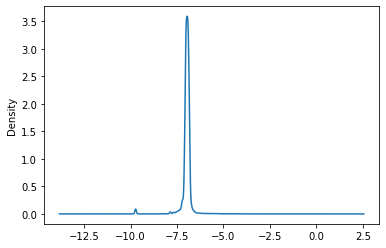

In [ ]:
df_0['info'].plot.kde();

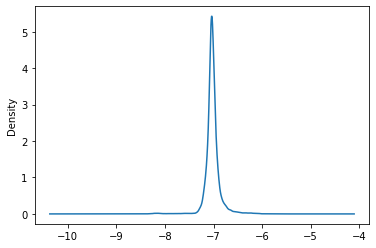

In [ ]:
df_0['pred'].plot.kde();

In [ ]:
_df.memory_usage().sum()/1024**3

0.0002981424331665039

Fancy Indexing:

In [ ]:
arr = np.empty((8,4))

In [ ]:
for i in range(8):
    arr[i] = i

In [ ]:
arr

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [2., 2., 2., 2.],
       [3., 3., 3., 3.],
       [4., 4., 4., 4.],
       [5., 5., 5., 5.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]])

In [ ]:
arr[[4, 3, 0, 6]]

array([[4., 4., 4., 4.],
       [3., 3., 3., 3.],
       [0., 0., 0., 0.],
       [6., 6., 6., 6.]])

In [ ]:
arr[[-3, -5, -7]]

array([[5., 5., 5., 5.],
       [3., 3., 3., 3.],
       [1., 1., 1., 1.]])

In [ ]:
arr = np.arange(32).reshape((8,4))

In [ ]:
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23],
       [24, 25, 26, 27],
       [28, 29, 30, 31]])

In [ ]:
test_eq(arr[[1, 5, 7, 2], [0, 3, 1, 2]] , [arr[o] for o in list(zip([1, 5, 7, 2], [0, 3, 1, 2]))])

In [ ]:
arr[[1, 5, 7, 2]]

array([[ 4,  5,  6,  7],
       [20, 21, 22, 23],
       [28, 29, 30, 31],
       [ 8,  9, 10, 11]])

In [ ]:
arr[[1, 5, 7, 2]][:, [0, 3, 1, 2]]

array([[ 4,  7,  5,  6],
       [20, 23, 21, 22],
       [28, 31, 29, 30],
       [ 8, 11,  9, 10]])

In [ ]:
ind = [[0,3,1,2], [2,1,3,0], [0,1,2,3], [3,1,2,0]]
ind

[[0, 3, 1, 2], [2, 1, 3, 0], [0, 1, 2, 3], [3, 1, 2, 0]]

In [ ]:
arr[[1, 5, 7, 2]][ :, ind ]

array([[[ 4,  7,  5,  6],
        [ 6,  5,  7,  4],
        [ 4,  5,  6,  7],
        [ 7,  5,  6,  4]],

       [[20, 23, 21, 22],
        [22, 21, 23, 20],
        [20, 21, 22, 23],
        [23, 21, 22, 20]],

       [[28, 31, 29, 30],
        [30, 29, 31, 28],
        [28, 29, 30, 31],
        [31, 29, 30, 28]],

       [[ 8, 11,  9, 10],
        [10,  9, 11,  8],
        [ 8,  9, 10, 11],
        [11,  9, 10,  8]]])

In [ ]:
arr[[1, 5, 7, 2]][[0, 3, 1, 2], :]

array([[ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [20, 21, 22, 23],
       [28, 29, 30, 31]])

Rearrange columns:

In [ ]:
a = array([[10, 20, 30, 40, 50],
       [ 6,  7,  8,  9, 10]])
a

array([[10, 20, 30, 40, 50],
       [ 6,  7,  8,  9, 10]])

change it to 

In [ ]:
array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

by applying the permutation

0 -> 0 

1 -> 4

2 -> 1

3 -> 3

4 -> 2

In [ ]:
permutation = [0,4,1,3,2]

In [ ]:
idx = np.empty_like(permutation)

In [ ]:
idx

array([0, 4, 1, 3, 2])

In [ ]:
idx[permutation] = np.arange(len(permutation))

In [ ]:
idx

array([0, 2, 4, 3, 1])

In [ ]:
a

array([[10, 20, 30, 40, 50],
       [ 6,  7,  8,  9, 10]])

In [ ]:
a[:,idx]

array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])

In [ ]:
a[:] = a[:,idx] # in-place modifcation of a

In [ ]:
a

array([[10, 30, 50, 40, 20],
       [ 6,  8, 10,  9,  7]])